# 1. Overview

The notebook details a process to select ASML suppliers by analyzing historical stock data for companies like: Carl Zeiss Meditec, Lam Research Corporation, and Tokyo Electron Limited. It involves retrieving stock data, plotting trends, checking for seasonality, and using Prophet models to forecast weekly closing prices. The forecasting models for each supplier were optimized through fine-tuning, and key metrics like MAPE and RMSE were calculated to assess accuracy. The final models were saved, along with the weekly supplier data, for future reference and further analysis.

# 2. Data Understanding

## 2.1 Data Description

## 2.2 Import necessary libraries

In [1]:
# pip install optuna

In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
import logging
import joblib
import optuna

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error
from sktime.utils.plotting import plot_series
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.model_selection import ParameterGrid
from itertools import product

# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Disable all logs from cmdstanpy by setting the logger to the ERROR level
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

C:\Users\Usuario\anaconda3\envs\forecastingv2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 2.3 Define Global Variables

In [3]:
# Define the company tickers and names
company_tickers = {
    'CZMWY': 'Carl Zeiss Meditec',
    'LRCX': 'Lam Research Corporation',
    'TOELY': 'Tokyo Electron Limited',
    'TSM': 'Taiwan Semiconductor Manufacturing Company',
    '005930.KS': 'Samsung Electronics',
    'INTC': 'Intel Corporation'
}
start_date = '2013-01-01'
output_data = 'data/weekly_data_suppliers.csv'

test_weeks = 16

## 2.4 Functions

In [4]:
def get_historical_data(ticker_symbol:str, start_date:str, end_date:str)->pd.DataFrame:
    """
    Fetches historical stock data for a given company between specified dates. 
    Returns a DataFrame containing the historical data.

    Input:
    - ticker_symbol: The stock ticker of the company (e.g., 'ASML').
    - start_date: The start date for the historical data (e.g., '2000-01-01').
    - end_date: The end date for the historical data (e.g., '2024-10-05').

    Output:
    - A pandas DataFrame containing the historical stock data for the specified period.
    """
    # Define the ticker symbol
    stock_data = yf.Ticker(ticker_symbol)

    # Download historical data between the start and end dates
    historical_data = stock_data.history(start=start_date, end=end_date)

    # Reset the index to convert 'Date' from an index to a regular column
    historical_data.reset_index(inplace=True)

    # Return the resulting DataFrame
    return historical_data

In [5]:
def plot_closing_prices(data:pd.DataFrame, close_column:str, company_name:str):
    """
    Plots the historical closing prices of a company's stock over time.

    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.

    Output:
    - A line plot of the company's historical closing prices.
    """
    
    # Convert the 'Date' and 'Close' columns to numpy arrays
    dates = np.array(data.index)
    close_prices = np.array(data[close_column])

    # Create the plot for the 'Close' (closing price) column using matplotlib
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.plot(dates, close_prices, label='Closing Price', color='blue')

    # Add title and axis labels
    plt.title(f'Historical Closing Prices of {company_name} between {dates[0]} and {dates[-1]}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price (USD)')

    # Rotate X-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the legend
    plt.legend()

    # Adjust layout to prevent overlap of elements
    plt.tight_layout()

    # Display the plot
    plt.show()


In [6]:
def plot_stock_with_multiple_boxplots(data: pd.DataFrame, close_column: str, company_name: str):
    """
    Plots the stock's closing price distribution for weekly, monthly, and quarterly with
    multiple boxplots for each period.
    
    Input:
    - data: DataFrame containing the stock data with 'Date' and 'Close' columns.
    - close_column: The name of the 'Close' column to be displayed in the plot title.
    - company_name: The name of the company to be displayed in the plot title.
    
    Output:
    - Boxplots for each period (7 for weekly, 12 for monthly, and 4 for quarterly).
    """

    # Ensure 'Date' column is in datetime format
    data['Date'] = pd.to_datetime(data.index)

    # Extract additional time period information
    data['Weekday'] = data['Date'].dt.weekday  # Weekday (0=Monday, 6=Sunday)
    data['Month'] = data['Date'].dt.month      # Month (1=January, 12=December)
    data['Quarter'] = data['Date'].dt.quarter  # Quarter (1 to 4)

    # Plot Weekly Data (7 boxplots for each day of the week)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Weekday', grid=True)
    plt.title(f'{company_name} - Weekly Closing Prices (by Weekday)')
    plt.suptitle('')
    plt.xlabel('Weekday (0=Monday, 6=Sunday)')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Monthly Data (12 boxplots for each month)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Month', grid=True)
    plt.title(f'{company_name} - Monthly Closing Prices (by Month)')
    plt.suptitle('')
    plt.xlabel('Month')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    # Plot Quarterly Data (4 boxplots for each quarter)
    plt.figure(figsize=(12, 8))
    data.boxplot(column=close_column, by='Quarter', grid=True)
    plt.title(f'{company_name} - Quarterly Closing Prices (by Quarter)')
    plt.suptitle('')
    plt.xlabel('Quarter')
    plt.ylabel('Closing Price (USD)')
    plt.show()

    return data

In [7]:
def get_last_friday():
    """
    Input: No arguments; the function uses the current date as the starting point.
    Output: Returns `end_date` as a string formatted as `YYYY-MM-DD`, representing the last Friday's date.
    Logic: Calculate the number of days back to the last Friday.    
    
    """
    today = datetime.today()
    # Calculate the number of days back to the last Friday
    days_back = (today.weekday() - 4) % 7
    last_friday = today - timedelta(days=days_back)
    end_date = last_friday.strftime("%Y-%m-%d")
    return end_date


end_date = get_last_friday()

## 2.5 Code

### 2.5.1 Looking at the dataset

We are going to load the data using the function get_historical_data

In [8]:
# Create an empty DataFrame for the merged data
merged_data = pd.DataFrame()

# Load historical data for each company and merge
for ticker, company_name in company_tickers.items():
    print(f"Loading data for {company_name}...")

    # Call the function get_historical_data for each ticker
    historical_data = get_historical_data(ticker, start_date, end_date)

    # Convert 'Date' column to datetime format and keep only the date (without time)
    historical_data['Date'] = pd.to_datetime(historical_data['Date']).dt.date

    # Rename 'Close' column to include the company name
    historical_data.rename(columns={'Close': f'Close_{company_name}'}, inplace=True)

    # If merged_data is empty, initialize it with the first company's data
    if merged_data.empty:
        merged_data = historical_data[['Date', f'Close_{company_name}']]
    else:
        # Merge with the existing DataFrame on 'Date'
        merged_data = merged_data.merge(historical_data[['Date', f'Close_{company_name}']], on='Date', how='outer')

# Set 'Date' as the index
merged_data.set_index('Date', inplace=True)

# Display the merged data
merged_data.head()

Loading data for Carl Zeiss Meditec...
Loading data for Lam Research Corporation...
Loading data for Tokyo Electron Limited...
Loading data for Taiwan Semiconductor Manufacturing Company...
Loading data for Samsung Electronics...
Loading data for Intel Corporation...


Close_Carl Zeiss Meditec  Close_Lam Research Corporation  \
Date                                                                   
2013-01-02                 25.741583                        2.052360   
2013-01-03                 25.741583                        2.012617   
2013-01-04                 25.961220                        2.017386   
2013-01-07                 25.961220                        1.990891   
2013-01-08                 25.961220                        1.959625   

            Close_Tokyo Electron Limited  \
Date                                       
2013-01-02                      7.846667   
2013-01-03                      7.766667   
2013-01-04                      7.700000   
2013-01-07                      7.613333   
2013-01-08                      7.366667   

            Close_Taiwan Semiconductor Manufacturing Company  \
Date                                                           
2013-01-02                                         13.070147   
2013-01-03                                         13.062925   
2013-01-04                                         12.969050   
2013-01-07                                         12.781305   
2013-01-08                                         12.665766   

            Close_Samsung Electronics  Close_Intel Corporation  
Date                                                            
2013-01-02               24318.664062                15.289296  
2013-01-03               23809.449219                15.246392  
2013-01-04               23531.697266                15.131974  
2013-01-07               23454.548828                15.196329  
2013-01-08               23145.935547                15.081912

Now let's plot the stock data

****CARL ZEISS MEDITEC****



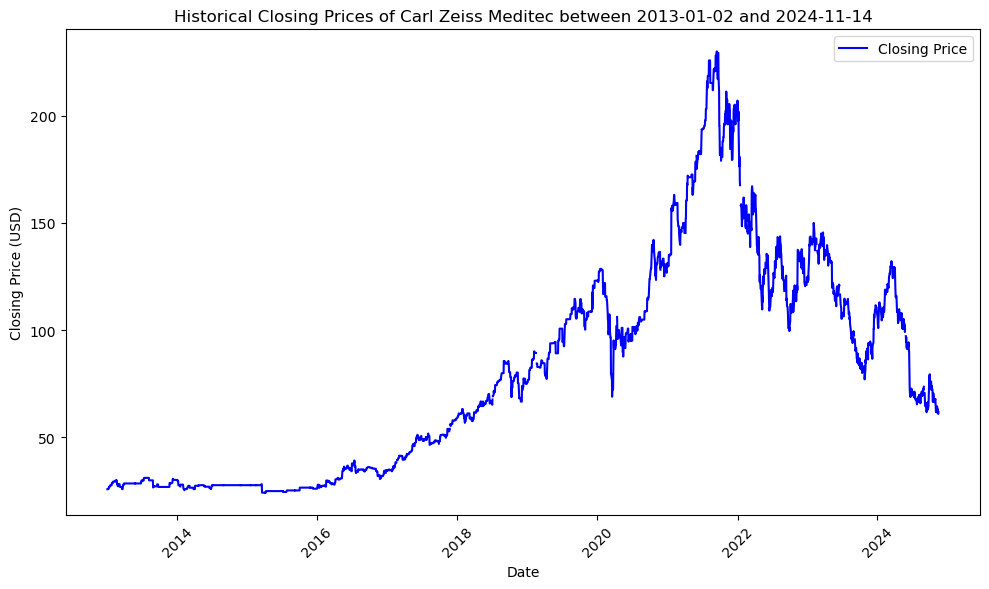


****LAM RESEARCH CORPORATION****



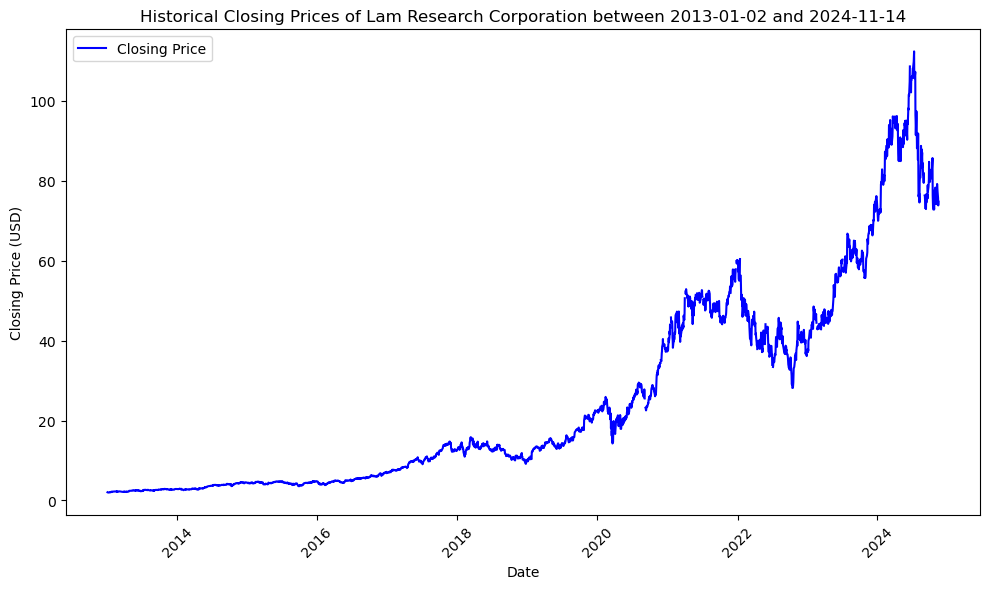


****TOKYO ELECTRON LIMITED****



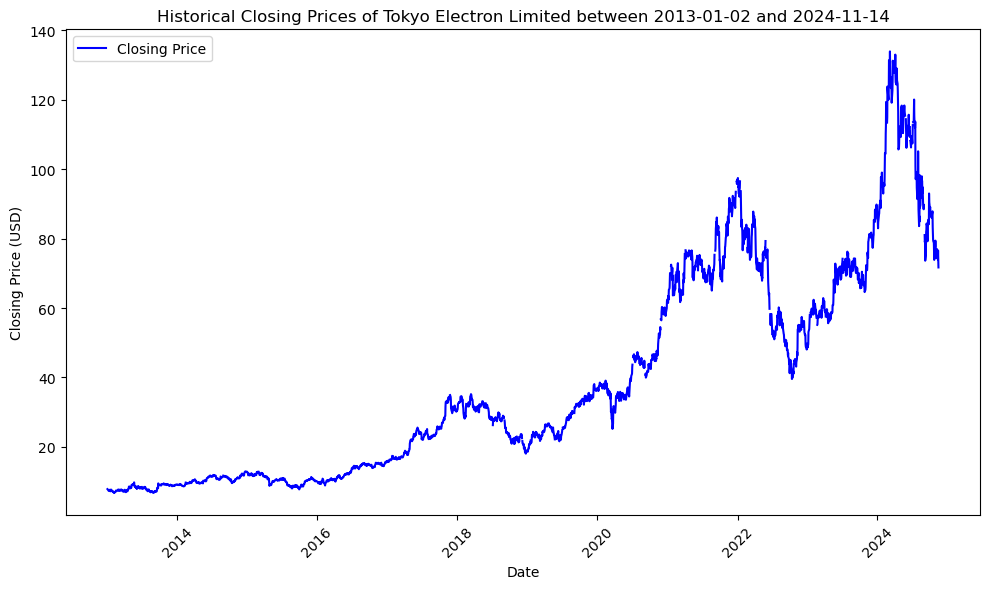


****TAIWAN SEMICONDUCTOR MANUFACTURING COMPANY****



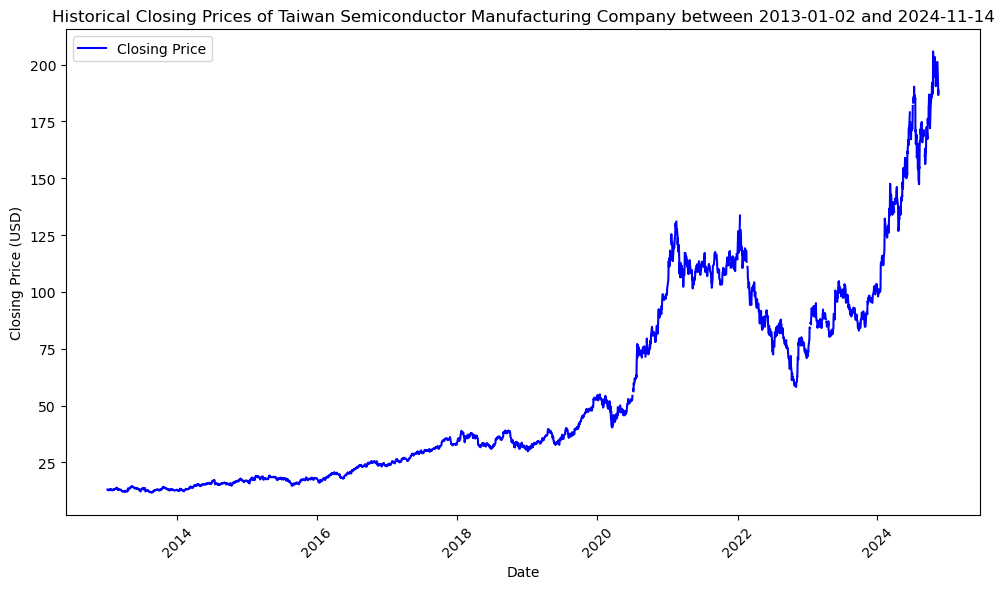


****SAMSUNG ELECTRONICS****



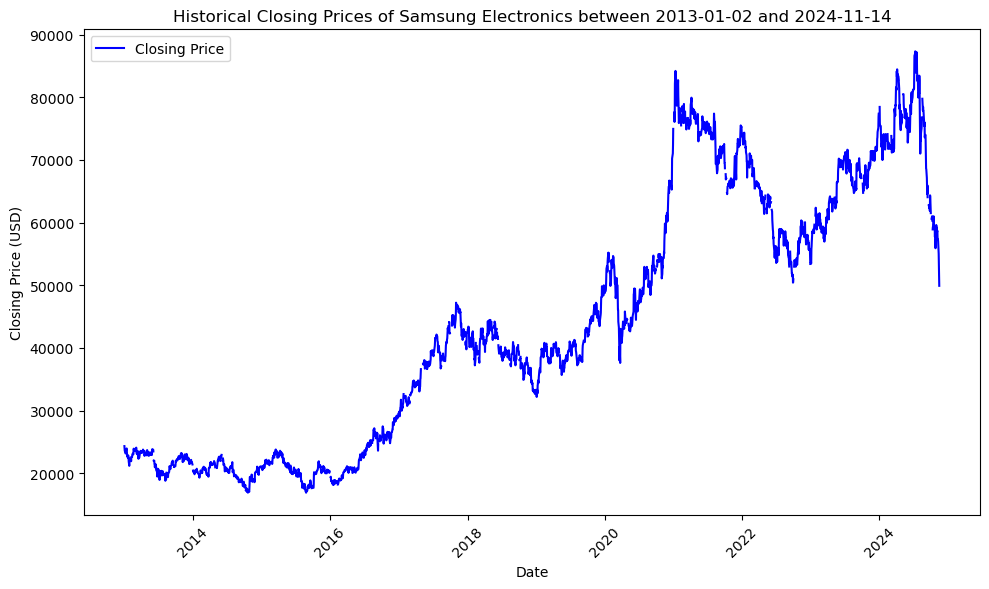


****INTEL CORPORATION****



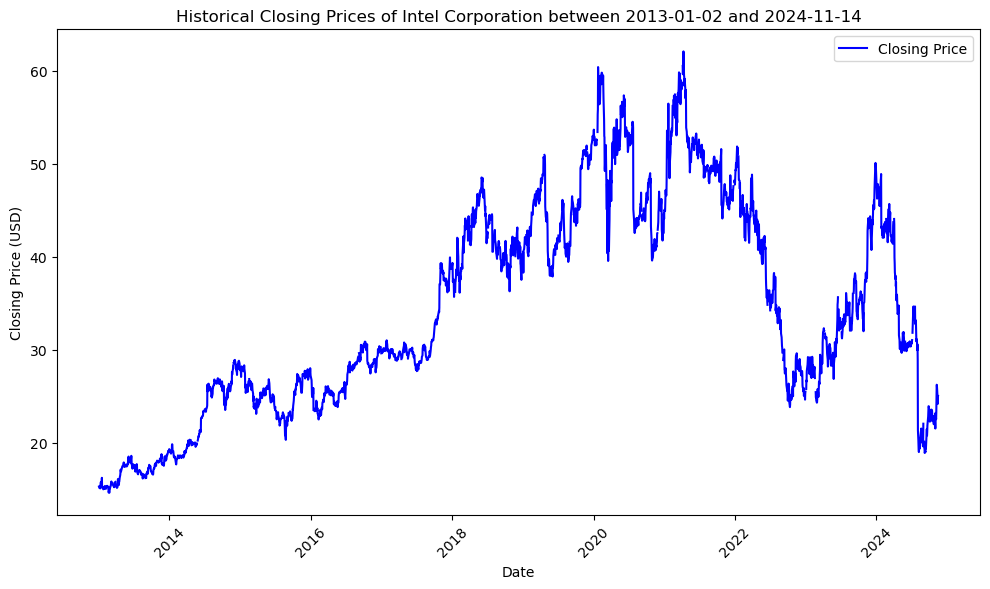

In [9]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_closing_prices(merged_data,f'Close_{company}',company)
    print()

### 2.5.2 Checking for duplicate values

In [10]:
merged_data.duplicated().sum()

1

There are no duplicated values. So we can continue

### 2.5.3 Checking for missing dates

In [11]:
(merged_data.isna().sum()/len(merged_data))*100

Close_Carl Zeiss Meditec                            2.923027
Close_Lam Research Corporation                      2.923027
Close_Tokyo Electron Limited                        2.923027
Close_Taiwan Semiconductor Manufacturing Company    2.923027
Close_Samsung Electronics                           5.293927
Close_Intel Corporation                             2.923027
dtype: float64

As we can see there aren't any null values

### 2.5.4 Looking at seasonality

****CARL ZEISS MEDITEC****



<Figure size 1200x800 with 0 Axes>

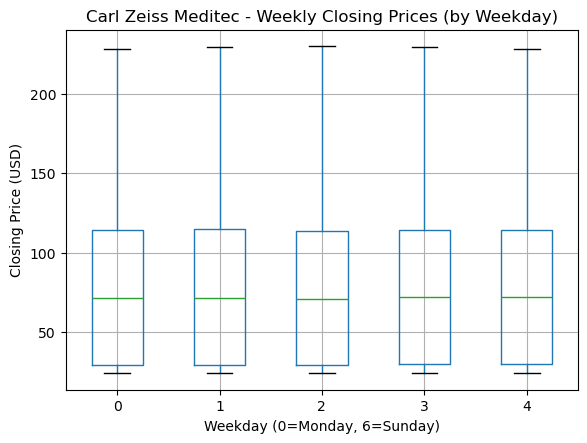

<Figure size 1200x800 with 0 Axes>

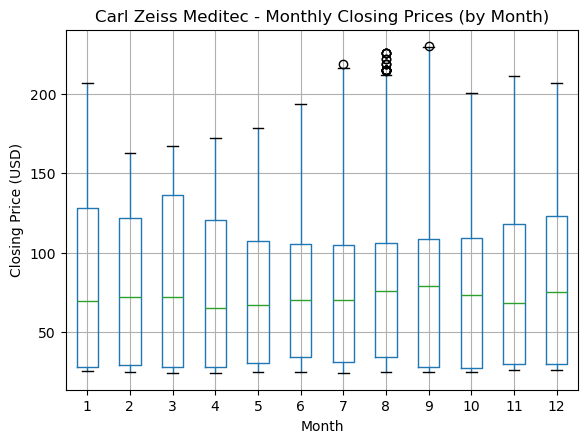

<Figure size 1200x800 with 0 Axes>

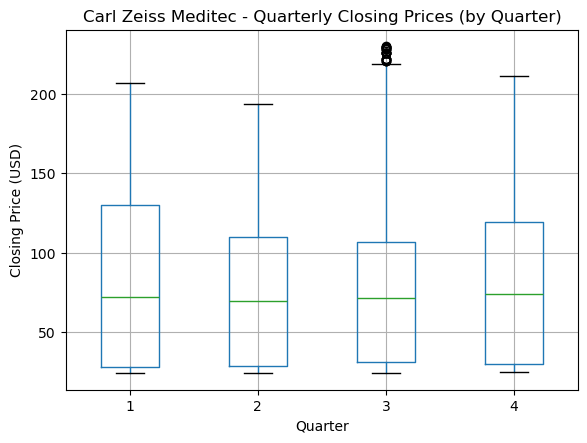


****LAM RESEARCH CORPORATION****



<Figure size 1200x800 with 0 Axes>

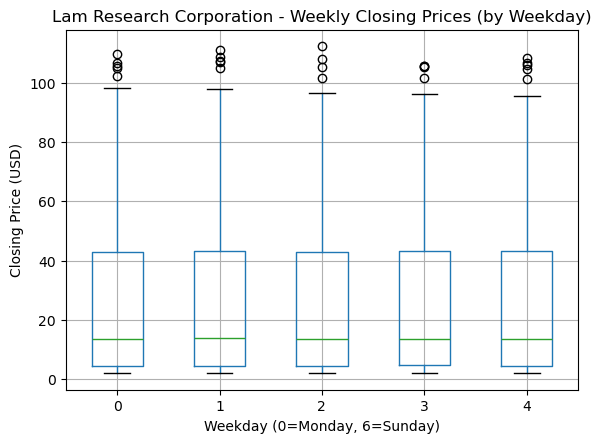

<Figure size 1200x800 with 0 Axes>

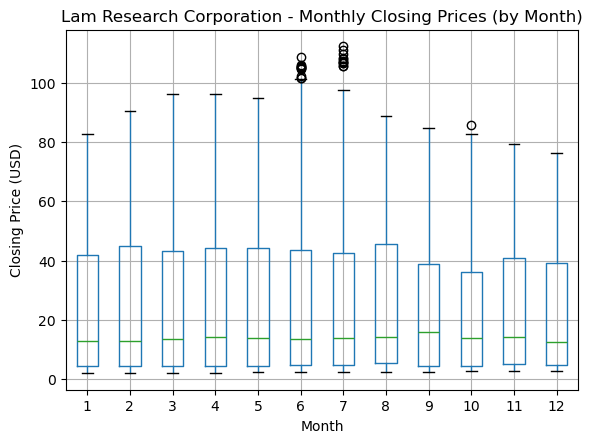

<Figure size 1200x800 with 0 Axes>

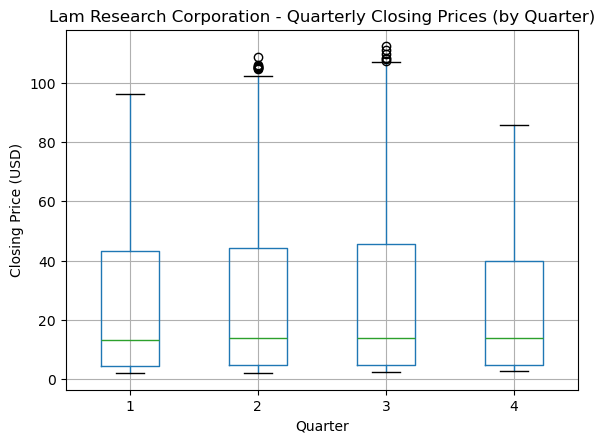


****TOKYO ELECTRON LIMITED****



<Figure size 1200x800 with 0 Axes>

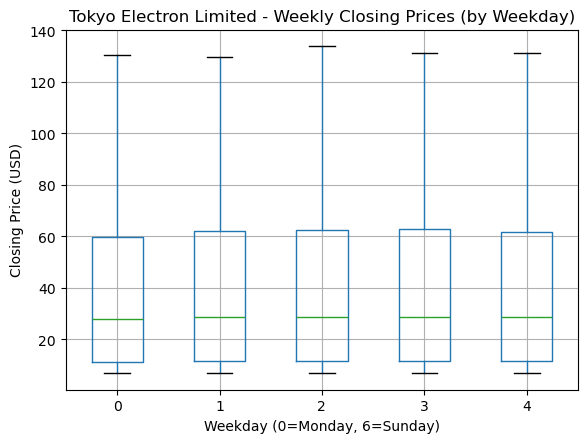

<Figure size 1200x800 with 0 Axes>

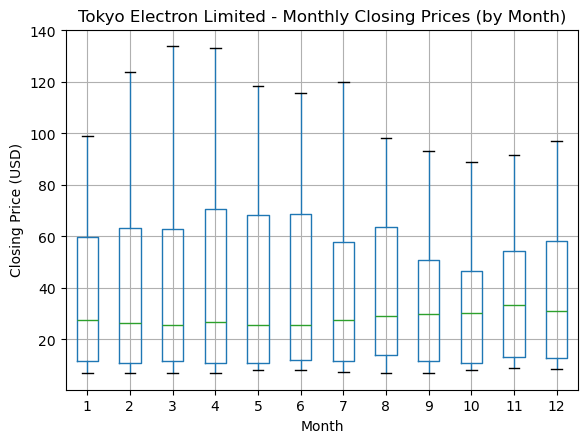

<Figure size 1200x800 with 0 Axes>

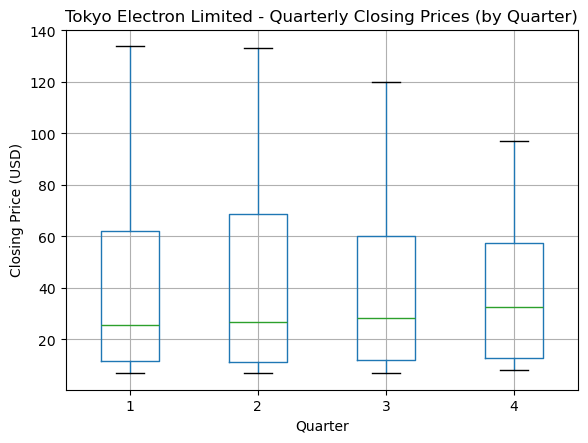


****TAIWAN SEMICONDUCTOR MANUFACTURING COMPANY****



<Figure size 1200x800 with 0 Axes>

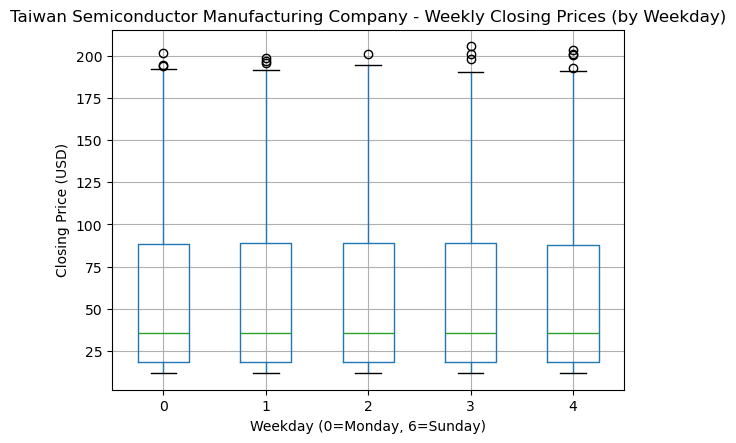

<Figure size 1200x800 with 0 Axes>

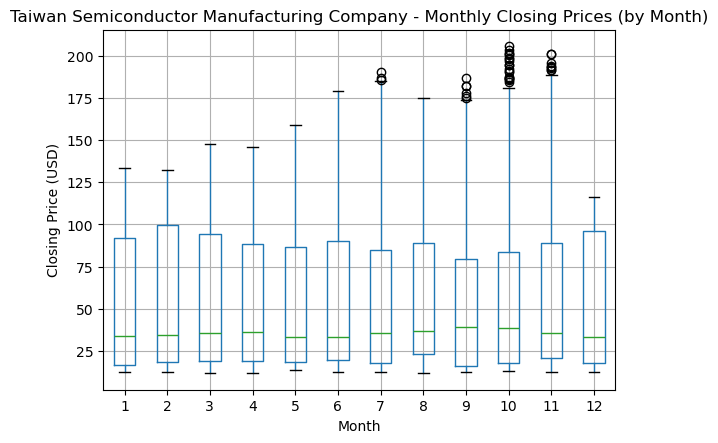

<Figure size 1200x800 with 0 Axes>

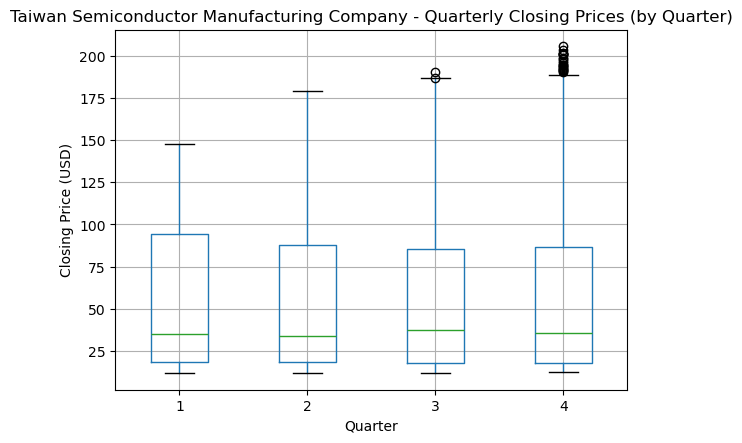


****SAMSUNG ELECTRONICS****



<Figure size 1200x800 with 0 Axes>

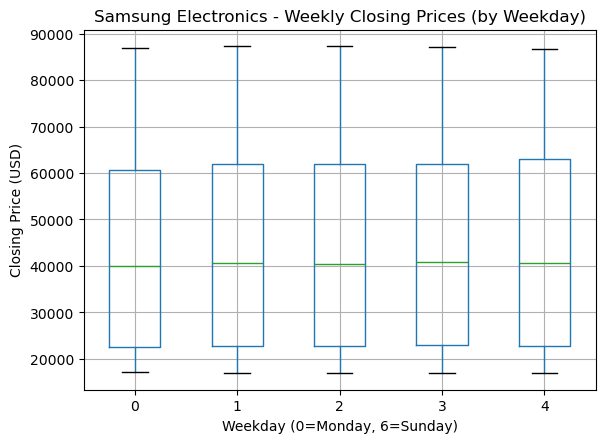

<Figure size 1200x800 with 0 Axes>

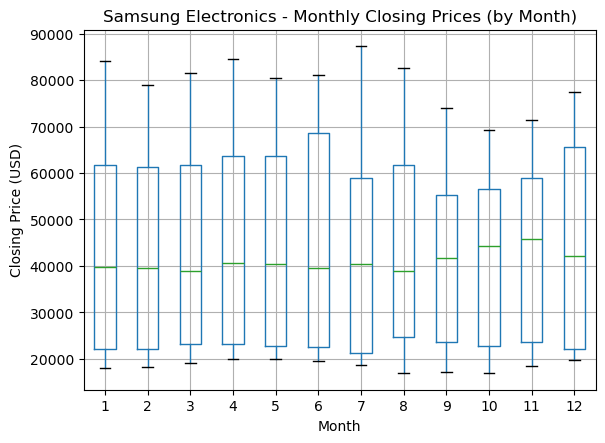

<Figure size 1200x800 with 0 Axes>

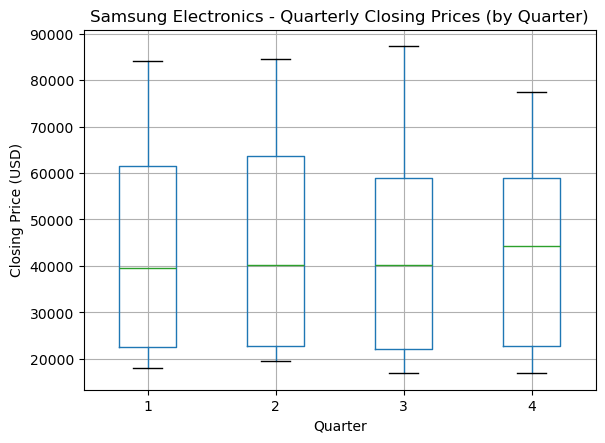


****INTEL CORPORATION****



<Figure size 1200x800 with 0 Axes>

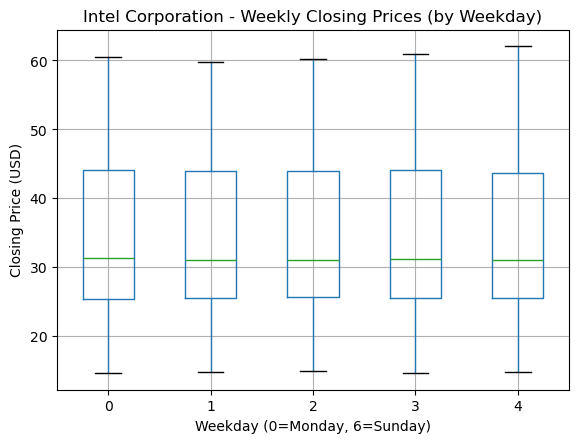

<Figure size 1200x800 with 0 Axes>

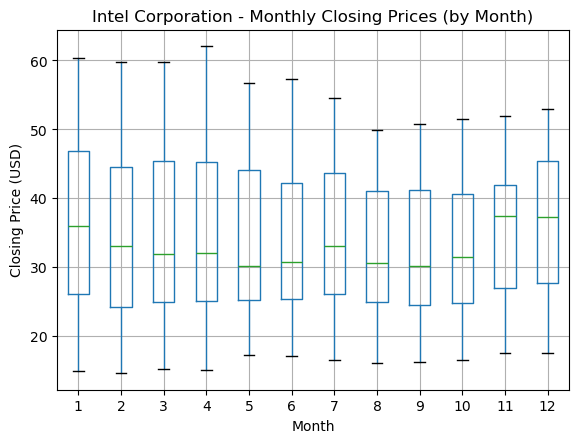

<Figure size 1200x800 with 0 Axes>

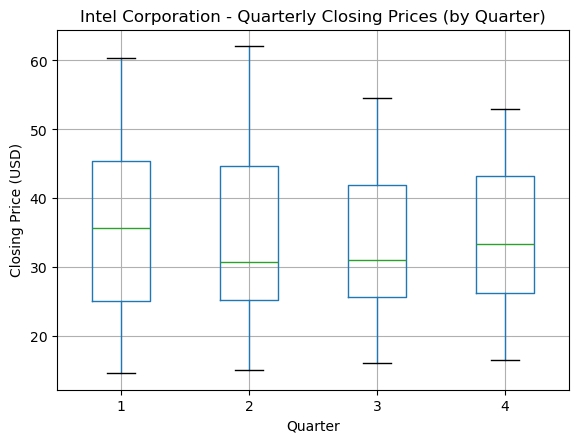

In [12]:
for company in company_tickers.values():
    print(f'****{company.upper()}****')
    print()
    plot_stock_with_multiple_boxplots(merged_data,f'Close_{company}',company)
    print()

With the results above, we cannot determine if there is any clear seasonality for any of the three suppliers. 

### 2.5.5 Choosing the time series of our dataset

Let's chose just the weekly data for the suppliers. To be consistent with the logic with which we viewed ASML's stock data

In [13]:
# Convert the index to a datetime index if it's not already
merged_data.index = pd.to_datetime(merged_data.index)

# Resample the data to weekly frequency and calculate the median
weekly_data_suppliers = merged_data.resample('W').median()

# Display the weekly data
weekly_data_suppliers.head()

Close_Carl Zeiss Meditec  Close_Lam Research Corporation  \
Date                                                                   
2013-01-06                 25.741583                        2.017386   
2013-01-13                 26.057861                        1.990891   
2013-01-20                 27.226334                        2.030634   
2013-01-27                 27.674397                        2.124429   
2013-02-03                 28.728662                        2.210804   

            Close_Tokyo Electron Limited  \
Date                                       
2013-01-06                      7.766667   
2013-01-13                      7.480000   
2013-01-20                      7.460000   
2013-01-27                      7.406667   
2013-02-03                      7.140000   

            Close_Taiwan Semiconductor Manufacturing Company  \
Date                                                           
2013-01-06                                         13.062925   
2013-01-13                                         12.781305   
2013-01-20                                         13.005158   
2013-01-27                                         12.987106   
2013-02-03                                         12.824632   

            Close_Samsung Electronics  Close_Intel Corporation       Date  \
Date                                                                        
2013-01-06               23809.449219                15.246392 2013-01-03   
2013-01-13               23454.548828                15.339354 2013-01-09   
2013-01-20               23022.486328                15.732679 2013-01-16   
2013-01-27               22436.125000                15.042582 2013-01-23   
2013-02-03               22220.095703                15.217783 2013-01-30   

            Weekday  Month  Quarter  
Date                                 
2013-01-06      3.0    1.0      1.0  
2013-01-13      2.0    1.0      1.0  
2013-01-20      2.0    1.0      1.0  
2013-01-27      2.0    1.0      1.0  
2013-02-03      2.0    1.0      1.0

### 2.5.6 Prophet model for each supplier

#### 2.5.6.1 Train-test split

In [14]:
# Drop unnecessary columns from the dataframe
weekly_data_suppliers = weekly_data_suppliers.drop(columns=['Date', 'Weekday', 'Month', 'Quarter'], axis=1)

In [15]:
# Create dictionaries to store train and test dataframes for each company
train_dataframes = {}
test_dataframes = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Filter only the columns corresponding to the current company
    company_data = weekly_data_suppliers[[f'Close_{company}']]
    
    # Rename the column to 'Close'
    company_data.columns = ['Close']
    
    # Create train and test dataframes
    train_dataframes[company] = company_data[:-test_weeks]
    test_dataframes[company] = company_data[-test_weeks:]
    
    # Set 'Date' as the index of the dataframe
    train_dataframes[company].index.name = 'Date'
    test_dataframes[company].index.name = 'Date'

# Display the train dataframe for 'Carl Zeiss Meditec' as an example
train_dataframes['Carl Zeiss Meditec'].head()

Close
Date                 
2013-01-06  25.741583
2013-01-13  26.057861
2013-01-20  27.226334
2013-01-27  27.674397
2013-02-03  28.728662

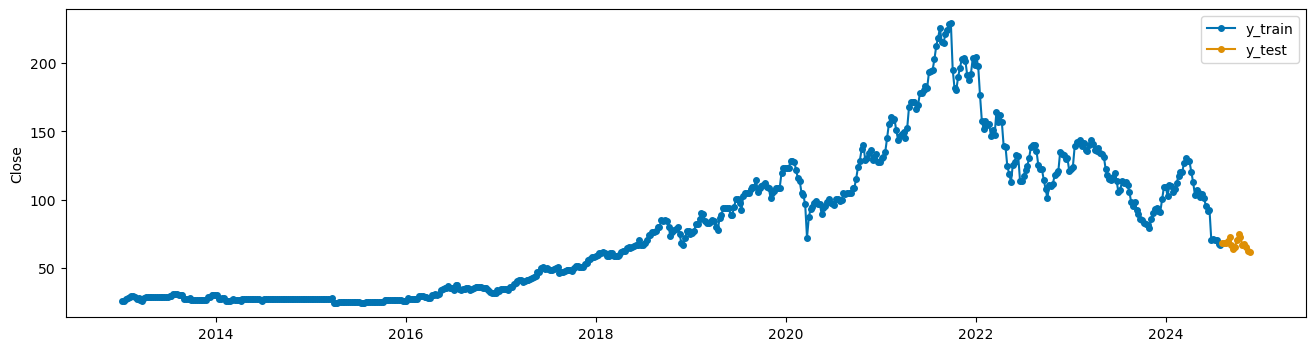

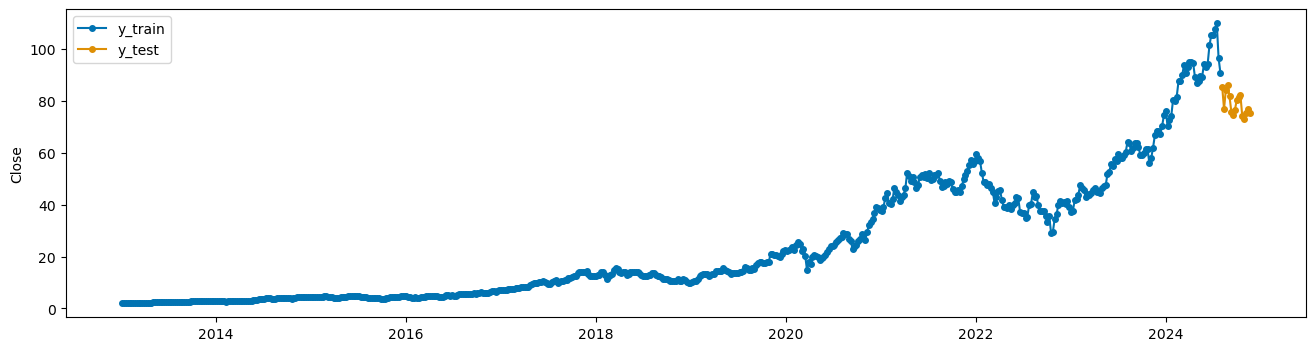

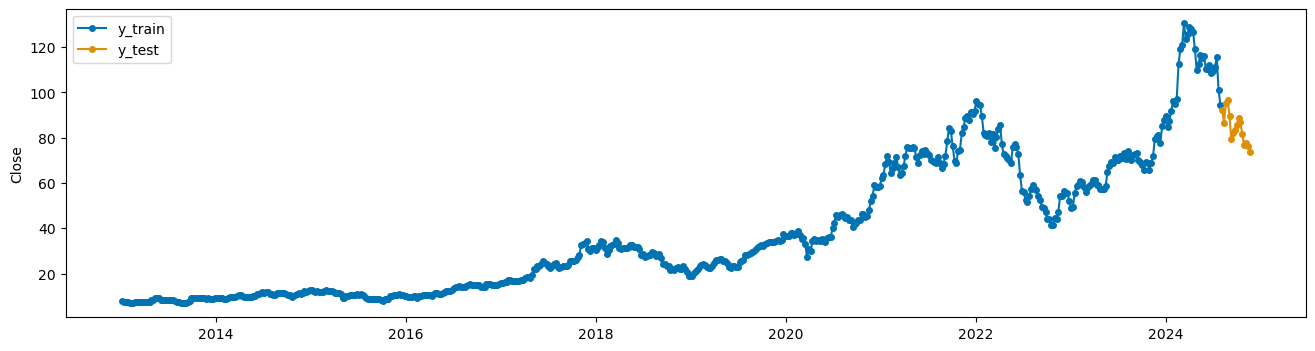

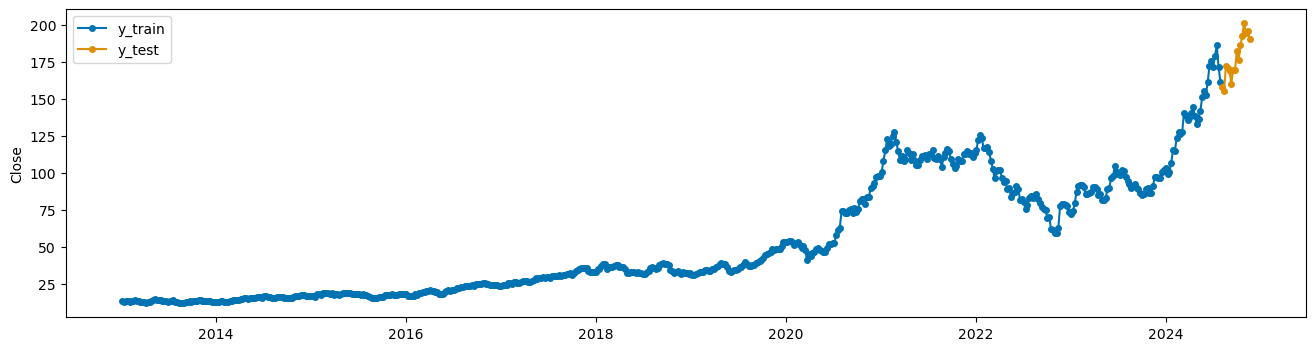

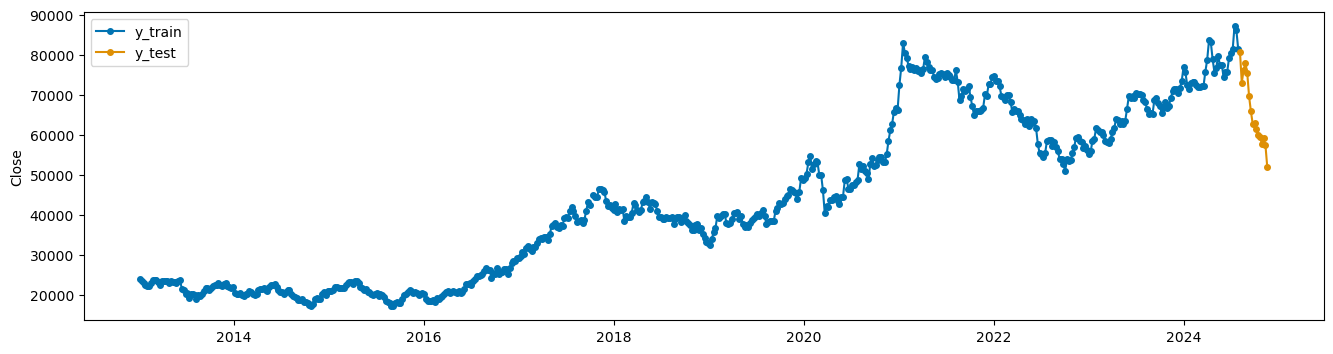

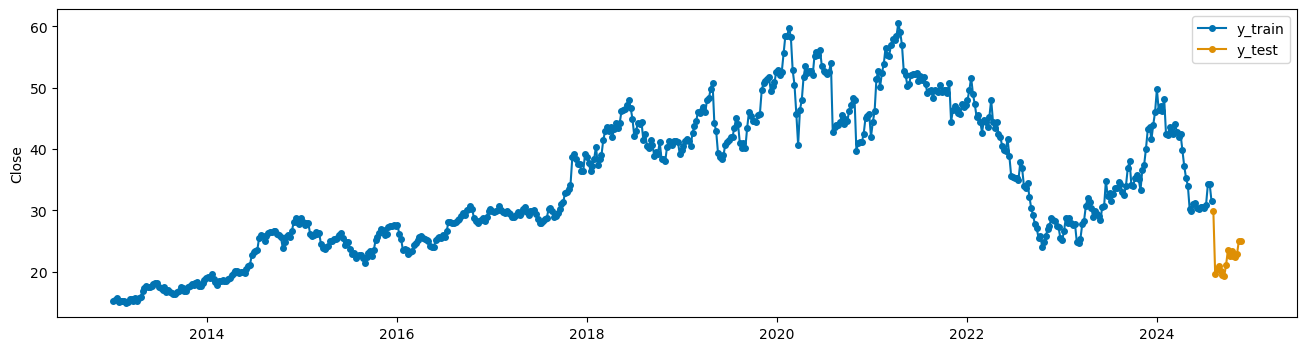

In [16]:
# Iterate over each company to plot the series
for company in company_tickers.values():
    # Extract the train and test data for the current company
    train_data = train_dataframes[company]
    test_data = test_dataframes[company]
    
    # Plot the series for the current company
    plot_series(train_data, test_data, labels=["y_train", "y_test"])

#### 2.5.6.2 Prophet models

19:33:39 - cmdstanpy - INFO - Chain [1] start processing
19:33:39 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Carl Zeiss Meditec
MAPE: 14.35
RMSE: 10.81


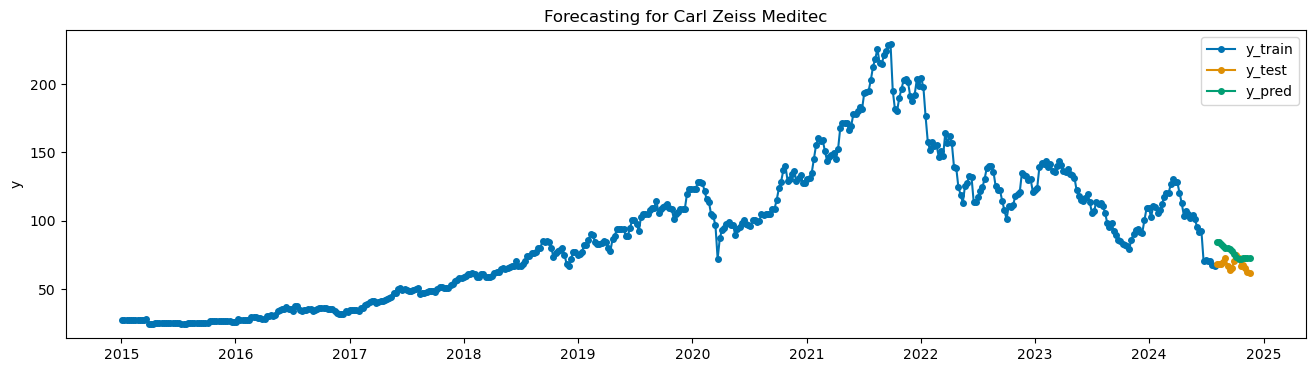

19:33:40 - cmdstanpy - INFO - Chain [1] start processing
19:33:40 - cmdstanpy - INFO - Chain [1] done processing
19:33:40 - cmdstanpy - INFO - Chain [1] start processing
19:33:40 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Lam Research Corporation
MAPE: 6.98
RMSE: 6.33


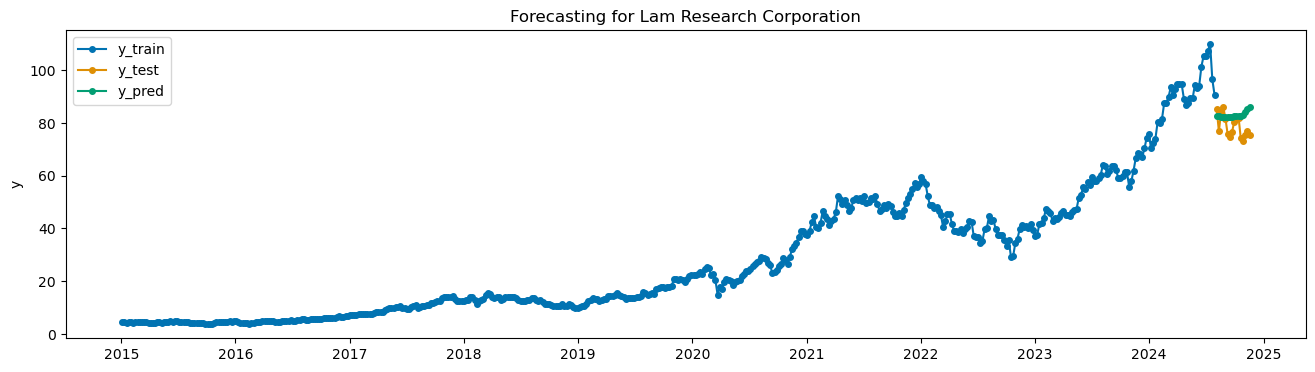

19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:33:41 - cmdstanpy - INFO - Chain [1] done processing
19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:33:41 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Tokyo Electron Limited
MAPE: 11.54
RMSE: 11.18


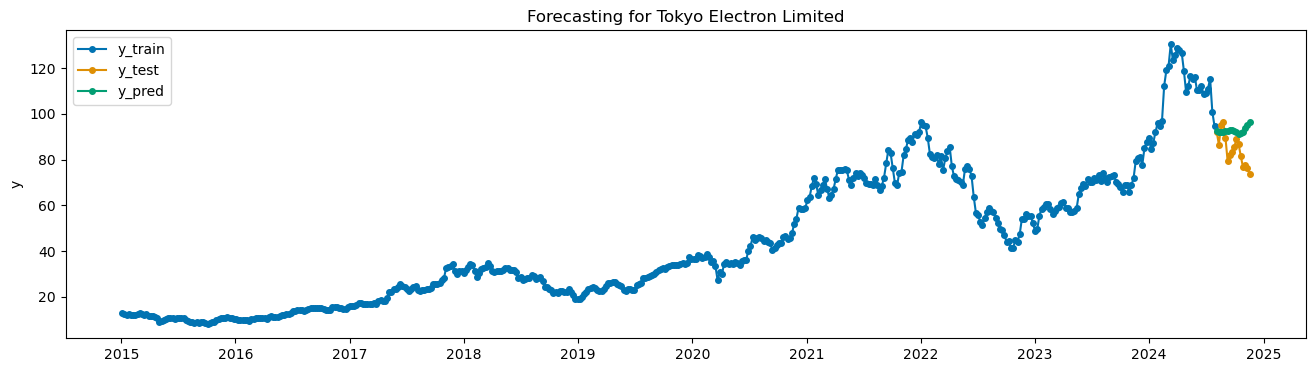

19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:33:41 - cmdstanpy - INFO - Chain [1] done processing
19:33:41 - cmdstanpy - INFO - Chain [1] start processing
19:33:41 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Taiwan Semiconductor Manufacturing Company
MAPE: 34.82
RMSE: 64.16


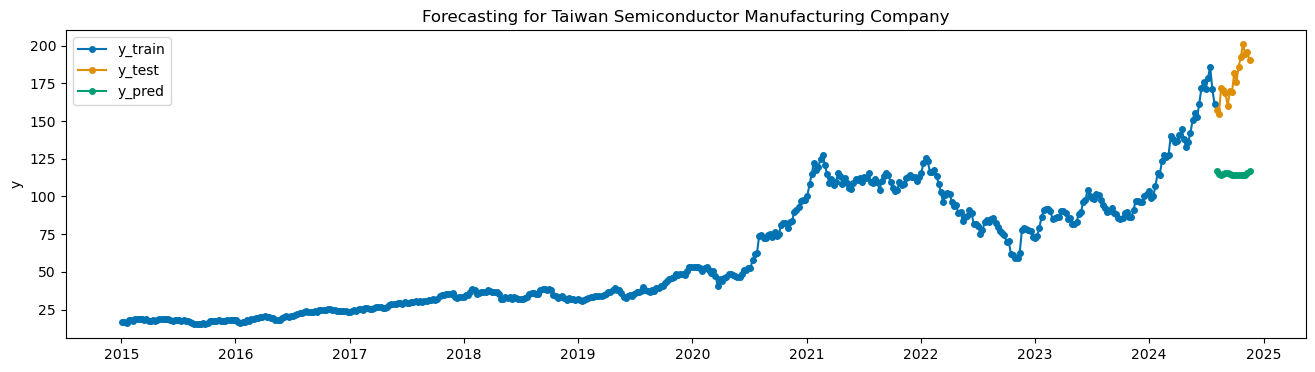

19:33:42 - cmdstanpy - INFO - Chain [1] start processing
19:33:42 - cmdstanpy - INFO - Chain [1] done processing
19:33:42 - cmdstanpy - INFO - Chain [1] start processing
19:33:42 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Samsung Electronics
MAPE: 13.84
RMSE: 9644.44


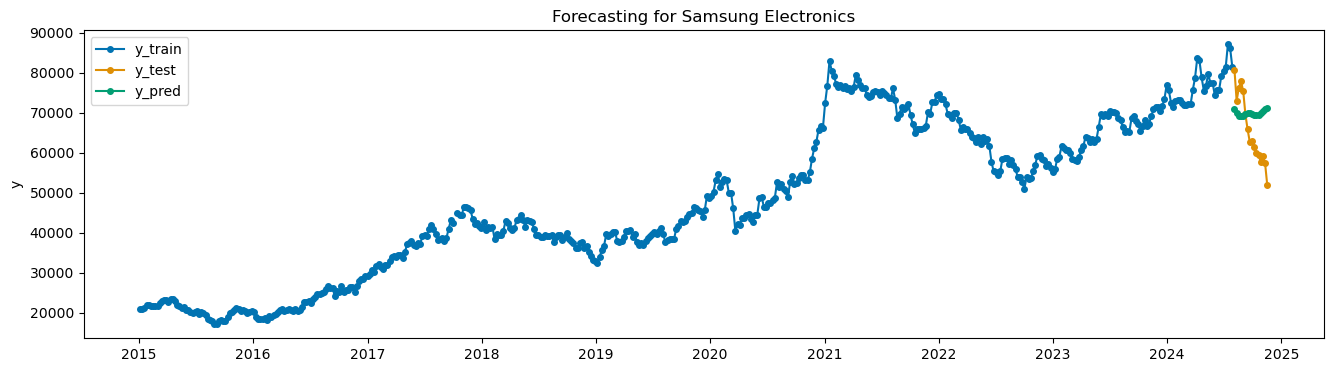

19:33:42 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing
19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


Forecasting for Intel Corporation
MAPE: 26.94
RMSE: 6.16


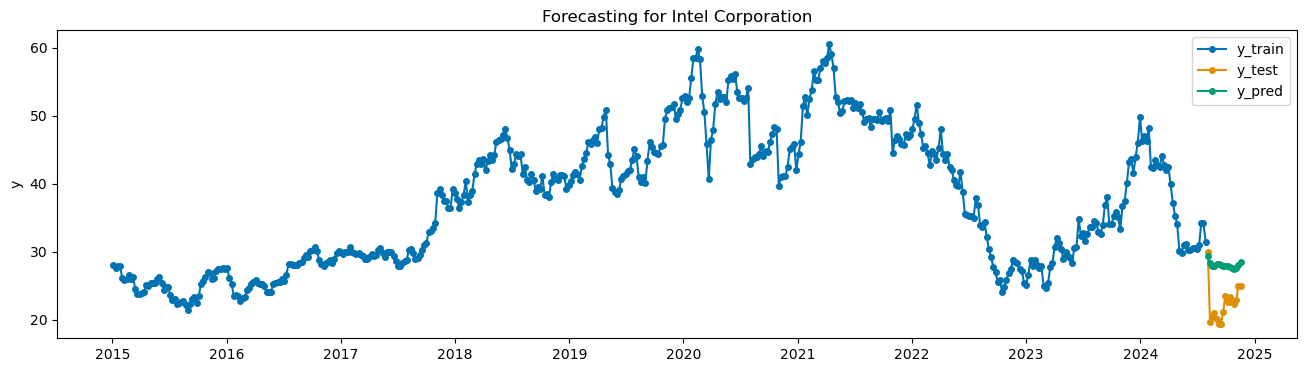

19:33:43 - cmdstanpy - INFO - Chain [1] start processing
19:33:43 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Dictionary to store each Prophet model by company
prophet_models = {}

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(train_data_prophet)

    # Define the forecast horizon (e.g., 12 periods into the future)
    future = prophet_model.make_future_dataframe(periods=test_weeks, freq='W')

    # Generate the predictions
    forecast = prophet_model.predict(future)

    # Return to the original DataFrame format with 'ds' as index and 'yhat' as 'Close'
    forecast = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Ensure 'ds' is the index of train_data_prophet 
    train_data_prophet = train_data_prophet.set_index('ds')

    # Calculate MAPE and RMSE errors
    actuals = test_dataframes[company]['Close']  # Actual values from test data
    predictions = forecast['Close']              # Predicted values from forecast

    # Ensure the indices of actuals and predictions align
    common_index = actuals.index.intersection(predictions.index)
    actuals = actuals.loc[common_index]
    predictions = predictions.loc[common_index]

    mape = mean_absolute_percentage_error(actuals, predictions)*100
    rmse = root_mean_squared_error(actuals, predictions)

    # Display errors
    print(f'Forecasting for {company}')
    print(f'MAPE: {mape:.2f}')
    print(f'RMSE: {rmse:.2f}')
    
    # Plot the forecast results
    plot_series(
        train_data_prophet[-500:],  # Only pass the 'Close' column for training data
        test_dataframes[company],   # Only pass the 'Close' column for test data
        forecast,                   # Only pass the 'Close' column for forecast
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Forecasting for {company}')  # Add title for better clarity
    plt.show()  # Show the plot before moving to the next company
    
    # We need are now going to save the prophet_models only that this time, we will fit it with all the data (train and test data) 
    # Initialize the Prophet model
    prophet_model = Prophet()
    # We have modified the data to be able to train the prophet model
    test_data = pd.DataFrame(actuals).rename(columns={'Close':'y'}).reset_index(names="ds")
    train_data_prophet = train_data_prophet.reset_index(names="ds")
    all_data = pd.concat([train_data_prophet,test_data])
    prophet_model.fit(all_data)
    
    # Store the model in the dictionary with the company name as key
    prophet_models[company] = prophet_model

#### 2.5.6.3 Fine-tunning the prophet models

We will first run a code using Optuna to gain an understanding of the approximate locations of the global minima for each company

In [18]:
# Dictionary to store the best parameters and MAPE for each company
best_params_per_company = {}
final_mape_per_company = {}
n_trials = 50  # Total number of trials to be tested

# Objective function for Optuna
def objective(trial, train_data_prophet, test_data, company_name):
    # Counter for the current trial
    current_trial = trial.number + 1
    print(f"{company_name} - Trial {current_trial}/{n_trials}: Optimizing...")

    # Suggest parameters within the new ranges
    changepoint_prior_scale = trial.suggest_float("changepoint_prior_scale", 0.001, 0.5)
    seasonality_prior_scale = trial.suggest_float("seasonality_prior_scale", 0.01, 10)

    # Create and fit the Prophet model with the suggested parameters
    model = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale
    )
    model.fit(train_data_prophet)

    # Make predictions
    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    # Calculate MAPE between test data and predictions
    actuals = test_data['Close']
    predictions = forecast_filtered['Close']
    common_index = actuals.index.intersection(predictions.index)
    mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100

    # Print the progress
    print(f"{company_name} - Completed Trial {current_trial}/{n_trials}. Remaining: {n_trials - current_trial} trials.")

    return mape

# Loop through each company in company_tickers
for company in company_tickers.values():
    print(f"Optimizing for {company}...")

    # Prepare training and test data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure the index is of datetime type
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    test_data = test_dataframes[company][['Close']].copy()
    test_data.index = pd.to_datetime(test_data.index)

    # Create an Optuna study and optimize
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, train_data_prophet, test_data, company), n_trials=n_trials)

    # Save the best parameters for the current company
    best_params_per_company[company] = study.best_params

    # Fit the model with the best parameters to calculate the final MAPE
    model = Prophet(
        changepoint_prior_scale=study.best_params['changepoint_prior_scale'],
        seasonality_prior_scale=study.best_params['seasonality_prior_scale']
    )
    model.fit(train_data_prophet)

    future = model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    actuals = test_data['Close']
    predictions = forecast_filtered['Close']
    common_index = actuals.index.intersection(predictions.index)
    final_mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100

    # Store the final MAPE for the company
    final_mape_per_company[company] = final_mape

# Print the best parameters and the final MAPE for all companies at the end
print("\nFinal results for each company:")
for company in company_tickers.values():
    print(f"{company}: Best parameters: {best_params_per_company[company]}, Final MAPE: {final_mape_per_company[company]:.2f}")

# Create a dictionary with the best parameters for each company using company_tickers
company_params = {
    ticker: {
        'changepoint_prior_scale': round(best_params_per_company[company]['changepoint_prior_scale'], 4),
        'seasonality_prior_scale': round(best_params_per_company[company]['seasonality_prior_scale'], 4)
    }
    for ticker, company in company_tickers.items()
}

print()

# Print or save the `company_params` dictionary
print("Company Parameters:", company_params)

[I 2024-11-15 19:33:43,706] A new study created in memory with name: no-name-7bd08431-3b39-45b5-b762-b0df8e5aebba
19:33:43 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Carl Zeiss Meditec...
Carl Zeiss Meditec - Trial 1/50: Optimizing...


19:33:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:44,040] Trial 0 finished with value: 28.50442540993007 and parameters: {'changepoint_prior_scale': 0.3294949479260481, 'seasonality_prior_scale': 3.145345933029935}. Best is trial 0 with value: 28.50442540993007.
19:33:44 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 1/50. Remaining: 49 trials.
Carl Zeiss Meditec - Trial 2/50: Optimizing...


19:33:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:44,400] Trial 1 finished with value: 25.18741054217791 and parameters: {'changepoint_prior_scale': 0.155291530157057, 'seasonality_prior_scale': 8.668781129507012}. Best is trial 1 with value: 25.18741054217791.
19:33:44 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 2/50. Remaining: 48 trials.
Carl Zeiss Meditec - Trial 3/50: Optimizing...


19:33:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:44,754] Trial 2 finished with value: 27.805626893487766 and parameters: {'changepoint_prior_scale': 0.2582227537412306, 'seasonality_prior_scale': 2.3026476650400673}. Best is trial 1 with value: 25.18741054217791.
19:33:44 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 3/50. Remaining: 47 trials.
Carl Zeiss Meditec - Trial 4/50: Optimizing...


19:33:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:45,090] Trial 3 finished with value: 26.828642648629007 and parameters: {'changepoint_prior_scale': 0.19056053507440165, 'seasonality_prior_scale': 0.13213153768690994}. Best is trial 1 with value: 25.18741054217791.
19:33:45 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 4/50. Remaining: 46 trials.
Carl Zeiss Meditec - Trial 5/50: Optimizing...


19:33:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:45,431] Trial 4 finished with value: 23.089840356816623 and parameters: {'changepoint_prior_scale': 0.11971777353302161, 'seasonality_prior_scale': 7.727438389218266}. Best is trial 4 with value: 23.089840356816623.
19:33:45 - cmdstanpy - INFO - Chain [1] start processing
19:33:45 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 5/50. Remaining: 45 trials.
Carl Zeiss Meditec - Trial 6/50: Optimizing...


[I 2024-11-15 19:33:45,711] Trial 5 finished with value: 14.161176278706971 and parameters: {'changepoint_prior_scale': 0.04529045871703352, 'seasonality_prior_scale': 5.180729805368357}. Best is trial 5 with value: 14.161176278706971.
19:33:45 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 6/50. Remaining: 44 trials.
Carl Zeiss Meditec - Trial 7/50: Optimizing...


19:33:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:46,007] Trial 6 finished with value: 20.295127567154207 and parameters: {'changepoint_prior_scale': 0.10280304062331914, 'seasonality_prior_scale': 6.612913048243864}. Best is trial 5 with value: 14.161176278706971.
19:33:46 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 7/50. Remaining: 43 trials.
Carl Zeiss Meditec - Trial 8/50: Optimizing...


19:33:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:46,413] Trial 7 finished with value: 28.76907126731908 and parameters: {'changepoint_prior_scale': 0.3085837987074248, 'seasonality_prior_scale': 1.5730808184476055}. Best is trial 5 with value: 14.161176278706971.
19:33:46 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 8/50. Remaining: 42 trials.
Carl Zeiss Meditec - Trial 9/50: Optimizing...


19:33:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:46,809] Trial 8 finished with value: 28.90072057522041 and parameters: {'changepoint_prior_scale': 0.4908357746911775, 'seasonality_prior_scale': 4.9917309488603925}. Best is trial 5 with value: 14.161176278706971.
19:33:46 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 9/50. Remaining: 41 trials.
Carl Zeiss Meditec - Trial 10/50: Optimizing...


19:33:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:47,191] Trial 9 finished with value: 28.13476047944603 and parameters: {'changepoint_prior_scale': 0.2664046770979844, 'seasonality_prior_scale': 5.984885786025981}. Best is trial 5 with value: 14.161176278706971.
19:33:47 - cmdstanpy - INFO - Chain [1] start processing
19:33:47 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 10/50. Remaining: 40 trials.
Carl Zeiss Meditec - Trial 11/50: Optimizing...


[I 2024-11-15 19:33:47,456] Trial 10 finished with value: 42.906715986809864 and parameters: {'changepoint_prior_scale': 0.012150263637004693, 'seasonality_prior_scale': 9.83795746306206}. Best is trial 5 with value: 14.161176278706971.
19:33:47 - cmdstanpy - INFO - Chain [1] start processing
19:33:47 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 11/50. Remaining: 39 trials.
Carl Zeiss Meditec - Trial 12/50: Optimizing...


[I 2024-11-15 19:33:47,741] Trial 11 finished with value: 14.137636563489464 and parameters: {'changepoint_prior_scale': 0.054023513856625904, 'seasonality_prior_scale': 5.661494490094699}. Best is trial 11 with value: 14.137636563489464.
19:33:47 - cmdstanpy - INFO - Chain [1] start processing
19:33:47 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 12/50. Remaining: 38 trials.
Carl Zeiss Meditec - Trial 13/50: Optimizing...


[I 2024-11-15 19:33:48,002] Trial 12 finished with value: 126.70856683599898 and parameters: {'changepoint_prior_scale': 0.006093454427512274, 'seasonality_prior_scale': 4.546960140358699}. Best is trial 11 with value: 14.137636563489464.
19:33:48 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 13/50. Remaining: 37 trials.
Carl Zeiss Meditec - Trial 14/50: Optimizing...


19:33:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:48,308] Trial 13 finished with value: 12.21536575456107 and parameters: {'changepoint_prior_scale': 0.06679709334937711, 'seasonality_prior_scale': 3.8423790763550083}. Best is trial 13 with value: 12.21536575456107.
19:33:48 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 14/50. Remaining: 36 trials.
Carl Zeiss Meditec - Trial 15/50: Optimizing...


19:33:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:48,676] Trial 14 finished with value: 13.776901905148195 and parameters: {'changepoint_prior_scale': 0.08239343940551214, 'seasonality_prior_scale': 2.853476319079544}. Best is trial 13 with value: 12.21536575456107.
19:33:48 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 15/50. Remaining: 35 trials.
Carl Zeiss Meditec - Trial 16/50: Optimizing...


19:33:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:49,147] Trial 15 finished with value: 27.319734826147123 and parameters: {'changepoint_prior_scale': 0.19749503034955251, 'seasonality_prior_scale': 3.7835955387588704}. Best is trial 13 with value: 12.21536575456107.
19:33:49 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 16/50. Remaining: 34 trials.
Carl Zeiss Meditec - Trial 17/50: Optimizing...


19:33:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:49,642] Trial 16 finished with value: 28.634022612527865 and parameters: {'changepoint_prior_scale': 0.4101911447866602, 'seasonality_prior_scale': 0.9813247784759564}. Best is trial 13 with value: 12.21536575456107.
19:33:49 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 17/50. Remaining: 33 trials.
Carl Zeiss Meditec - Trial 18/50: Optimizing...


19:33:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:49,959] Trial 17 finished with value: 17.24164541769847 and parameters: {'changepoint_prior_scale': 0.09254347831848136, 'seasonality_prior_scale': 2.7330894406988886}. Best is trial 13 with value: 12.21536575456107.
19:33:50 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 18/50. Remaining: 32 trials.
Carl Zeiss Meditec - Trial 19/50: Optimizing...


19:33:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:50,350] Trial 18 finished with value: 26.224687017102465 and parameters: {'changepoint_prior_scale': 0.1730212507790635, 'seasonality_prior_scale': 3.8884657862713126}. Best is trial 13 with value: 12.21536575456107.
19:33:50 - cmdstanpy - INFO - Chain [1] start processing
19:33:50 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 19/50. Remaining: 31 trials.
Carl Zeiss Meditec - Trial 20/50: Optimizing...


[I 2024-11-15 19:33:50,641] Trial 19 finished with value: 14.484384240135084 and parameters: {'changepoint_prior_scale': 0.07960398746117742, 'seasonality_prior_scale': 1.7142995821219222}. Best is trial 13 with value: 12.21536575456107.
19:33:50 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 20/50. Remaining: 30 trials.
Carl Zeiss Meditec - Trial 21/50: Optimizing...


19:33:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:50,996] Trial 20 finished with value: 23.971384424048164 and parameters: {'changepoint_prior_scale': 0.13226862286006852, 'seasonality_prior_scale': 6.9119399171268086}. Best is trial 13 with value: 12.21536575456107.
19:33:51 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 21/50. Remaining: 29 trials.
Carl Zeiss Meditec - Trial 22/50: Optimizing...


19:33:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:51,328] Trial 21 finished with value: 12.651244339007789 and parameters: {'changepoint_prior_scale': 0.061741570359222085, 'seasonality_prior_scale': 5.6494150928572715}. Best is trial 13 with value: 12.21536575456107.
19:33:51 - cmdstanpy - INFO - Chain [1] start processing
19:33:51 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 22/50. Remaining: 28 trials.
Carl Zeiss Meditec - Trial 23/50: Optimizing...


[I 2024-11-15 19:33:51,613] Trial 22 finished with value: 13.086165958859445 and parameters: {'changepoint_prior_scale': 0.056514428223124635, 'seasonality_prior_scale': 3.9612391013891672}. Best is trial 13 with value: 12.21536575456107.
19:33:51 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 23/50. Remaining: 27 trials.
Carl Zeiss Meditec - Trial 24/50: Optimizing...


19:33:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:51,914] Trial 23 finished with value: 15.282774122327403 and parameters: {'changepoint_prior_scale': 0.04433757703693322, 'seasonality_prior_scale': 4.15689521669465}. Best is trial 13 with value: 12.21536575456107.
19:33:52 - cmdstanpy - INFO - Chain [1] start processing
19:33:52 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 24/50. Remaining: 26 trials.
Carl Zeiss Meditec - Trial 25/50: Optimizing...


[I 2024-11-15 19:33:52,164] Trial 24 finished with value: 126.65966616921467 and parameters: {'changepoint_prior_scale': 0.0030880308632176, 'seasonality_prior_scale': 6.176315896118964}. Best is trial 13 with value: 12.21536575456107.
19:33:52 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 25/50. Remaining: 25 trials.
Carl Zeiss Meditec - Trial 26/50: Optimizing...


19:33:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:52,498] Trial 25 finished with value: 27.493796252684838 and parameters: {'changepoint_prior_scale': 0.21480443053867962, 'seasonality_prior_scale': 7.440842887009807}. Best is trial 13 with value: 12.21536575456107.
19:33:52 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 26/50. Remaining: 24 trials.
Carl Zeiss Meditec - Trial 27/50: Optimizing...


19:33:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:52,855] Trial 26 finished with value: 25.314833237402468 and parameters: {'changepoint_prior_scale': 0.15230849072134336, 'seasonality_prior_scale': 3.4546999775878113}. Best is trial 13 with value: 12.21536575456107.
19:33:52 - cmdstanpy - INFO - Chain [1] start processing
19:33:53 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 27/50. Remaining: 23 trials.
Carl Zeiss Meditec - Trial 28/50: Optimizing...


[I 2024-11-15 19:33:53,165] Trial 27 finished with value: 13.941479271869595 and parameters: {'changepoint_prior_scale': 0.05245439709563842, 'seasonality_prior_scale': 5.145815675520716}. Best is trial 13 with value: 12.21536575456107.
19:33:53 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 28/50. Remaining: 22 trials.
Carl Zeiss Meditec - Trial 29/50: Optimizing...


19:33:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:53,534] Trial 28 finished with value: 23.50580222090403 and parameters: {'changepoint_prior_scale': 0.13262467226819508, 'seasonality_prior_scale': 4.5737495462316}. Best is trial 13 with value: 12.21536575456107.
19:33:53 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 29/50. Remaining: 21 trials.
Carl Zeiss Meditec - Trial 30/50: Optimizing...


19:33:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:54,017] Trial 29 finished with value: 28.577971705200444 and parameters: {'changepoint_prior_scale': 0.38833761800700817, 'seasonality_prior_scale': 3.101117542689119}. Best is trial 13 with value: 12.21536575456107.
19:33:54 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 30/50. Remaining: 20 trials.
Carl Zeiss Meditec - Trial 31/50: Optimizing...


19:33:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:54,475] Trial 30 finished with value: 27.764158562418885 and parameters: {'changepoint_prior_scale': 0.226916260426046, 'seasonality_prior_scale': 4.354197151066752}. Best is trial 13 with value: 12.21536575456107.
19:33:54 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 31/50. Remaining: 19 trials.
Carl Zeiss Meditec - Trial 32/50: Optimizing...


19:33:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:54,811] Trial 31 finished with value: 13.042149126161801 and parameters: {'changepoint_prior_scale': 0.07470147582755267, 'seasonality_prior_scale': 2.793174452242182}. Best is trial 13 with value: 12.21536575456107.
19:33:54 - cmdstanpy - INFO - Chain [1] start processing
19:33:55 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 32/50. Remaining: 18 trials.
Carl Zeiss Meditec - Trial 33/50: Optimizing...


[I 2024-11-15 19:33:55,111] Trial 32 finished with value: 20.349171533625636 and parameters: {'changepoint_prior_scale': 0.035205241538157205, 'seasonality_prior_scale': 2.2039164454246847}. Best is trial 13 with value: 12.21536575456107.
19:33:55 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 33/50. Remaining: 17 trials.
Carl Zeiss Meditec - Trial 34/50: Optimizing...


19:33:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:55,418] Trial 33 finished with value: 12.164759122715422 and parameters: {'changepoint_prior_scale': 0.0747306454001758, 'seasonality_prior_scale': 3.3668575291290512}. Best is trial 33 with value: 12.164759122715422.
19:33:55 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 34/50. Remaining: 16 trials.
Carl Zeiss Meditec - Trial 35/50: Optimizing...


19:33:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:55,779] Trial 34 finished with value: 19.962455253728407 and parameters: {'changepoint_prior_scale': 0.10587007880391916, 'seasonality_prior_scale': 2.277060150519383}. Best is trial 33 with value: 12.164759122715422.
19:33:55 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 35/50. Remaining: 15 trials.
Carl Zeiss Meditec - Trial 36/50: Optimizing...


19:33:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:56,157] Trial 35 finished with value: 24.89213731108623 and parameters: {'changepoint_prior_scale': 0.1528579064691063, 'seasonality_prior_scale': 0.5708930292056196}. Best is trial 33 with value: 12.164759122715422.
19:33:56 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 36/50. Remaining: 14 trials.
Carl Zeiss Meditec - Trial 37/50: Optimizing...


19:33:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:56,459] Trial 36 finished with value: 13.36774238369563 and parameters: {'changepoint_prior_scale': 0.07578585740112985, 'seasonality_prior_scale': 3.163126946744796}. Best is trial 33 with value: 12.164759122715422.
19:33:56 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 37/50. Remaining: 13 trials.
Carl Zeiss Meditec - Trial 38/50: Optimizing...


19:33:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:56,836] Trial 37 finished with value: 20.105614909948034 and parameters: {'changepoint_prior_scale': 0.11531806897789007, 'seasonality_prior_scale': 1.3469064160893272}. Best is trial 33 with value: 12.164759122715422.
19:33:56 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 38/50. Remaining: 12 trials.
Carl Zeiss Meditec - Trial 39/50: Optimizing...


19:33:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:57,193] Trial 38 finished with value: 28.269486186117277 and parameters: {'changepoint_prior_scale': 0.02116391383252772, 'seasonality_prior_scale': 5.552521100927613}. Best is trial 33 with value: 12.164759122715422.
19:33:57 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 39/50. Remaining: 11 trials.
Carl Zeiss Meditec - Trial 40/50: Optimizing...


19:33:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:57,609] Trial 39 finished with value: 26.434794538773147 and parameters: {'changepoint_prior_scale': 0.17392395814331757, 'seasonality_prior_scale': 3.567701557178598}. Best is trial 33 with value: 12.164759122715422.
19:33:57 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 40/50. Remaining: 10 trials.
Carl Zeiss Meditec - Trial 41/50: Optimizing...


19:33:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:58,105] Trial 40 finished with value: 28.247114435002164 and parameters: {'changepoint_prior_scale': 0.2827601148923252, 'seasonality_prior_scale': 8.59128483765153}. Best is trial 33 with value: 12.164759122715422.
19:33:58 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 41/50. Remaining: 9 trials.
Carl Zeiss Meditec - Trial 42/50: Optimizing...


19:33:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:58,465] Trial 41 finished with value: 12.53894111229561 and parameters: {'changepoint_prior_scale': 0.06793383233278652, 'seasonality_prior_scale': 4.70260203880797}. Best is trial 33 with value: 12.164759122715422.
19:33:58 - cmdstanpy - INFO - Chain [1] start processing
19:33:58 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 42/50. Remaining: 8 trials.
Carl Zeiss Meditec - Trial 43/50: Optimizing...


[I 2024-11-15 19:33:58,805] Trial 42 finished with value: 12.33830618985387 and parameters: {'changepoint_prior_scale': 0.06837046771831037, 'seasonality_prior_scale': 4.923393384176971}. Best is trial 33 with value: 12.164759122715422.
19:33:58 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 43/50. Remaining: 7 trials.
Carl Zeiss Meditec - Trial 44/50: Optimizing...


19:33:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:59,166] Trial 43 finished with value: 19.095275586539106 and parameters: {'changepoint_prior_scale': 0.03519526758086067, 'seasonality_prior_scale': 4.985139650998327}. Best is trial 33 with value: 12.164759122715422.
19:33:59 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 44/50. Remaining: 6 trials.
Carl Zeiss Meditec - Trial 45/50: Optimizing...


19:33:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:59,551] Trial 44 finished with value: 24.078595451673692 and parameters: {'changepoint_prior_scale': 0.12051395368834877, 'seasonality_prior_scale': 6.334664650175184}. Best is trial 33 with value: 12.164759122715422.
19:33:59 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 45/50. Remaining: 5 trials.
Carl Zeiss Meditec - Trial 46/50: Optimizing...


19:33:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:33:59,873] Trial 45 finished with value: 12.243639446084224 and parameters: {'changepoint_prior_scale': 0.06952407507825593, 'seasonality_prior_scale': 5.598724648368804}. Best is trial 33 with value: 12.164759122715422.
19:33:59 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 46/50. Remaining: 4 trials.
Carl Zeiss Meditec - Trial 47/50: Optimizing...


19:34:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:00,200] Trial 46 finished with value: 18.249704169644914 and parameters: {'changepoint_prior_scale': 0.0952125573512223, 'seasonality_prior_scale': 4.634386890569509}. Best is trial 33 with value: 12.164759122715422.
19:34:00 - cmdstanpy - INFO - Chain [1] start processing
19:34:00 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 47/50. Remaining: 3 trials.
Carl Zeiss Meditec - Trial 48/50: Optimizing...


[I 2024-11-15 19:34:00,485] Trial 47 finished with value: 20.32027458922662 and parameters: {'changepoint_prior_scale': 0.033142456613720665, 'seasonality_prior_scale': 6.799036786695003}. Best is trial 33 with value: 12.164759122715422.
19:34:00 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 48/50. Remaining: 2 trials.
Carl Zeiss Meditec - Trial 49/50: Optimizing...


19:34:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:00,896] Trial 48 finished with value: 28.534115207888433 and parameters: {'changepoint_prior_scale': 0.35566367388799175, 'seasonality_prior_scale': 4.931500392656828}. Best is trial 33 with value: 12.164759122715422.
19:34:01 - cmdstanpy - INFO - Chain [1] start processing


Carl Zeiss Meditec - Completed Trial 49/50. Remaining: 1 trials.
Carl Zeiss Meditec - Trial 50/50: Optimizing...


19:34:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:01,214] Trial 49 finished with value: 25.017901929450616 and parameters: {'changepoint_prior_scale': 0.02359664397982618, 'seasonality_prior_scale': 5.464889848853504}. Best is trial 33 with value: 12.164759122715422.
19:34:01 - cmdstanpy - INFO - Chain [1] start processing
19:34:01 - cmdstanpy - INFO - Chain [1] done processing


Carl Zeiss Meditec - Completed Trial 50/50. Remaining: 0 trials.


[I 2024-11-15 19:34:01,500] A new study created in memory with name: no-name-7088a1ef-f96e-4708-9e50-78609b509b9c
19:34:01 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Lam Research Corporation...
Lam Research Corporation - Trial 1/50: Optimizing...


19:34:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:01,890] Trial 0 finished with value: 16.94081843242644 and parameters: {'changepoint_prior_scale': 0.19374902317832382, 'seasonality_prior_scale': 7.496121747175505}. Best is trial 0 with value: 16.94081843242644.
19:34:02 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 1/50. Remaining: 49 trials.
Lam Research Corporation - Trial 2/50: Optimizing...


19:34:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:02,290] Trial 1 finished with value: 17.265029941845793 and parameters: {'changepoint_prior_scale': 0.2258908566950917, 'seasonality_prior_scale': 4.328832530401245}. Best is trial 0 with value: 16.94081843242644.
19:34:02 - cmdstanpy - INFO - Chain [1] start processing
19:34:02 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 2/50. Remaining: 48 trials.
Lam Research Corporation - Trial 3/50: Optimizing...


[I 2024-11-15 19:34:02,570] Trial 2 finished with value: 10.916292194200745 and parameters: {'changepoint_prior_scale': 0.06524070767521267, 'seasonality_prior_scale': 9.001664481045442}. Best is trial 2 with value: 10.916292194200745.
19:34:02 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 3/50. Remaining: 47 trials.
Lam Research Corporation - Trial 4/50: Optimizing...


19:34:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:02,915] Trial 3 finished with value: 17.980877484017917 and parameters: {'changepoint_prior_scale': 0.3455472814218052, 'seasonality_prior_scale': 1.3470826128582345}. Best is trial 2 with value: 10.916292194200745.
19:34:03 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 4/50. Remaining: 46 trials.
Lam Research Corporation - Trial 5/50: Optimizing...


19:34:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:03,234] Trial 4 finished with value: 15.63944980826493 and parameters: {'changepoint_prior_scale': 0.13425928822434924, 'seasonality_prior_scale': 5.710508485198473}. Best is trial 2 with value: 10.916292194200745.
19:34:03 - cmdstanpy - INFO - Chain [1] start processing
19:34:03 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 5/50. Remaining: 45 trials.
Lam Research Corporation - Trial 6/50: Optimizing...


[I 2024-11-15 19:34:03,499] Trial 5 finished with value: 5.344621646824582 and parameters: {'changepoint_prior_scale': 0.020103717138603663, 'seasonality_prior_scale': 3.0991405845187483}. Best is trial 5 with value: 5.344621646824582.
19:34:03 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 6/50. Remaining: 44 trials.
Lam Research Corporation - Trial 7/50: Optimizing...


19:34:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:03,836] Trial 6 finished with value: 10.862358174577658 and parameters: {'changepoint_prior_scale': 0.06402463610170654, 'seasonality_prior_scale': 8.040166045949853}. Best is trial 5 with value: 5.344621646824582.
19:34:03 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 7/50. Remaining: 43 trials.
Lam Research Corporation - Trial 8/50: Optimizing...


19:34:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:04,268] Trial 7 finished with value: 17.063707352179573 and parameters: {'changepoint_prior_scale': 0.21004336857138914, 'seasonality_prior_scale': 4.185718946563112}. Best is trial 5 with value: 5.344621646824582.
19:34:04 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 8/50. Remaining: 42 trials.
Lam Research Corporation - Trial 9/50: Optimizing...


19:34:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:04,671] Trial 8 finished with value: 17.935751590597278 and parameters: {'changepoint_prior_scale': 0.3818512017160593, 'seasonality_prior_scale': 8.97594261279481}. Best is trial 5 with value: 5.344621646824582.
19:34:04 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 9/50. Remaining: 41 trials.
Lam Research Corporation - Trial 10/50: Optimizing...


19:34:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:05,045] Trial 9 finished with value: 9.098104868902448 and parameters: {'changepoint_prior_scale': 0.05434481939661699, 'seasonality_prior_scale': 4.296458704896451}. Best is trial 5 with value: 5.344621646824582.
19:34:05 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 10/50. Remaining: 40 trials.
Lam Research Corporation - Trial 11/50: Optimizing...


19:34:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:05,539] Trial 10 finished with value: 18.152499948275405 and parameters: {'changepoint_prior_scale': 0.4635326706361117, 'seasonality_prior_scale': 0.5575862933886975}. Best is trial 5 with value: 5.344621646824582.
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 11/50. Remaining: 39 trials.
Lam Research Corporation - Trial 12/50: Optimizing...


[I 2024-11-15 19:34:05,826] Trial 11 finished with value: 6.344447351869116 and parameters: {'changepoint_prior_scale': 0.039232491050207624, 'seasonality_prior_scale': 2.5471023228109426}. Best is trial 5 with value: 5.344621646824582.
19:34:05 - cmdstanpy - INFO - Chain [1] start processing
19:34:05 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 12/50. Remaining: 38 trials.
Lam Research Corporation - Trial 13/50: Optimizing...


[I 2024-11-15 19:34:06,110] Trial 12 finished with value: 4.789099668374986 and parameters: {'changepoint_prior_scale': 0.015183699297558428, 'seasonality_prior_scale': 2.1072010070845395}. Best is trial 12 with value: 4.789099668374986.
19:34:06 - cmdstanpy - INFO - Chain [1] start processing
19:34:06 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 13/50. Remaining: 37 trials.
Lam Research Corporation - Trial 14/50: Optimizing...


[I 2024-11-15 19:34:06,380] Trial 13 finished with value: 5.102910782471241 and parameters: {'changepoint_prior_scale': 0.010123644808640198, 'seasonality_prior_scale': 2.3561634869463783}. Best is trial 12 with value: 4.789099668374986.
19:34:06 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 14/50. Remaining: 36 trials.
Lam Research Corporation - Trial 15/50: Optimizing...


19:34:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:06,733] Trial 14 finished with value: 15.728589381298988 and parameters: {'changepoint_prior_scale': 0.13689901073160818, 'seasonality_prior_scale': 1.9999872090061195}. Best is trial 12 with value: 4.789099668374986.
19:34:06 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 15/50. Remaining: 35 trials.
Lam Research Corporation - Trial 16/50: Optimizing...


19:34:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:07,069] Trial 15 finished with value: 15.50285766196094 and parameters: {'changepoint_prior_scale': 0.12496843476830725, 'seasonality_prior_scale': 0.0672253327528467}. Best is trial 12 with value: 4.789099668374986.
19:34:07 - cmdstanpy - INFO - Chain [1] start processing
19:34:07 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 16/50. Remaining: 34 trials.
Lam Research Corporation - Trial 17/50: Optimizing...


[I 2024-11-15 19:34:07,312] Trial 16 finished with value: 21.971761351508214 and parameters: {'changepoint_prior_scale': 0.0031943158437477553, 'seasonality_prior_scale': 5.687201548793041}. Best is trial 12 with value: 4.789099668374986.
19:34:07 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 17/50. Remaining: 33 trials.
Lam Research Corporation - Trial 18/50: Optimizing...


19:34:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:07,689] Trial 17 finished with value: 17.851598273290413 and parameters: {'changepoint_prior_scale': 0.3173423468551869, 'seasonality_prior_scale': 3.0705526256776072}. Best is trial 12 with value: 4.789099668374986.
19:34:07 - cmdstanpy - INFO - Chain [1] start processing
19:34:07 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 18/50. Remaining: 32 trials.
Lam Research Corporation - Trial 19/50: Optimizing...


[I 2024-11-15 19:34:07,996] Trial 18 finished with value: 14.54119473304914 and parameters: {'changepoint_prior_scale': 0.1010802929656445, 'seasonality_prior_scale': 1.3477236094929648}. Best is trial 12 with value: 4.789099668374986.
19:34:08 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 19/50. Remaining: 31 trials.
Lam Research Corporation - Trial 20/50: Optimizing...


19:34:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:08,388] Trial 19 finished with value: 16.747894831266503 and parameters: {'changepoint_prior_scale': 0.17206476173774818, 'seasonality_prior_scale': 6.6272100604626445}. Best is trial 12 with value: 4.789099668374986.
19:34:08 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 20/50. Remaining: 30 trials.
Lam Research Corporation - Trial 21/50: Optimizing...


19:34:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:08,760] Trial 20 finished with value: 17.597782633254745 and parameters: {'changepoint_prior_scale': 0.2646325983665454, 'seasonality_prior_scale': 3.2990591735192316}. Best is trial 12 with value: 4.789099668374986.
19:34:08 - cmdstanpy - INFO - Chain [1] start processing
19:34:08 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 21/50. Remaining: 29 trials.
Lam Research Corporation - Trial 22/50: Optimizing...


[I 2024-11-15 19:34:09,040] Trial 21 finished with value: 5.736408842825975 and parameters: {'changepoint_prior_scale': 0.008297559415000204, 'seasonality_prior_scale': 3.4553972780543147}. Best is trial 12 with value: 4.789099668374986.
19:34:09 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 22/50. Remaining: 28 trials.
Lam Research Corporation - Trial 23/50: Optimizing...


19:34:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:09,380] Trial 22 finished with value: 14.260068685610488 and parameters: {'changepoint_prior_scale': 0.09326862689995907, 'seasonality_prior_scale': 1.8339574812270962}. Best is trial 12 with value: 4.789099668374986.
19:34:09 - cmdstanpy - INFO - Chain [1] start processing
19:34:09 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 23/50. Remaining: 27 trials.
Lam Research Corporation - Trial 24/50: Optimizing...


[I 2024-11-15 19:34:09,634] Trial 23 finished with value: 5.071278234047843 and parameters: {'changepoint_prior_scale': 0.009412426945389078, 'seasonality_prior_scale': 2.2799589306603996}. Best is trial 12 with value: 4.789099668374986.
19:34:09 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 24/50. Remaining: 26 trials.
Lam Research Corporation - Trial 25/50: Optimizing...


19:34:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:09,966] Trial 24 finished with value: 13.967653853278183 and parameters: {'changepoint_prior_scale': 0.08084803877338781, 'seasonality_prior_scale': 1.1684071699259513}. Best is trial 12 with value: 4.789099668374986.
19:34:10 - cmdstanpy - INFO - Chain [1] start processing
19:34:10 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 25/50. Remaining: 25 trials.
Lam Research Corporation - Trial 26/50: Optimizing...


[I 2024-11-15 19:34:10,224] Trial 25 finished with value: 24.407271972332666 and parameters: {'changepoint_prior_scale': 0.0018935536718364954, 'seasonality_prior_scale': 1.9649495502338965}. Best is trial 12 with value: 4.789099668374986.
19:34:10 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 26/50. Remaining: 24 trials.
Lam Research Corporation - Trial 27/50: Optimizing...


19:34:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:10,569] Trial 26 finished with value: 16.45346254233612 and parameters: {'changepoint_prior_scale': 0.16127624805715834, 'seasonality_prior_scale': 2.366193555680026}. Best is trial 12 with value: 4.789099668374986.
19:34:10 - cmdstanpy - INFO - Chain [1] start processing
19:34:10 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 27/50. Remaining: 23 trials.
Lam Research Corporation - Trial 28/50: Optimizing...


[I 2024-11-15 19:34:10,880] Trial 27 finished with value: 6.522885358343247 and parameters: {'changepoint_prior_scale': 0.04222751667835437, 'seasonality_prior_scale': 0.5018087869471581}. Best is trial 12 with value: 4.789099668374986.
19:34:10 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 28/50. Remaining: 22 trials.
Lam Research Corporation - Trial 29/50: Optimizing...


19:34:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:11,350] Trial 28 finished with value: 18.31769565392318 and parameters: {'changepoint_prior_scale': 0.47750774121852624, 'seasonality_prior_scale': 5.116855813990044}. Best is trial 12 with value: 4.789099668374986.
19:34:11 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 29/50. Remaining: 21 trials.
Lam Research Corporation - Trial 30/50: Optimizing...


19:34:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:11,691] Trial 29 finished with value: 17.604728460675656 and parameters: {'changepoint_prior_scale': 0.27904868831586893, 'seasonality_prior_scale': 3.55589185158054}. Best is trial 12 with value: 4.789099668374986.
19:34:11 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 30/50. Remaining: 20 trials.
Lam Research Corporation - Trial 31/50: Optimizing...


19:34:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:12,024] Trial 30 finished with value: 14.600643970276007 and parameters: {'changepoint_prior_scale': 0.09844169014747962, 'seasonality_prior_scale': 2.6412124146926073}. Best is trial 12 with value: 4.789099668374986.
19:34:12 - cmdstanpy - INFO - Chain [1] start processing
19:34:12 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 31/50. Remaining: 19 trials.
Lam Research Corporation - Trial 32/50: Optimizing...


[I 2024-11-15 19:34:12,303] Trial 31 finished with value: 6.0666184321243515 and parameters: {'changepoint_prior_scale': 0.02768668465167729, 'seasonality_prior_scale': 2.935753133393102}. Best is trial 12 with value: 4.789099668374986.
19:34:12 - cmdstanpy - INFO - Chain [1] start processing
19:34:12 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 32/50. Remaining: 18 trials.
Lam Research Corporation - Trial 33/50: Optimizing...


[I 2024-11-15 19:34:12,571] Trial 32 finished with value: 5.958378273502907 and parameters: {'changepoint_prior_scale': 0.03360205901601373, 'seasonality_prior_scale': 3.70591744111595}. Best is trial 12 with value: 4.789099668374986.
19:34:12 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 33/50. Remaining: 17 trials.
Lam Research Corporation - Trial 34/50: Optimizing...


19:34:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:12,899] Trial 33 finished with value: 13.009886263562443 and parameters: {'changepoint_prior_scale': 0.07696969351052242, 'seasonality_prior_scale': 4.896953242033254}. Best is trial 12 with value: 4.789099668374986.
19:34:13 - cmdstanpy - INFO - Chain [1] start processing
19:34:13 - cmdstanpy - INFO - Chain [1] done processing
19:34:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Lam Research Corporation - Completed Trial 34/50. Remaining: 16 trials.
Lam Research Corporation - Trial 35/50: Optimizing...


19:34:13 - cmdstanpy - INFO - Chain [1] start processing
19:34:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:14,391] Trial 34 finished with value: 24.675042651365125 and parameters: {'changepoint_prior_scale': 0.001477430870312697, 'seasonality_prior_scale': 1.1786765565879929}. Best is trial 12 with value: 4.789099668374986.
19:34:14 - cmdstanpy - INFO - Chain [1] start processing
19:34:14 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 35/50. Remaining: 15 trials.
Lam Research Corporation - Trial 36/50: Optimizing...


[I 2024-11-15 19:34:14,667] Trial 35 finished with value: 6.408209950613958 and parameters: {'changepoint_prior_scale': 0.04021973800934746, 'seasonality_prior_scale': 1.7122521134804778}. Best is trial 12 with value: 4.789099668374986.
19:34:14 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 36/50. Remaining: 14 trials.
Lam Research Corporation - Trial 37/50: Optimizing...


19:34:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:15,030] Trial 36 finished with value: 15.13930462554513 and parameters: {'changepoint_prior_scale': 0.116964110465559, 'seasonality_prior_scale': 3.8988320380495227}. Best is trial 12 with value: 4.789099668374986.
19:34:15 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 37/50. Remaining: 13 trials.
Lam Research Corporation - Trial 38/50: Optimizing...


19:34:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:15,438] Trial 37 finished with value: 17.358051560077875 and parameters: {'changepoint_prior_scale': 0.23344615347285685, 'seasonality_prior_scale': 2.5577731552663847}. Best is trial 12 with value: 4.789099668374986.
19:34:15 - cmdstanpy - INFO - Chain [1] start processing
19:34:15 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 38/50. Remaining: 12 trials.
Lam Research Corporation - Trial 39/50: Optimizing...


[I 2024-11-15 19:34:15,692] Trial 38 finished with value: 11.184539271772515 and parameters: {'changepoint_prior_scale': 0.06195307073094155, 'seasonality_prior_scale': 4.654059937475231}. Best is trial 12 with value: 4.789099668374986.
19:34:15 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 39/50. Remaining: 11 trials.
Lam Research Corporation - Trial 40/50: Optimizing...


19:34:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:16,092] Trial 39 finished with value: 18.017103947510254 and parameters: {'changepoint_prior_scale': 0.4077041421495224, 'seasonality_prior_scale': 9.929767412714527}. Best is trial 12 with value: 4.789099668374986.
19:34:16 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 40/50. Remaining: 10 trials.
Lam Research Corporation - Trial 41/50: Optimizing...


19:34:16 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:16,410] Trial 40 finished with value: 16.196063384780402 and parameters: {'changepoint_prior_scale': 0.1567171676268923, 'seasonality_prior_scale': 0.7835414760017652}. Best is trial 12 with value: 4.789099668374986.
19:34:16 - cmdstanpy - INFO - Chain [1] start processing
19:34:16 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 41/50. Remaining: 9 trials.
Lam Research Corporation - Trial 42/50: Optimizing...


[I 2024-11-15 19:34:16,695] Trial 41 finished with value: 5.404314692397221 and parameters: {'changepoint_prior_scale': 0.021992602545441442, 'seasonality_prior_scale': 3.049044316921336}. Best is trial 12 with value: 4.789099668374986.
19:34:16 - cmdstanpy - INFO - Chain [1] start processing
19:34:16 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 42/50. Remaining: 8 trials.
Lam Research Corporation - Trial 43/50: Optimizing...


[I 2024-11-15 19:34:16,984] Trial 42 finished with value: 5.9989286212148665 and parameters: {'changepoint_prior_scale': 0.028011116402447245, 'seasonality_prior_scale': 2.9689765197264837}. Best is trial 12 with value: 4.789099668374986.
19:34:17 - cmdstanpy - INFO - Chain [1] start processing
19:34:17 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 43/50. Remaining: 7 trials.
Lam Research Corporation - Trial 44/50: Optimizing...


[I 2024-11-15 19:34:17,294] Trial 43 finished with value: 10.234887620293662 and parameters: {'changepoint_prior_scale': 0.059073791344538565, 'seasonality_prior_scale': 2.407267541466129}. Best is trial 12 with value: 4.789099668374986.
19:34:17 - cmdstanpy - INFO - Chain [1] start processing
19:34:17 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 44/50. Remaining: 6 trials.
Lam Research Corporation - Trial 45/50: Optimizing...


[I 2024-11-15 19:34:17,562] Trial 44 finished with value: 5.2303642245915665 and parameters: {'changepoint_prior_scale': 0.021422588967679693, 'seasonality_prior_scale': 4.1774746759438735}. Best is trial 12 with value: 4.789099668374986.
19:34:17 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 45/50. Remaining: 5 trials.
Lam Research Corporation - Trial 46/50: Optimizing...


19:34:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:17,884] Trial 45 finished with value: 13.069820184170117 and parameters: {'changepoint_prior_scale': 0.06676563550150805, 'seasonality_prior_scale': 4.216094921948201}. Best is trial 12 with value: 4.789099668374986.
19:34:17 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 46/50. Remaining: 4 trials.
Lam Research Corporation - Trial 47/50: Optimizing...


19:34:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:18,291] Trial 46 finished with value: 17.12997649511735 and parameters: {'changepoint_prior_scale': 0.1981895375863472, 'seasonality_prior_scale': 5.633199292068379}. Best is trial 12 with value: 4.789099668374986.
19:34:18 - cmdstanpy - INFO - Chain [1] start processing
19:34:18 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 47/50. Remaining: 3 trials.
Lam Research Corporation - Trial 48/50: Optimizing...


[I 2024-11-15 19:34:18,580] Trial 47 finished with value: 8.741910469660914 and parameters: {'changepoint_prior_scale': 0.050271254579482234, 'seasonality_prior_scale': 3.970790257498101}. Best is trial 12 with value: 4.789099668374986.
19:34:18 - cmdstanpy - INFO - Chain [1] start processing
19:34:18 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 48/50. Remaining: 2 trials.
Lam Research Corporation - Trial 49/50: Optimizing...


[I 2024-11-15 19:34:18,832] Trial 48 finished with value: 4.8635569029585755 and parameters: {'changepoint_prior_scale': 0.016395669554021386, 'seasonality_prior_scale': 6.996909102285634}. Best is trial 12 with value: 4.789099668374986.
19:34:18 - cmdstanpy - INFO - Chain [1] start processing


Lam Research Corporation - Completed Trial 49/50. Remaining: 1 trials.
Lam Research Corporation - Trial 50/50: Optimizing...


19:34:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:19,181] Trial 49 finished with value: 15.214263423220538 and parameters: {'changepoint_prior_scale': 0.11481690893408342, 'seasonality_prior_scale': 7.188318627460038}. Best is trial 12 with value: 4.789099668374986.
19:34:19 - cmdstanpy - INFO - Chain [1] start processing
19:34:19 - cmdstanpy - INFO - Chain [1] done processing


Lam Research Corporation - Completed Trial 50/50. Remaining: 0 trials.


[I 2024-11-15 19:34:19,420] A new study created in memory with name: no-name-3dfb2401-9911-4ca9-98e7-8d7c406419f6
19:34:19 - cmdstanpy - INFO - Chain [1] start processing
19:34:19 - cmdstanpy - INFO - Chain [1] done processing


Optimizing for Tokyo Electron Limited...
Tokyo Electron Limited - Trial 1/50: Optimizing...


[I 2024-11-15 19:34:19,679] Trial 0 finished with value: 10.705756998892316 and parameters: {'changepoint_prior_scale': 0.06311222089438778, 'seasonality_prior_scale': 6.166734837553452}. Best is trial 0 with value: 10.705756998892316.
19:34:19 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 1/50. Remaining: 49 trials.
Tokyo Electron Limited - Trial 2/50: Optimizing...


19:34:19 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:20,094] Trial 1 finished with value: 20.911481658634592 and parameters: {'changepoint_prior_scale': 0.3481009102286564, 'seasonality_prior_scale': 3.0998200219850545}. Best is trial 0 with value: 10.705756998892316.
19:34:20 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 2/50. Remaining: 48 trials.
Tokyo Electron Limited - Trial 3/50: Optimizing...


19:34:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:20,480] Trial 2 finished with value: 20.936584112320666 and parameters: {'changepoint_prior_scale': 0.45803338368148605, 'seasonality_prior_scale': 2.732507035799816}. Best is trial 0 with value: 10.705756998892316.
19:34:20 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 3/50. Remaining: 47 trials.
Tokyo Electron Limited - Trial 4/50: Optimizing...


19:34:20 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:20,831] Trial 3 finished with value: 18.555310594662156 and parameters: {'changepoint_prior_scale': 0.2091532071810161, 'seasonality_prior_scale': 7.563442627529626}. Best is trial 0 with value: 10.705756998892316.
19:34:20 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 4/50. Remaining: 46 trials.
Tokyo Electron Limited - Trial 5/50: Optimizing...


19:34:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:21,206] Trial 4 finished with value: 20.76677965009612 and parameters: {'changepoint_prior_scale': 0.4053910075827464, 'seasonality_prior_scale': 8.637146578082733}. Best is trial 0 with value: 10.705756998892316.
19:34:21 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 5/50. Remaining: 45 trials.
Tokyo Electron Limited - Trial 6/50: Optimizing...


19:34:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:21,548] Trial 5 finished with value: 17.856643038546675 and parameters: {'changepoint_prior_scale': 0.2072706862102989, 'seasonality_prior_scale': 1.2038983950127164}. Best is trial 0 with value: 10.705756998892316.
19:34:21 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 6/50. Remaining: 44 trials.
Tokyo Electron Limited - Trial 7/50: Optimizing...


19:34:21 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:21,927] Trial 6 finished with value: 18.693875436055972 and parameters: {'changepoint_prior_scale': 0.22147018410382016, 'seasonality_prior_scale': 9.246996891644903}. Best is trial 0 with value: 10.705756998892316.
19:34:22 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 7/50. Remaining: 43 trials.
Tokyo Electron Limited - Trial 8/50: Optimizing...


19:34:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:22,306] Trial 7 finished with value: 19.30825931481856 and parameters: {'changepoint_prior_scale': 0.24245316174999473, 'seasonality_prior_scale': 9.776742059598348}. Best is trial 0 with value: 10.705756998892316.
19:34:22 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 8/50. Remaining: 42 trials.
Tokyo Electron Limited - Trial 9/50: Optimizing...


19:34:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:22,737] Trial 8 finished with value: 19.171064515188533 and parameters: {'changepoint_prior_scale': 0.22987382718463134, 'seasonality_prior_scale': 3.156058364375703}. Best is trial 0 with value: 10.705756998892316.
19:34:22 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 9/50. Remaining: 41 trials.
Tokyo Electron Limited - Trial 10/50: Optimizing...


19:34:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:23,173] Trial 9 finished with value: 20.675626877872908 and parameters: {'changepoint_prior_scale': 0.39930577982075977, 'seasonality_prior_scale': 3.8119948282795137}. Best is trial 0 with value: 10.705756998892316.
19:34:23 - cmdstanpy - INFO - Chain [1] start processing
19:34:23 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 10/50. Remaining: 40 trials.
Tokyo Electron Limited - Trial 11/50: Optimizing...


[I 2024-11-15 19:34:23,449] Trial 10 finished with value: 8.15733700322772 and parameters: {'changepoint_prior_scale': 0.0025359164578249785, 'seasonality_prior_scale': 6.245161306740762}. Best is trial 10 with value: 8.15733700322772.
19:34:23 - cmdstanpy - INFO - Chain [1] start processing
19:34:23 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 11/50. Remaining: 39 trials.
Tokyo Electron Limited - Trial 12/50: Optimizing...


[I 2024-11-15 19:34:23,737] Trial 11 finished with value: 10.381230162087277 and parameters: {'changepoint_prior_scale': 0.0010754069236946218, 'seasonality_prior_scale': 6.191896653400381}. Best is trial 10 with value: 8.15733700322772.
19:34:23 - cmdstanpy - INFO - Chain [1] start processing
19:34:23 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 12/50. Remaining: 38 trials.
Tokyo Electron Limited - Trial 13/50: Optimizing...


[I 2024-11-15 19:34:24,013] Trial 12 finished with value: 8.554911774216405 and parameters: {'changepoint_prior_scale': 0.007891348215641053, 'seasonality_prior_scale': 5.760477423462596}. Best is trial 10 with value: 8.15733700322772.
19:34:24 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 13/50. Remaining: 37 trials.
Tokyo Electron Limited - Trial 14/50: Optimizing...


19:34:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:24,334] Trial 13 finished with value: 12.963264036272001 and parameters: {'changepoint_prior_scale': 0.10400107157305336, 'seasonality_prior_scale': 5.49695078732207}. Best is trial 10 with value: 8.15733700322772.
19:34:24 - cmdstanpy - INFO - Chain [1] start processing
19:34:24 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 14/50. Remaining: 36 trials.
Tokyo Electron Limited - Trial 15/50: Optimizing...


[I 2024-11-15 19:34:24,608] Trial 14 finished with value: 12.579150405594955 and parameters: {'changepoint_prior_scale': 0.1077978217180803, 'seasonality_prior_scale': 7.393039273499326}. Best is trial 10 with value: 8.15733700322772.
19:34:24 - cmdstanpy - INFO - Chain [1] start processing
19:34:24 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 15/50. Remaining: 35 trials.
Tokyo Electron Limited - Trial 16/50: Optimizing...


[I 2024-11-15 19:34:24,860] Trial 15 finished with value: 7.404713284684428 and parameters: {'changepoint_prior_scale': 0.004292215825270691, 'seasonality_prior_scale': 4.3355828627842365}. Best is trial 15 with value: 7.404713284684428.
19:34:24 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 16/50. Remaining: 34 trials.
Tokyo Electron Limited - Trial 17/50: Optimizing...


19:34:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:25,221] Trial 16 finished with value: 15.701986491628183 and parameters: {'changepoint_prior_scale': 0.151895488007652, 'seasonality_prior_scale': 4.3534268185742055}. Best is trial 15 with value: 7.404713284684428.
19:34:25 - cmdstanpy - INFO - Chain [1] start processing
19:34:25 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 17/50. Remaining: 33 trials.
Tokyo Electron Limited - Trial 18/50: Optimizing...


[I 2024-11-15 19:34:25,513] Trial 17 finished with value: 10.943431886535494 and parameters: {'changepoint_prior_scale': 0.06019950480419861, 'seasonality_prior_scale': 0.23030333183540375}. Best is trial 15 with value: 7.404713284684428.
19:34:25 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 18/50. Remaining: 32 trials.
Tokyo Electron Limited - Trial 19/50: Optimizing...


19:34:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:25,969] Trial 18 finished with value: 20.337346195353522 and parameters: {'changepoint_prior_scale': 0.3301416340423892, 'seasonality_prior_scale': 7.231515175781598}. Best is trial 15 with value: 7.404713284684428.
19:34:26 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 19/50. Remaining: 31 trials.
Tokyo Electron Limited - Trial 20/50: Optimizing...


19:34:26 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:26,282] Trial 19 finished with value: 15.05973865621698 and parameters: {'changepoint_prior_scale': 0.1526766289596334, 'seasonality_prior_scale': 4.473585091676812}. Best is trial 15 with value: 7.404713284684428.
19:34:26 - cmdstanpy - INFO - Chain [1] start processing
19:34:26 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 20/50. Remaining: 30 trials.
Tokyo Electron Limited - Trial 21/50: Optimizing...


[I 2024-11-15 19:34:26,565] Trial 20 finished with value: 11.64139699491935 and parameters: {'changepoint_prior_scale': 0.05180964708195683, 'seasonality_prior_scale': 2.0622509278068057}. Best is trial 15 with value: 7.404713284684428.
19:34:26 - cmdstanpy - INFO - Chain [1] start processing
19:34:26 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 21/50. Remaining: 29 trials.
Tokyo Electron Limited - Trial 22/50: Optimizing...


[I 2024-11-15 19:34:26,827] Trial 21 finished with value: 11.123507287375324 and parameters: {'changepoint_prior_scale': 0.016732994466288963, 'seasonality_prior_scale': 5.407272180986337}. Best is trial 15 with value: 7.404713284684428.
19:34:26 - cmdstanpy - INFO - Chain [1] start processing
19:34:27 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 22/50. Remaining: 28 trials.
Tokyo Electron Limited - Trial 23/50: Optimizing...


[I 2024-11-15 19:34:27,120] Trial 22 finished with value: 8.202414679250241 and parameters: {'changepoint_prior_scale': 0.0033392168619466814, 'seasonality_prior_scale': 6.516560615438706}. Best is trial 15 with value: 7.404713284684428.
19:34:27 - cmdstanpy - INFO - Chain [1] start processing
19:34:27 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 23/50. Remaining: 27 trials.
Tokyo Electron Limited - Trial 24/50: Optimizing...


[I 2024-11-15 19:34:27,423] Trial 23 finished with value: 11.392105315919556 and parameters: {'changepoint_prior_scale': 0.10680435974135966, 'seasonality_prior_scale': 8.042830766178014}. Best is trial 15 with value: 7.404713284684428.
19:34:27 - cmdstanpy - INFO - Chain [1] start processing
19:34:27 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 24/50. Remaining: 26 trials.
Tokyo Electron Limited - Trial 25/50: Optimizing...


[I 2024-11-15 19:34:27,681] Trial 24 finished with value: 11.88441969230226 and parameters: {'changepoint_prior_scale': 0.04584248024838094, 'seasonality_prior_scale': 6.647808572500504}. Best is trial 15 with value: 7.404713284684428.
19:34:27 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 25/50. Remaining: 25 trials.
Tokyo Electron Limited - Trial 26/50: Optimizing...


19:34:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:28,013] Trial 25 finished with value: 16.514128106988746 and parameters: {'changepoint_prior_scale': 0.16570724436334944, 'seasonality_prior_scale': 4.9144148887424155}. Best is trial 15 with value: 7.404713284684428.
19:34:28 - cmdstanpy - INFO - Chain [1] start processing
19:34:28 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 26/50. Remaining: 24 trials.
Tokyo Electron Limited - Trial 27/50: Optimizing...


[I 2024-11-15 19:34:28,279] Trial 26 finished with value: 10.18060847661797 and parameters: {'changepoint_prior_scale': 0.09561014161293985, 'seasonality_prior_scale': 6.697545888083152}. Best is trial 15 with value: 7.404713284684428.
19:34:28 - cmdstanpy - INFO - Chain [1] start processing
19:34:28 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 27/50. Remaining: 23 trials.
Tokyo Electron Limited - Trial 28/50: Optimizing...


[I 2024-11-15 19:34:28,541] Trial 27 finished with value: 11.76520215389871 and parameters: {'changepoint_prior_scale': 0.031445510440141815, 'seasonality_prior_scale': 3.8677802977213918}. Best is trial 15 with value: 7.404713284684428.
19:34:28 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 28/50. Remaining: 22 trials.
Tokyo Electron Limited - Trial 29/50: Optimizing...


19:34:28 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:28,938] Trial 28 finished with value: 19.760469614877746 and parameters: {'changepoint_prior_scale': 0.2775869411197664, 'seasonality_prior_scale': 8.24263404908321}. Best is trial 15 with value: 7.404713284684428.
19:34:29 - cmdstanpy - INFO - Chain [1] start processing
19:34:29 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 29/50. Remaining: 21 trials.
Tokyo Electron Limited - Trial 30/50: Optimizing...


[I 2024-11-15 19:34:29,212] Trial 29 finished with value: 10.279244552987128 and parameters: {'changepoint_prior_scale': 0.08073806107913199, 'seasonality_prior_scale': 6.302784020954603}. Best is trial 15 with value: 7.404713284684428.
19:34:29 - cmdstanpy - INFO - Chain [1] start processing
19:34:29 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 30/50. Remaining: 20 trials.
Tokyo Electron Limited - Trial 31/50: Optimizing...


[I 2024-11-15 19:34:29,501] Trial 30 finished with value: 16.155392160005768 and parameters: {'changepoint_prior_scale': 0.1323458847205183, 'seasonality_prior_scale': 5.29346270681752}. Best is trial 15 with value: 7.404713284684428.
19:34:29 - cmdstanpy - INFO - Chain [1] start processing
19:34:29 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 31/50. Remaining: 19 trials.
Tokyo Electron Limited - Trial 32/50: Optimizing...


[I 2024-11-15 19:34:29,734] Trial 31 finished with value: 10.448685266313523 and parameters: {'changepoint_prior_scale': 0.012679809390815915, 'seasonality_prior_scale': 5.963398807425884}. Best is trial 15 with value: 7.404713284684428.
19:34:29 - cmdstanpy - INFO - Chain [1] start processing
19:34:29 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 32/50. Remaining: 18 trials.
Tokyo Electron Limited - Trial 33/50: Optimizing...


[I 2024-11-15 19:34:30,018] Trial 32 finished with value: 10.876517219635334 and parameters: {'changepoint_prior_scale': 0.06018541504536783, 'seasonality_prior_scale': 4.7710490331753554}. Best is trial 15 with value: 7.404713284684428.
19:34:30 - cmdstanpy - INFO - Chain [1] start processing
19:34:30 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 33/50. Remaining: 17 trials.
Tokyo Electron Limited - Trial 34/50: Optimizing...


[I 2024-11-15 19:34:30,256] Trial 33 finished with value: 8.56783179316309 and parameters: {'changepoint_prior_scale': 0.007749062258496038, 'seasonality_prior_scale': 5.802853146610517}. Best is trial 15 with value: 7.404713284684428.
19:34:30 - cmdstanpy - INFO - Chain [1] start processing
19:34:30 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 34/50. Remaining: 16 trials.
Tokyo Electron Limited - Trial 35/50: Optimizing...


[I 2024-11-15 19:34:30,498] Trial 34 finished with value: 12.155818497207507 and parameters: {'changepoint_prior_scale': 0.03842120165136502, 'seasonality_prior_scale': 3.8565449190990204}. Best is trial 15 with value: 7.404713284684428.
19:34:30 - cmdstanpy - INFO - Chain [1] start processing
19:34:30 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 35/50. Remaining: 15 trials.
Tokyo Electron Limited - Trial 36/50: Optimizing...


[I 2024-11-15 19:34:30,746] Trial 35 finished with value: 10.481878271271814 and parameters: {'changepoint_prior_scale': 0.07134734473193073, 'seasonality_prior_scale': 6.824196431161903}. Best is trial 15 with value: 7.404713284684428.
19:34:30 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 36/50. Remaining: 14 trials.
Tokyo Electron Limited - Trial 37/50: Optimizing...


19:34:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:31,118] Trial 36 finished with value: 21.04940537484384 and parameters: {'changepoint_prior_scale': 0.48976398772679863, 'seasonality_prior_scale': 2.668948704532837}. Best is trial 15 with value: 7.404713284684428.
19:34:31 - cmdstanpy - INFO - Chain [1] start processing
19:34:31 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 37/50. Remaining: 13 trials.
Tokyo Electron Limited - Trial 38/50: Optimizing...


[I 2024-11-15 19:34:31,377] Trial 37 finished with value: 9.428211308487654 and parameters: {'changepoint_prior_scale': 0.0017271980602478025, 'seasonality_prior_scale': 7.7363719582643835}. Best is trial 15 with value: 7.404713284684428.
19:34:31 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 38/50. Remaining: 12 trials.
Tokyo Electron Limited - Trial 39/50: Optimizing...


19:34:31 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:31,717] Trial 38 finished with value: 17.506101120930623 and parameters: {'changepoint_prior_scale': 0.1835839297528357, 'seasonality_prior_scale': 8.63311857112332}. Best is trial 15 with value: 7.404713284684428.
19:34:31 - cmdstanpy - INFO - Chain [1] start processing
19:34:31 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 39/50. Remaining: 11 trials.
Tokyo Electron Limited - Trial 40/50: Optimizing...


[I 2024-11-15 19:34:31,979] Trial 39 finished with value: 12.335434761266136 and parameters: {'changepoint_prior_scale': 0.03359072534863036, 'seasonality_prior_scale': 7.026750123361905}. Best is trial 15 with value: 7.404713284684428.
19:34:32 - cmdstanpy - INFO - Chain [1] start processing
19:34:32 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 40/50. Remaining: 10 trials.
Tokyo Electron Limited - Trial 41/50: Optimizing...


[I 2024-11-15 19:34:32,262] Trial 40 finished with value: 10.210237497506512 and parameters: {'changepoint_prior_scale': 0.08228968789368146, 'seasonality_prior_scale': 3.0806222288279255}. Best is trial 15 with value: 7.404713284684428.
19:34:32 - cmdstanpy - INFO - Chain [1] start processing
19:34:32 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 41/50. Remaining: 9 trials.
Tokyo Electron Limited - Trial 42/50: Optimizing...


[I 2024-11-15 19:34:32,499] Trial 41 finished with value: 11.876255862658347 and parameters: {'changepoint_prior_scale': 0.023404708097892628, 'seasonality_prior_scale': 5.762169255420169}. Best is trial 15 with value: 7.404713284684428.
19:34:32 - cmdstanpy - INFO - Chain [1] start processing
19:34:32 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 42/50. Remaining: 8 trials.
Tokyo Electron Limited - Trial 43/50: Optimizing...


[I 2024-11-15 19:34:32,758] Trial 42 finished with value: 9.949784058998508 and parameters: {'changepoint_prior_scale': 0.0018975254294341382, 'seasonality_prior_scale': 6.192839909067139}. Best is trial 15 with value: 7.404713284684428.
19:34:32 - cmdstanpy - INFO - Chain [1] start processing
19:34:32 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 43/50. Remaining: 7 trials.
Tokyo Electron Limited - Trial 44/50: Optimizing...


[I 2024-11-15 19:34:33,031] Trial 43 finished with value: 12.157545999996394 and parameters: {'changepoint_prior_scale': 0.04428997572924128, 'seasonality_prior_scale': 5.171025504207189}. Best is trial 15 with value: 7.404713284684428.
19:34:33 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 44/50. Remaining: 6 trials.
Tokyo Electron Limited - Trial 45/50: Optimizing...


19:34:33 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:33,339] Trial 44 finished with value: 14.300061844978524 and parameters: {'changepoint_prior_scale': 0.12714648074869106, 'seasonality_prior_scale': 5.827834729828686}. Best is trial 15 with value: 7.404713284684428.
19:34:33 - cmdstanpy - INFO - Chain [1] start processing
19:34:33 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 45/50. Remaining: 5 trials.
Tokyo Electron Limited - Trial 46/50: Optimizing...


[I 2024-11-15 19:34:33,601] Trial 45 finished with value: 11.866701105046868 and parameters: {'changepoint_prior_scale': 0.02597842132010912, 'seasonality_prior_scale': 4.394752596406323}. Best is trial 15 with value: 7.404713284684428.
19:34:33 - cmdstanpy - INFO - Chain [1] start processing
19:34:33 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 46/50. Remaining: 4 trials.
Tokyo Electron Limited - Trial 47/50: Optimizing...


[I 2024-11-15 19:34:33,849] Trial 46 finished with value: 10.52931601504824 and parameters: {'changepoint_prior_scale': 0.06653938184909812, 'seasonality_prior_scale': 6.337213834296221}. Best is trial 15 with value: 7.404713284684428.
19:34:33 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 47/50. Remaining: 3 trials.
Tokyo Electron Limited - Trial 48/50: Optimizing...


19:34:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:34,294] Trial 47 finished with value: 19.495333555398613 and parameters: {'changepoint_prior_scale': 0.26506392137551954, 'seasonality_prior_scale': 4.771028928587813}. Best is trial 15 with value: 7.404713284684428.
19:34:34 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 48/50. Remaining: 2 trials.
Tokyo Electron Limited - Trial 49/50: Optimizing...


19:34:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:34,639] Trial 48 finished with value: 19.75241648090377 and parameters: {'changepoint_prior_scale': 0.3029598300440075, 'seasonality_prior_scale': 5.6431084824790245}. Best is trial 15 with value: 7.404713284684428.
19:34:34 - cmdstanpy - INFO - Chain [1] start processing


Tokyo Electron Limited - Completed Trial 49/50. Remaining: 1 trials.
Tokyo Electron Limited - Trial 50/50: Optimizing...


19:34:34 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:34,998] Trial 49 finished with value: 20.498740308875828 and parameters: {'changepoint_prior_scale': 0.3837409478077737, 'seasonality_prior_scale': 7.691762543474098}. Best is trial 15 with value: 7.404713284684428.
19:34:35 - cmdstanpy - INFO - Chain [1] start processing
19:34:35 - cmdstanpy - INFO - Chain [1] done processing


Tokyo Electron Limited - Completed Trial 50/50. Remaining: 0 trials.


[I 2024-11-15 19:34:35,236] A new study created in memory with name: no-name-62ecbdc1-3cb2-47f3-84ae-1bf06fa83c43
19:34:35 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Taiwan Semiconductor Manufacturing Company...
Taiwan Semiconductor Manufacturing Company - Trial 1/50: Optimizing...


19:34:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:35,568] Trial 0 finished with value: 26.681983359981842 and parameters: {'changepoint_prior_scale': 0.1745313367348193, 'seasonality_prior_scale': 9.303916330487038}. Best is trial 0 with value: 26.681983359981842.
19:34:35 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 1/50. Remaining: 49 trials.
Taiwan Semiconductor Manufacturing Company - Trial 2/50: Optimizing...


19:34:35 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:35,929] Trial 1 finished with value: 24.571337957885287 and parameters: {'changepoint_prior_scale': 0.41503536097005966, 'seasonality_prior_scale': 9.734470906185878}. Best is trial 1 with value: 24.571337957885287.
19:34:36 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 2/50. Remaining: 48 trials.
Taiwan Semiconductor Manufacturing Company - Trial 3/50: Optimizing...


19:34:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:36,313] Trial 2 finished with value: 25.446297861999227 and parameters: {'changepoint_prior_scale': 0.22139742846425414, 'seasonality_prior_scale': 2.894599753284977}. Best is trial 1 with value: 24.571337957885287.
19:34:36 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 3/50. Remaining: 47 trials.
Taiwan Semiconductor Manufacturing Company - Trial 4/50: Optimizing...


19:34:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:36,671] Trial 3 finished with value: 26.281328081414294 and parameters: {'changepoint_prior_scale': 0.174871699355034, 'seasonality_prior_scale': 7.339553003791798}. Best is trial 1 with value: 24.571337957885287.
19:34:36 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 4/50. Remaining: 46 trials.
Taiwan Semiconductor Manufacturing Company - Trial 5/50: Optimizing...


19:34:36 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:37,084] Trial 4 finished with value: 25.181928843830292 and parameters: {'changepoint_prior_scale': 0.28134130481184516, 'seasonality_prior_scale': 2.1060141260263188}. Best is trial 1 with value: 24.571337957885287.
19:34:37 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 5/50. Remaining: 45 trials.
Taiwan Semiconductor Manufacturing Company - Trial 6/50: Optimizing...


19:34:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:37,445] Trial 5 finished with value: 24.672114547239136 and parameters: {'changepoint_prior_scale': 0.484816190568158, 'seasonality_prior_scale': 5.353223927693648}. Best is trial 1 with value: 24.571337957885287.
19:34:37 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 6/50. Remaining: 44 trials.
Taiwan Semiconductor Manufacturing Company - Trial 7/50: Optimizing...


19:34:37 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:37,788] Trial 6 finished with value: 24.940889486962448 and parameters: {'changepoint_prior_scale': 0.3128848300919194, 'seasonality_prior_scale': 9.89001770013411}. Best is trial 1 with value: 24.571337957885287.
19:34:37 - cmdstanpy - INFO - Chain [1] start processing
19:34:37 - cmdstanpy - INFO - Chain [1] done processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 7/50. Remaining: 43 trials.
Taiwan Semiconductor Manufacturing Company - Trial 8/50: Optimizing...


[I 2024-11-15 19:34:38,044] Trial 7 finished with value: 27.526509400315213 and parameters: {'changepoint_prior_scale': 0.1436788695792196, 'seasonality_prior_scale': 1.9142315249744282}. Best is trial 1 with value: 24.571337957885287.
19:34:38 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 8/50. Remaining: 42 trials.
Taiwan Semiconductor Manufacturing Company - Trial 9/50: Optimizing...


19:34:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:38,398] Trial 8 finished with value: 26.085541128385646 and parameters: {'changepoint_prior_scale': 0.17672702367770074, 'seasonality_prior_scale': 6.243982570566131}. Best is trial 1 with value: 24.571337957885287.
19:34:38 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 9/50. Remaining: 41 trials.
Taiwan Semiconductor Manufacturing Company - Trial 10/50: Optimizing...


19:34:38 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:38,806] Trial 9 finished with value: 24.983714073639586 and parameters: {'changepoint_prior_scale': 0.358949872210522, 'seasonality_prior_scale': 2.554279377134726}. Best is trial 1 with value: 24.571337957885287.
19:34:38 - cmdstanpy - INFO - Chain [1] start processing
19:34:38 - cmdstanpy - INFO - Chain [1] done processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 10/50. Remaining: 40 trials.
Taiwan Semiconductor Manufacturing Company - Trial 11/50: Optimizing...


[I 2024-11-15 19:34:39,085] Trial 10 finished with value: 37.02266198643022 and parameters: {'changepoint_prior_scale': 0.0027198802069859918, 'seasonality_prior_scale': 0.19029969524564017}. Best is trial 1 with value: 24.571337957885287.
19:34:39 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 11/50. Remaining: 39 trials.
Taiwan Semiconductor Manufacturing Company - Trial 12/50: Optimizing...


19:34:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:39,486] Trial 11 finished with value: 24.51340556262705 and parameters: {'changepoint_prior_scale': 0.4929905004464456, 'seasonality_prior_scale': 5.155544222973204}. Best is trial 11 with value: 24.51340556262705.
19:34:39 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 12/50. Remaining: 38 trials.
Taiwan Semiconductor Manufacturing Company - Trial 13/50: Optimizing...


19:34:39 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:39,846] Trial 12 finished with value: 24.657137582933174 and parameters: {'changepoint_prior_scale': 0.4860780924566293, 'seasonality_prior_scale': 7.942077032468937}. Best is trial 11 with value: 24.51340556262705.
19:34:39 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 13/50. Remaining: 37 trials.
Taiwan Semiconductor Manufacturing Company - Trial 14/50: Optimizing...


19:34:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:40,221] Trial 13 finished with value: 24.78277186002849 and parameters: {'changepoint_prior_scale': 0.40789894568979423, 'seasonality_prior_scale': 4.087571384338956}. Best is trial 11 with value: 24.51340556262705.
19:34:40 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 14/50. Remaining: 36 trials.
Taiwan Semiconductor Manufacturing Company - Trial 15/50: Optimizing...


19:34:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:40,599] Trial 14 finished with value: 24.79510937375239 and parameters: {'changepoint_prior_scale': 0.41847129710549147, 'seasonality_prior_scale': 8.018941384034624}. Best is trial 11 with value: 24.51340556262705.
19:34:40 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 15/50. Remaining: 35 trials.
Taiwan Semiconductor Manufacturing Company - Trial 16/50: Optimizing...


19:34:40 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:40,969] Trial 15 finished with value: 24.603161685675857 and parameters: {'changepoint_prior_scale': 0.4211188745683192, 'seasonality_prior_scale': 6.333405037131353}. Best is trial 11 with value: 24.51340556262705.
19:34:41 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 16/50. Remaining: 34 trials.
Taiwan Semiconductor Manufacturing Company - Trial 17/50: Optimizing...


19:34:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:41,310] Trial 16 finished with value: 24.958242772084745 and parameters: {'changepoint_prior_scale': 0.35671304601174164, 'seasonality_prior_scale': 4.349907988292683}. Best is trial 11 with value: 24.51340556262705.
19:34:41 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 17/50. Remaining: 33 trials.
Taiwan Semiconductor Manufacturing Company - Trial 18/50: Optimizing...


19:34:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:41,689] Trial 17 finished with value: 24.577547702265022 and parameters: {'changepoint_prior_scale': 0.49994986663000784, 'seasonality_prior_scale': 8.81544747261488}. Best is trial 11 with value: 24.51340556262705.
19:34:41 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 18/50. Remaining: 32 trials.
Taiwan Semiconductor Manufacturing Company - Trial 19/50: Optimizing...


19:34:41 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:42,081] Trial 18 finished with value: 24.803975504370552 and parameters: {'changepoint_prior_scale': 0.43920304836297186, 'seasonality_prior_scale': 0.16950488135038633}. Best is trial 11 with value: 24.51340556262705.
19:34:42 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 19/50. Remaining: 31 trials.
Taiwan Semiconductor Manufacturing Company - Trial 20/50: Optimizing...


19:34:42 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:42,516] Trial 19 finished with value: 25.03102200615841 and parameters: {'changepoint_prior_scale': 0.3572755071330439, 'seasonality_prior_scale': 6.336201465817448}. Best is trial 11 with value: 24.51340556262705.
19:34:42 - cmdstanpy - INFO - Chain [1] start processing
19:34:42 - cmdstanpy - INFO - Chain [1] done processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 20/50. Remaining: 30 trials.
Taiwan Semiconductor Manufacturing Company - Trial 21/50: Optimizing...


[I 2024-11-15 19:34:42,809] Trial 20 finished with value: 31.742896354936423 and parameters: {'changepoint_prior_scale': 0.0677430931204486, 'seasonality_prior_scale': 3.4878837399858074}. Best is trial 11 with value: 24.51340556262705.
19:34:42 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 21/50. Remaining: 29 trials.
Taiwan Semiconductor Manufacturing Company - Trial 22/50: Optimizing...


19:34:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:43,231] Trial 21 finished with value: 24.646178334468445 and parameters: {'changepoint_prior_scale': 0.49598897542252013, 'seasonality_prior_scale': 8.858671671421718}. Best is trial 11 with value: 24.51340556262705.
19:34:43 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 22/50. Remaining: 28 trials.
Taiwan Semiconductor Manufacturing Company - Trial 23/50: Optimizing...


19:34:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:43,618] Trial 22 finished with value: 24.88195422300833 and parameters: {'changepoint_prior_scale': 0.4567723626079405, 'seasonality_prior_scale': 8.552585268639273}. Best is trial 11 with value: 24.51340556262705.
19:34:43 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 23/50. Remaining: 27 trials.
Taiwan Semiconductor Manufacturing Company - Trial 24/50: Optimizing...


19:34:43 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:43,989] Trial 23 finished with value: 24.839356588719042 and parameters: {'changepoint_prior_scale': 0.3888484792175877, 'seasonality_prior_scale': 9.67386021613011}. Best is trial 11 with value: 24.51340556262705.
19:34:44 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 24/50. Remaining: 26 trials.
Taiwan Semiconductor Manufacturing Company - Trial 25/50: Optimizing...


19:34:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:44,407] Trial 24 finished with value: 24.725066902934774 and parameters: {'changepoint_prior_scale': 0.45840167436668394, 'seasonality_prior_scale': 7.250999870958738}. Best is trial 11 with value: 24.51340556262705.
19:34:44 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 25/50. Remaining: 25 trials.
Taiwan Semiconductor Manufacturing Company - Trial 26/50: Optimizing...


19:34:44 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:44,842] Trial 25 finished with value: 24.97189952468688 and parameters: {'changepoint_prior_scale': 0.3149127910046016, 'seasonality_prior_scale': 5.1642294252746375}. Best is trial 11 with value: 24.51340556262705.
19:34:44 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 26/50. Remaining: 24 trials.
Taiwan Semiconductor Manufacturing Company - Trial 27/50: Optimizing...


19:34:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:45,214] Trial 26 finished with value: 24.693834008857152 and parameters: {'changepoint_prior_scale': 0.4569668110915256, 'seasonality_prior_scale': 8.908556714567144}. Best is trial 11 with value: 24.51340556262705.
19:34:45 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 27/50. Remaining: 23 trials.
Taiwan Semiconductor Manufacturing Company - Trial 28/50: Optimizing...


19:34:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:45,594] Trial 27 finished with value: 24.86466540568136 and parameters: {'changepoint_prior_scale': 0.38235112597795984, 'seasonality_prior_scale': 1.1727665976873385}. Best is trial 11 with value: 24.51340556262705.
19:34:45 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 28/50. Remaining: 22 trials.
Taiwan Semiconductor Manufacturing Company - Trial 29/50: Optimizing...


19:34:45 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:46,039] Trial 28 finished with value: 24.533422114028774 and parameters: {'changepoint_prior_scale': 0.49391034525672384, 'seasonality_prior_scale': 7.110869796601953}. Best is trial 11 with value: 24.51340556262705.
19:34:46 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 29/50. Remaining: 21 trials.
Taiwan Semiconductor Manufacturing Company - Trial 30/50: Optimizing...


19:34:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:46,469] Trial 29 finished with value: 24.655054734856996 and parameters: {'changepoint_prior_scale': 0.4549512129854156, 'seasonality_prior_scale': 7.147666806522548}. Best is trial 11 with value: 24.51340556262705.
19:34:46 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 30/50. Remaining: 20 trials.
Taiwan Semiconductor Manufacturing Company - Trial 31/50: Optimizing...


19:34:46 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:46,924] Trial 30 finished with value: 24.839166505544092 and parameters: {'changepoint_prior_scale': 0.297643260806016, 'seasonality_prior_scale': 4.720841802277652}. Best is trial 11 with value: 24.51340556262705.
19:34:47 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 31/50. Remaining: 19 trials.
Taiwan Semiconductor Manufacturing Company - Trial 32/50: Optimizing...


19:34:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:47,291] Trial 31 finished with value: 24.684382985778132 and parameters: {'changepoint_prior_scale': 0.49587520332932444, 'seasonality_prior_scale': 9.401732477993054}. Best is trial 11 with value: 24.51340556262705.
19:34:47 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 32/50. Remaining: 18 trials.
Taiwan Semiconductor Manufacturing Company - Trial 33/50: Optimizing...


19:34:47 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:47,668] Trial 32 finished with value: 24.695925884945197 and parameters: {'changepoint_prior_scale': 0.46912714695885877, 'seasonality_prior_scale': 8.152811887222644}. Best is trial 11 with value: 24.51340556262705.
19:34:47 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 33/50. Remaining: 17 trials.
Taiwan Semiconductor Manufacturing Company - Trial 34/50: Optimizing...


19:34:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:48,110] Trial 33 finished with value: 24.861967223669918 and parameters: {'changepoint_prior_scale': 0.4276066977036778, 'seasonality_prior_scale': 5.869243193314864}. Best is trial 11 with value: 24.51340556262705.
19:34:48 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 34/50. Remaining: 16 trials.
Taiwan Semiconductor Manufacturing Company - Trial 35/50: Optimizing...


19:34:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:48,574] Trial 34 finished with value: 25.435575076804668 and parameters: {'changepoint_prior_scale': 0.2446689615132782, 'seasonality_prior_scale': 6.962432464295059}. Best is trial 11 with value: 24.51340556262705.
19:34:48 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 35/50. Remaining: 15 trials.
Taiwan Semiconductor Manufacturing Company - Trial 36/50: Optimizing...


19:34:48 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:48,985] Trial 35 finished with value: 24.892387514234933 and parameters: {'changepoint_prior_scale': 0.3909369221852278, 'seasonality_prior_scale': 8.467528465900294}. Best is trial 11 with value: 24.51340556262705.
19:34:49 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 36/50. Remaining: 14 trials.
Taiwan Semiconductor Manufacturing Company - Trial 37/50: Optimizing...


19:34:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:49,414] Trial 36 finished with value: 24.419598474189442 and parameters: {'changepoint_prior_scale': 0.476043781462211, 'seasonality_prior_scale': 9.982946623199613}. Best is trial 36 with value: 24.419598474189442.
19:34:49 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 37/50. Remaining: 13 trials.
Taiwan Semiconductor Manufacturing Company - Trial 38/50: Optimizing...


19:34:49 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:49,853] Trial 37 finished with value: 24.791878781249217 and parameters: {'changepoint_prior_scale': 0.43841986401639266, 'seasonality_prior_scale': 9.817115118156051}. Best is trial 36 with value: 24.419598474189442.
19:34:49 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 38/50. Remaining: 12 trials.
Taiwan Semiconductor Manufacturing Company - Trial 39/50: Optimizing...


19:34:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:50,242] Trial 38 finished with value: 24.93254209770058 and parameters: {'changepoint_prior_scale': 0.33587013961323803, 'seasonality_prior_scale': 9.249703100835834}. Best is trial 36 with value: 24.419598474189442.
19:34:50 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 39/50. Remaining: 11 trials.
Taiwan Semiconductor Manufacturing Company - Trial 40/50: Optimizing...


19:34:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:50,622] Trial 39 finished with value: 24.700683800887912 and parameters: {'changepoint_prior_scale': 0.47394940739398106, 'seasonality_prior_scale': 3.4805814386569134}. Best is trial 36 with value: 24.419598474189442.
19:34:50 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 40/50. Remaining: 10 trials.
Taiwan Semiconductor Manufacturing Company - Trial 41/50: Optimizing...


19:34:50 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:51,019] Trial 40 finished with value: 24.855200865348365 and parameters: {'changepoint_prior_scale': 0.40581571358931284, 'seasonality_prior_scale': 5.686658661321763}. Best is trial 36 with value: 24.419598474189442.
19:34:51 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 41/50. Remaining: 9 trials.
Taiwan Semiconductor Manufacturing Company - Trial 42/50: Optimizing...


19:34:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:51,425] Trial 41 finished with value: 24.579054686651737 and parameters: {'changepoint_prior_scale': 0.49385319550094736, 'seasonality_prior_scale': 7.677034736061546}. Best is trial 36 with value: 24.419598474189442.
19:34:51 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 42/50. Remaining: 8 trials.
Taiwan Semiconductor Manufacturing Company - Trial 43/50: Optimizing...


19:34:51 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:51,817] Trial 42 finished with value: 24.70598366137633 and parameters: {'changepoint_prior_scale': 0.4993899732349432, 'seasonality_prior_scale': 9.164056976150125}. Best is trial 36 with value: 24.419598474189442.
19:34:51 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 43/50. Remaining: 7 trials.
Taiwan Semiconductor Manufacturing Company - Trial 44/50: Optimizing...


19:34:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:52,243] Trial 43 finished with value: 24.68347995855085 and parameters: {'changepoint_prior_scale': 0.45039611445694644, 'seasonality_prior_scale': 9.966034852740261}. Best is trial 36 with value: 24.419598474189442.
19:34:52 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 44/50. Remaining: 6 trials.
Taiwan Semiconductor Manufacturing Company - Trial 45/50: Optimizing...


19:34:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:52,625] Trial 44 finished with value: 24.690108967756398 and parameters: {'changepoint_prior_scale': 0.4717454482797735, 'seasonality_prior_scale': 8.458680094346683}. Best is trial 36 with value: 24.419598474189442.
19:34:52 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 45/50. Remaining: 5 trials.
Taiwan Semiconductor Manufacturing Company - Trial 46/50: Optimizing...


19:34:52 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:53,015] Trial 45 finished with value: 24.73360682784189 and parameters: {'changepoint_prior_scale': 0.4329928124598802, 'seasonality_prior_scale': 6.6519972117999435}. Best is trial 36 with value: 24.419598474189442.
19:34:53 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 46/50. Remaining: 4 trials.
Taiwan Semiconductor Manufacturing Company - Trial 47/50: Optimizing...


19:34:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:53,396] Trial 46 finished with value: 26.146139445266105 and parameters: {'changepoint_prior_scale': 0.2003952629824924, 'seasonality_prior_scale': 7.626186756446087}. Best is trial 36 with value: 24.419598474189442.
19:34:53 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 47/50. Remaining: 3 trials.
Taiwan Semiconductor Manufacturing Company - Trial 48/50: Optimizing...


19:34:53 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:53,802] Trial 47 finished with value: 24.531289086421896 and parameters: {'changepoint_prior_scale': 0.4716667806941552, 'seasonality_prior_scale': 9.553148108587248}. Best is trial 36 with value: 24.419598474189442.
19:34:53 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 48/50. Remaining: 2 trials.
Taiwan Semiconductor Manufacturing Company - Trial 49/50: Optimizing...


19:34:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:54,211] Trial 48 finished with value: 24.89659775600623 and parameters: {'changepoint_prior_scale': 0.3993109725751511, 'seasonality_prior_scale': 9.587180572724858}. Best is trial 36 with value: 24.419598474189442.
19:34:54 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 49/50. Remaining: 1 trials.
Taiwan Semiconductor Manufacturing Company - Trial 50/50: Optimizing...


19:34:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:54,578] Trial 49 finished with value: 24.889109538417284 and parameters: {'changepoint_prior_scale': 0.2680924051610084, 'seasonality_prior_scale': 9.37706712608221}. Best is trial 36 with value: 24.419598474189442.
19:34:54 - cmdstanpy - INFO - Chain [1] start processing


Taiwan Semiconductor Manufacturing Company - Completed Trial 50/50. Remaining: 0 trials.


19:34:54 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:54,981] A new study created in memory with name: no-name-ff7ef111-76b9-4b16-9924-ba7c11f70218
19:34:55 - cmdstanpy - INFO - Chain [1] start processing


Optimizing for Samsung Electronics...
Samsung Electronics - Trial 1/50: Optimizing...


19:34:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:55,432] Trial 0 finished with value: 19.338374360471906 and parameters: {'changepoint_prior_scale': 0.24628664702981906, 'seasonality_prior_scale': 0.1534001390888758}. Best is trial 0 with value: 19.338374360471906.
19:34:55 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 1/50. Remaining: 49 trials.
Samsung Electronics - Trial 2/50: Optimizing...


19:34:55 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:55,909] Trial 1 finished with value: 19.491953893734333 and parameters: {'changepoint_prior_scale': 0.4777689407197663, 'seasonality_prior_scale': 8.763154043870216}. Best is trial 0 with value: 19.338374360471906.
19:34:56 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 2/50. Remaining: 48 trials.
Samsung Electronics - Trial 3/50: Optimizing...


19:34:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:56,431] Trial 2 finished with value: 19.469744580808495 and parameters: {'changepoint_prior_scale': 0.39855534434603723, 'seasonality_prior_scale': 3.4684491414679592}. Best is trial 0 with value: 19.338374360471906.
19:34:56 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 3/50. Remaining: 47 trials.
Samsung Electronics - Trial 4/50: Optimizing...


19:34:56 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:56,818] Trial 3 finished with value: 17.756769816633437 and parameters: {'changepoint_prior_scale': 0.07148380240107143, 'seasonality_prior_scale': 7.897742680407287}. Best is trial 3 with value: 17.756769816633437.
19:34:56 - cmdstanpy - INFO - Chain [1] start processing
19:34:56 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 4/50. Remaining: 46 trials.
Samsung Electronics - Trial 5/50: Optimizing...


[I 2024-11-15 19:34:57,093] Trial 4 finished with value: 13.889907842421403 and parameters: {'changepoint_prior_scale': 0.04641393691472786, 'seasonality_prior_scale': 3.4920479607564823}. Best is trial 4 with value: 13.889907842421403.
19:34:57 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 5/50. Remaining: 45 trials.
Samsung Electronics - Trial 6/50: Optimizing...


19:34:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:57,557] Trial 5 finished with value: 19.369592371271484 and parameters: {'changepoint_prior_scale': 0.3330268597489963, 'seasonality_prior_scale': 1.178907799455605}. Best is trial 4 with value: 13.889907842421403.
19:34:57 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 6/50. Remaining: 44 trials.
Samsung Electronics - Trial 7/50: Optimizing...


19:34:57 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:57,928] Trial 6 finished with value: 19.18504886062117 and parameters: {'changepoint_prior_scale': 0.2222093658215033, 'seasonality_prior_scale': 9.220314220247191}. Best is trial 4 with value: 13.889907842421403.
19:34:58 - cmdstanpy - INFO - Chain [1] start processing
19:34:58 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 7/50. Remaining: 43 trials.
Samsung Electronics - Trial 8/50: Optimizing...


[I 2024-11-15 19:34:58,189] Trial 7 finished with value: 17.93665904956725 and parameters: {'changepoint_prior_scale': 0.016513365542154285, 'seasonality_prior_scale': 8.730916960576717}. Best is trial 4 with value: 13.889907842421403.
19:34:58 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 8/50. Remaining: 42 trials.
Samsung Electronics - Trial 9/50: Optimizing...


19:34:58 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:58,625] Trial 8 finished with value: 19.5527922756439 and parameters: {'changepoint_prior_scale': 0.45321003874246624, 'seasonality_prior_scale': 3.1314893705422104}. Best is trial 4 with value: 13.889907842421403.
19:34:58 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 9/50. Remaining: 41 trials.
Samsung Electronics - Trial 10/50: Optimizing...


19:34:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:59,119] Trial 9 finished with value: 19.441114900902054 and parameters: {'changepoint_prior_scale': 0.3764285228447703, 'seasonality_prior_scale': 5.909992174393003}. Best is trial 4 with value: 13.889907842421403.
19:34:59 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 10/50. Remaining: 40 trials.
Samsung Electronics - Trial 11/50: Optimizing...


19:34:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:34:59,466] Trial 10 finished with value: 18.90698024504987 and parameters: {'changepoint_prior_scale': 0.1372506622387598, 'seasonality_prior_scale': 5.60946983334283}. Best is trial 4 with value: 13.889907842421403.
19:34:59 - cmdstanpy - INFO - Chain [1] start processing
19:34:59 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 11/50. Remaining: 39 trials.
Samsung Electronics - Trial 12/50: Optimizing...


[I 2024-11-15 19:34:59,769] Trial 11 finished with value: 15.510532305089688 and parameters: {'changepoint_prior_scale': 0.025488658271831728, 'seasonality_prior_scale': 6.295140031213768}. Best is trial 4 with value: 13.889907842421403.
19:34:59 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 12/50. Remaining: 38 trials.
Samsung Electronics - Trial 13/50: Optimizing...


19:34:59 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:00,086] Trial 12 finished with value: 18.829852305963453 and parameters: {'changepoint_prior_scale': 0.13498206349291483, 'seasonality_prior_scale': 4.1208483532682365}. Best is trial 4 with value: 13.889907842421403.
19:35:00 - cmdstanpy - INFO - Chain [1] start processing
19:35:00 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 13/50. Remaining: 37 trials.
Samsung Electronics - Trial 14/50: Optimizing...


[I 2024-11-15 19:35:00,338] Trial 13 finished with value: 15.30581418112949 and parameters: {'changepoint_prior_scale': 0.0014763331408852928, 'seasonality_prior_scale': 6.949562965104647}. Best is trial 4 with value: 13.889907842421403.
19:35:00 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 14/50. Remaining: 36 trials.
Samsung Electronics - Trial 15/50: Optimizing...


19:35:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:00,663] Trial 14 finished with value: 18.500600715103154 and parameters: {'changepoint_prior_scale': 0.11422788838379488, 'seasonality_prior_scale': 2.259032242661779}. Best is trial 4 with value: 13.889907842421403.
19:35:00 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 15/50. Remaining: 35 trials.
Samsung Electronics - Trial 16/50: Optimizing...


19:35:00 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:01,006] Trial 15 finished with value: 19.07461961245531 and parameters: {'changepoint_prior_scale': 0.19318179117054934, 'seasonality_prior_scale': 7.129567913759424}. Best is trial 4 with value: 13.889907842421403.
19:35:01 - cmdstanpy - INFO - Chain [1] start processing
19:35:01 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 16/50. Remaining: 34 trials.
Samsung Electronics - Trial 17/50: Optimizing...


[I 2024-11-15 19:35:01,300] Trial 16 finished with value: 17.482838789610454 and parameters: {'changepoint_prior_scale': 0.005573103800493708, 'seasonality_prior_scale': 4.739592275097786}. Best is trial 4 with value: 13.889907842421403.
19:35:01 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 17/50. Remaining: 33 trials.
Samsung Electronics - Trial 18/50: Optimizing...


19:35:01 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:01,670] Trial 17 finished with value: 17.33004325054848 and parameters: {'changepoint_prior_scale': 0.0644049220067449, 'seasonality_prior_scale': 6.945486129075539}. Best is trial 4 with value: 13.889907842421403.
19:35:01 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 18/50. Remaining: 32 trials.
Samsung Electronics - Trial 19/50: Optimizing...


19:35:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:02,187] Trial 18 finished with value: 19.32004209789796 and parameters: {'changepoint_prior_scale': 0.2999691247198005, 'seasonality_prior_scale': 1.9036179213665758}. Best is trial 4 with value: 13.889907842421403.
19:35:02 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 19/50. Remaining: 31 trials.
Samsung Electronics - Trial 20/50: Optimizing...


19:35:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:02,528] Trial 19 finished with value: 17.73946935089303 and parameters: {'changepoint_prior_scale': 0.07813709107478849, 'seasonality_prior_scale': 4.877892591587688}. Best is trial 4 with value: 13.889907842421403.
19:35:02 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 20/50. Remaining: 30 trials.
Samsung Electronics - Trial 21/50: Optimizing...


19:35:02 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:02,875] Trial 20 finished with value: 18.93478776932292 and parameters: {'changepoint_prior_scale': 0.17239565533890197, 'seasonality_prior_scale': 3.736661100903989}. Best is trial 4 with value: 13.889907842421403.
19:35:02 - cmdstanpy - INFO - Chain [1] start processing
19:35:03 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 21/50. Remaining: 29 trials.
Samsung Electronics - Trial 22/50: Optimizing...


[I 2024-11-15 19:35:03,146] Trial 21 finished with value: 14.622686222429627 and parameters: {'changepoint_prior_scale': 0.03483951259553443, 'seasonality_prior_scale': 6.437952590700657}. Best is trial 4 with value: 13.889907842421403.
19:35:03 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 22/50. Remaining: 28 trials.
Samsung Electronics - Trial 23/50: Optimizing...


19:35:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:03,438] Trial 22 finished with value: 13.822943259751694 and parameters: {'changepoint_prior_scale': 0.04796839326414733, 'seasonality_prior_scale': 7.818180285010664}. Best is trial 22 with value: 13.822943259751694.
19:35:03 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 23/50. Remaining: 27 trials.
Samsung Electronics - Trial 24/50: Optimizing...


19:35:03 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:03,861] Trial 23 finished with value: 18.225827414870782 and parameters: {'changepoint_prior_scale': 0.09654273960063896, 'seasonality_prior_scale': 9.997067560994239}. Best is trial 22 with value: 13.822943259751694.
19:35:03 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 24/50. Remaining: 26 trials.
Samsung Electronics - Trial 25/50: Optimizing...


19:35:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:04,211] Trial 24 finished with value: 14.451322120815465 and parameters: {'changepoint_prior_scale': 0.05007459524558437, 'seasonality_prior_scale': 7.509222871048953}. Best is trial 22 with value: 13.822943259751694.
19:35:04 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 25/50. Remaining: 25 trials.
Samsung Electronics - Trial 26/50: Optimizing...


19:35:04 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:04,531] Trial 25 finished with value: 18.92708592970816 and parameters: {'changepoint_prior_scale': 0.16201656872628412, 'seasonality_prior_scale': 7.831575054880766}. Best is trial 22 with value: 13.822943259751694.
19:35:04 - cmdstanpy - INFO - Chain [1] start processing
19:35:04 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 26/50. Remaining: 24 trials.
Samsung Electronics - Trial 27/50: Optimizing...


[I 2024-11-15 19:35:04,816] Trial 26 finished with value: 13.829990327308328 and parameters: {'changepoint_prior_scale': 0.049545876824294496, 'seasonality_prior_scale': 7.791569837373603}. Best is trial 22 with value: 13.822943259751694.
19:35:04 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 27/50. Remaining: 23 trials.
Samsung Electronics - Trial 28/50: Optimizing...


19:35:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:05,142] Trial 27 finished with value: 18.609298353923514 and parameters: {'changepoint_prior_scale': 0.10981362693714003, 'seasonality_prior_scale': 2.7471531122956634}. Best is trial 22 with value: 13.822943259751694.
19:35:05 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 28/50. Remaining: 22 trials.
Samsung Electronics - Trial 29/50: Optimizing...


19:35:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:05,541] Trial 28 finished with value: 19.17715227247752 and parameters: {'changepoint_prior_scale': 0.20478921945442435, 'seasonality_prior_scale': 8.183630183373596}. Best is trial 22 with value: 13.822943259751694.
19:35:05 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 29/50. Remaining: 21 trials.
Samsung Electronics - Trial 30/50: Optimizing...


19:35:05 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:05,968] Trial 29 finished with value: 19.241974040583 and parameters: {'changepoint_prior_scale': 0.2479542790353424, 'seasonality_prior_scale': 0.08965672153642679}. Best is trial 22 with value: 13.822943259751694.
19:35:06 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 30/50. Remaining: 20 trials.
Samsung Electronics - Trial 31/50: Optimizing...


19:35:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:06,439] Trial 30 finished with value: 19.26245751490898 and parameters: {'changepoint_prior_scale': 0.27301701489507946, 'seasonality_prior_scale': 5.265341360584091}. Best is trial 22 with value: 13.822943259751694.
19:35:06 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 31/50. Remaining: 19 trials.
Samsung Electronics - Trial 32/50: Optimizing...


19:35:06 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:06,736] Trial 31 finished with value: 14.272129058212208 and parameters: {'changepoint_prior_scale': 0.050652737368889623, 'seasonality_prior_scale': 9.88724798375586}. Best is trial 22 with value: 13.822943259751694.
19:35:06 - cmdstanpy - INFO - Chain [1] start processing
19:35:06 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 32/50. Remaining: 18 trials.
Samsung Electronics - Trial 33/50: Optimizing...


[I 2024-11-15 19:35:07,024] Trial 32 finished with value: 14.123211966448974 and parameters: {'changepoint_prior_scale': 0.050431035546166285, 'seasonality_prior_scale': 9.986295641648496}. Best is trial 22 with value: 13.822943259751694.
19:35:07 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 33/50. Remaining: 17 trials.
Samsung Electronics - Trial 34/50: Optimizing...


19:35:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:07,370] Trial 33 finished with value: 18.367485492578954 and parameters: {'changepoint_prior_scale': 0.10101006688740788, 'seasonality_prior_scale': 9.055665957253105}. Best is trial 22 with value: 13.822943259751694.
19:35:07 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 34/50. Remaining: 16 trials.
Samsung Electronics - Trial 35/50: Optimizing...


19:35:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:07,694] Trial 34 finished with value: 17.966113806999694 and parameters: {'changepoint_prior_scale': 0.0822635468440383, 'seasonality_prior_scale': 8.477288034329725}. Best is trial 22 with value: 13.822943259751694.
19:35:07 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 35/50. Remaining: 15 trials.
Samsung Electronics - Trial 36/50: Optimizing...


19:35:07 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:07,999] Trial 35 finished with value: 18.86931515925582 and parameters: {'changepoint_prior_scale': 0.14344403581786433, 'seasonality_prior_scale': 9.275602092886261}. Best is trial 22 with value: 13.822943259751694.
19:35:08 - cmdstanpy - INFO - Chain [1] start processing
19:35:08 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 36/50. Remaining: 14 trials.
Samsung Electronics - Trial 37/50: Optimizing...


[I 2024-11-15 19:35:08,290] Trial 36 finished with value: 13.699181868881125 and parameters: {'changepoint_prior_scale': 0.04653952018865842, 'seasonality_prior_scale': 4.362598663052864}. Best is trial 36 with value: 13.699181868881125.
19:35:08 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 37/50. Remaining: 13 trials.
Samsung Electronics - Trial 38/50: Optimizing...


19:35:08 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:08,605] Trial 37 finished with value: 17.90655458698866 and parameters: {'changepoint_prior_scale': 0.07165542963140661, 'seasonality_prior_scale': 4.2873423472714975}. Best is trial 36 with value: 13.699181868881125.
19:35:08 - cmdstanpy - INFO - Chain [1] start processing
19:35:08 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 38/50. Remaining: 12 trials.
Samsung Electronics - Trial 39/50: Optimizing...


[I 2024-11-15 19:35:08,872] Trial 38 finished with value: 14.888897649709717 and parameters: {'changepoint_prior_scale': 0.03232189757907314, 'seasonality_prior_scale': 1.2481183469507915}. Best is trial 36 with value: 13.699181868881125.
19:35:08 - cmdstanpy - INFO - Chain [1] start processing
19:35:09 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 39/50. Remaining: 11 trials.
Samsung Electronics - Trial 40/50: Optimizing...


[I 2024-11-15 19:35:09,151] Trial 39 finished with value: 18.463197597979253 and parameters: {'changepoint_prior_scale': 0.11247240231682762, 'seasonality_prior_scale': 3.6009109158484107}. Best is trial 36 with value: 13.699181868881125.
19:35:09 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 40/50. Remaining: 10 trials.
Samsung Electronics - Trial 41/50: Optimizing...


19:35:09 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:09,612] Trial 40 finished with value: 19.48562745944627 and parameters: {'changepoint_prior_scale': 0.44288836881248295, 'seasonality_prior_scale': 2.76562268250905}. Best is trial 36 with value: 13.699181868881125.
19:35:09 - cmdstanpy - INFO - Chain [1] start processing
19:35:09 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 41/50. Remaining: 9 trials.
Samsung Electronics - Trial 42/50: Optimizing...


[I 2024-11-15 19:35:09,892] Trial 41 finished with value: 13.871191074303765 and parameters: {'changepoint_prior_scale': 0.04811391644611434, 'seasonality_prior_scale': 4.177458644415415}. Best is trial 36 with value: 13.699181868881125.
19:35:10 - cmdstanpy - INFO - Chain [1] start processing
19:35:10 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 42/50. Remaining: 8 trials.
Samsung Electronics - Trial 43/50: Optimizing...


[I 2024-11-15 19:35:10,148] Trial 42 finished with value: 16.312705499671214 and parameters: {'changepoint_prior_scale': 0.0205309538063581, 'seasonality_prior_scale': 4.372656738210449}. Best is trial 36 with value: 13.699181868881125.
19:35:10 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 43/50. Remaining: 7 trials.
Samsung Electronics - Trial 44/50: Optimizing...


19:35:10 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:10,498] Trial 43 finished with value: 17.58660833365565 and parameters: {'changepoint_prior_scale': 0.06554618929107617, 'seasonality_prior_scale': 5.608834545712998}. Best is trial 36 with value: 13.699181868881125.
19:35:10 - cmdstanpy - INFO - Chain [1] start processing
19:35:10 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 44/50. Remaining: 6 trials.
Samsung Electronics - Trial 45/50: Optimizing...


[I 2024-11-15 19:35:10,754] Trial 44 finished with value: 15.745493011221361 and parameters: {'changepoint_prior_scale': 0.0010898593508940693, 'seasonality_prior_scale': 3.8337526985173924}. Best is trial 36 with value: 13.699181868881125.
19:35:10 - cmdstanpy - INFO - Chain [1] start processing
19:35:10 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 45/50. Remaining: 5 trials.
Samsung Electronics - Trial 46/50: Optimizing...


[I 2024-11-15 19:35:11,043] Trial 45 finished with value: 13.890718030021954 and parameters: {'changepoint_prior_scale': 0.04477400734656015, 'seasonality_prior_scale': 3.367289845807026}. Best is trial 36 with value: 13.699181868881125.
19:35:11 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 46/50. Remaining: 4 trials.
Samsung Electronics - Trial 47/50: Optimizing...


19:35:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:11,378] Trial 46 finished with value: 18.737652148180455 and parameters: {'changepoint_prior_scale': 0.1303685069139288, 'seasonality_prior_scale': 6.317784263672122}. Best is trial 36 with value: 13.699181868881125.
19:35:11 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 47/50. Remaining: 3 trials.
Samsung Electronics - Trial 48/50: Optimizing...


19:35:11 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:11,724] Trial 47 finished with value: 17.897445128533352 and parameters: {'changepoint_prior_scale': 0.0854452404902655, 'seasonality_prior_scale': 4.642310489744853}. Best is trial 36 with value: 13.699181868881125.
19:35:11 - cmdstanpy - INFO - Chain [1] start processing


Samsung Electronics - Completed Trial 48/50. Remaining: 2 trials.
Samsung Electronics - Trial 49/50: Optimizing...


19:35:12 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:12,211] Trial 48 finished with value: 19.402942565067544 and parameters: {'changepoint_prior_scale': 0.3605107323222054, 'seasonality_prior_scale': 2.8271790056059274}. Best is trial 36 with value: 13.699181868881125.
19:35:12 - cmdstanpy - INFO - Chain [1] start processing
19:35:12 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 49/50. Remaining: 1 trials.
Samsung Electronics - Trial 50/50: Optimizing...


[I 2024-11-15 19:35:12,464] Trial 49 finished with value: 15.818397879215961 and parameters: {'changepoint_prior_scale': 0.02529394900609417, 'seasonality_prior_scale': 5.26610847650325}. Best is trial 36 with value: 13.699181868881125.
19:35:12 - cmdstanpy - INFO - Chain [1] start processing
19:35:12 - cmdstanpy - INFO - Chain [1] done processing


Samsung Electronics - Completed Trial 50/50. Remaining: 0 trials.


[I 2024-11-15 19:35:12,724] A new study created in memory with name: no-name-d81c9ba5-9630-4fb9-a109-949ebd2a8793
19:35:12 - cmdstanpy - INFO - Chain [1] start processing
19:35:12 - cmdstanpy - INFO - Chain [1] done processing


Optimizing for Intel Corporation...
Intel Corporation - Trial 1/50: Optimizing...


[I 2024-11-15 19:35:13,003] Trial 0 finished with value: 40.630648876847616 and parameters: {'changepoint_prior_scale': 0.1447481027035129, 'seasonality_prior_scale': 2.518272098758921}. Best is trial 0 with value: 40.630648876847616.
19:35:13 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 1/50. Remaining: 49 trials.
Intel Corporation - Trial 2/50: Optimizing...


19:35:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:13,302] Trial 1 finished with value: 45.44298265592814 and parameters: {'changepoint_prior_scale': 0.24948824984554843, 'seasonality_prior_scale': 9.435020863475188}. Best is trial 0 with value: 40.630648876847616.
19:35:13 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 2/50. Remaining: 48 trials.
Intel Corporation - Trial 3/50: Optimizing...


19:35:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:13,614] Trial 2 finished with value: 46.346143866750985 and parameters: {'changepoint_prior_scale': 0.3038094922488861, 'seasonality_prior_scale': 2.758822363466065}. Best is trial 0 with value: 40.630648876847616.
19:35:13 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 3/50. Remaining: 47 trials.
Intel Corporation - Trial 4/50: Optimizing...


19:35:13 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:13,956] Trial 3 finished with value: 49.23906033759152 and parameters: {'changepoint_prior_scale': 0.48217158559998297, 'seasonality_prior_scale': 3.2730878887671517}. Best is trial 0 with value: 40.630648876847616.
19:35:14 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 4/50. Remaining: 46 trials.
Intel Corporation - Trial 5/50: Optimizing...


19:35:14 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:14,268] Trial 4 finished with value: 49.09431704479521 and parameters: {'changepoint_prior_scale': 0.473493559731982, 'seasonality_prior_scale': 2.6977280245036073}. Best is trial 0 with value: 40.630648876847616.
19:35:14 - cmdstanpy - INFO - Chain [1] start processing
19:35:14 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 5/50. Remaining: 45 trials.
Intel Corporation - Trial 6/50: Optimizing...


[I 2024-11-15 19:35:14,508] Trial 5 finished with value: 29.630823234055946 and parameters: {'changepoint_prior_scale': 0.02692985425059277, 'seasonality_prior_scale': 3.934277951432523}. Best is trial 5 with value: 29.630823234055946.
19:35:14 - cmdstanpy - INFO - Chain [1] start processing
19:35:14 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 6/50. Remaining: 44 trials.
Intel Corporation - Trial 7/50: Optimizing...


[I 2024-11-15 19:35:14,749] Trial 6 finished with value: 38.30120975213265 and parameters: {'changepoint_prior_scale': 0.11608580547546486, 'seasonality_prior_scale': 3.5728104457500396}. Best is trial 5 with value: 29.630823234055946.
19:35:14 - cmdstanpy - INFO - Chain [1] start processing
19:35:14 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 7/50. Remaining: 43 trials.
Intel Corporation - Trial 8/50: Optimizing...


[I 2024-11-15 19:35:15,033] Trial 7 finished with value: 44.096554041490585 and parameters: {'changepoint_prior_scale': 0.21682189675862137, 'seasonality_prior_scale': 6.772033187813785}. Best is trial 5 with value: 29.630823234055946.
19:35:15 - cmdstanpy - INFO - Chain [1] start processing
19:35:15 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 8/50. Remaining: 42 trials.
Intel Corporation - Trial 9/50: Optimizing...


[I 2024-11-15 19:35:15,281] Trial 8 finished with value: 37.911637823990546 and parameters: {'changepoint_prior_scale': 0.11146230648598084, 'seasonality_prior_scale': 1.332048278060544}. Best is trial 5 with value: 29.630823234055946.
19:35:15 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 9/50. Remaining: 41 trials.
Intel Corporation - Trial 10/50: Optimizing...


19:35:15 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:15,609] Trial 9 finished with value: 42.76060855994991 and parameters: {'changepoint_prior_scale': 0.18312231126826167, 'seasonality_prior_scale': 9.551908758565247}. Best is trial 5 with value: 29.630823234055946.
19:35:15 - cmdstanpy - INFO - Chain [1] start processing
19:35:15 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 10/50. Remaining: 40 trials.
Intel Corporation - Trial 11/50: Optimizing...


[I 2024-11-15 19:35:15,891] Trial 10 finished with value: 31.26620520515615 and parameters: {'changepoint_prior_scale': 0.020401018390856673, 'seasonality_prior_scale': 5.777525327968332}. Best is trial 5 with value: 29.630823234055946.
19:35:15 - cmdstanpy - INFO - Chain [1] start processing
19:35:16 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 11/50. Remaining: 39 trials.
Intel Corporation - Trial 12/50: Optimizing...


[I 2024-11-15 19:35:16,127] Trial 11 finished with value: 108.25517051160085 and parameters: {'changepoint_prior_scale': 0.002882000204086424, 'seasonality_prior_scale': 6.032114922681023}. Best is trial 5 with value: 29.630823234055946.
19:35:16 - cmdstanpy - INFO - Chain [1] start processing
19:35:16 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 12/50. Remaining: 38 trials.
Intel Corporation - Trial 13/50: Optimizing...


[I 2024-11-15 19:35:16,369] Trial 12 finished with value: 108.89724799999883 and parameters: {'changepoint_prior_scale': 0.0018865141628717115, 'seasonality_prior_scale': 5.001741273184921}. Best is trial 5 with value: 29.630823234055946.
19:35:16 - cmdstanpy - INFO - Chain [1] start processing
19:35:16 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 13/50. Remaining: 37 trials.
Intel Corporation - Trial 14/50: Optimizing...


[I 2024-11-15 19:35:16,605] Trial 13 finished with value: 27.02337637474217 and parameters: {'changepoint_prior_scale': 0.058141412357544414, 'seasonality_prior_scale': 7.066281043324325}. Best is trial 13 with value: 27.02337637474217.
19:35:16 - cmdstanpy - INFO - Chain [1] start processing
19:35:16 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 14/50. Remaining: 36 trials.
Intel Corporation - Trial 15/50: Optimizing...


[I 2024-11-15 19:35:16,910] Trial 14 finished with value: 47.47380953768488 and parameters: {'changepoint_prior_scale': 0.35145629108159265, 'seasonality_prior_scale': 7.898997799674267}. Best is trial 13 with value: 27.02337637474217.
19:35:17 - cmdstanpy - INFO - Chain [1] start processing
19:35:17 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 15/50. Remaining: 35 trials.
Intel Corporation - Trial 16/50: Optimizing...


[I 2024-11-15 19:35:17,163] Trial 15 finished with value: 31.648607834244213 and parameters: {'changepoint_prior_scale': 0.07779585486821193, 'seasonality_prior_scale': 7.756748835833888}. Best is trial 13 with value: 27.02337637474217.
19:35:17 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 16/50. Remaining: 34 trials.
Intel Corporation - Trial 17/50: Optimizing...


19:35:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:17,447] Trial 16 finished with value: 28.01947608140739 and parameters: {'changepoint_prior_scale': 0.052644491351237346, 'seasonality_prior_scale': 0.17230956588075497}. Best is trial 13 with value: 27.02337637474217.
19:35:17 - cmdstanpy - INFO - Chain [1] start processing
19:35:17 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 17/50. Remaining: 33 trials.
Intel Corporation - Trial 18/50: Optimizing...


[I 2024-11-15 19:35:17,690] Trial 17 finished with value: 31.51451703526822 and parameters: {'changepoint_prior_scale': 0.07644603401291425, 'seasonality_prior_scale': 0.6396546509002681}. Best is trial 13 with value: 27.02337637474217.
19:35:17 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 18/50. Remaining: 32 trials.
Intel Corporation - Trial 19/50: Optimizing...


19:35:17 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:18,012] Trial 18 finished with value: 48.201874180959734 and parameters: {'changepoint_prior_scale': 0.39817843903407, 'seasonality_prior_scale': 0.067098103930162}. Best is trial 13 with value: 27.02337637474217.
19:35:18 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 19/50. Remaining: 31 trials.
Intel Corporation - Trial 20/50: Optimizing...


19:35:18 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:18,354] Trial 19 finished with value: 42.6110490938306 and parameters: {'changepoint_prior_scale': 0.17282951461508414, 'seasonality_prior_scale': 4.678595180519267}. Best is trial 13 with value: 27.02337637474217.
19:35:18 - cmdstanpy - INFO - Chain [1] start processing
19:35:18 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 20/50. Remaining: 30 trials.
Intel Corporation - Trial 21/50: Optimizing...


[I 2024-11-15 19:35:18,650] Trial 20 finished with value: 29.97924478440567 and parameters: {'changepoint_prior_scale': 0.0686228063067484, 'seasonality_prior_scale': 8.079524567518508}. Best is trial 13 with value: 27.02337637474217.
19:35:18 - cmdstanpy - INFO - Chain [1] start processing
19:35:18 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 21/50. Remaining: 29 trials.
Intel Corporation - Trial 22/50: Optimizing...


[I 2024-11-15 19:35:18,937] Trial 21 finished with value: 26.56223360643275 and parameters: {'changepoint_prior_scale': 0.04997561711679101, 'seasonality_prior_scale': 4.067585413185756}. Best is trial 21 with value: 26.56223360643275.
19:35:19 - cmdstanpy - INFO - Chain [1] start processing
19:35:19 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 22/50. Remaining: 28 trials.
Intel Corporation - Trial 23/50: Optimizing...


[I 2024-11-15 19:35:19,208] Trial 22 finished with value: 26.718393669134766 and parameters: {'changepoint_prior_scale': 0.05058775186339231, 'seasonality_prior_scale': 1.4300577985292333}. Best is trial 21 with value: 26.56223360643275.
19:35:19 - cmdstanpy - INFO - Chain [1] start processing
19:35:19 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 23/50. Remaining: 27 trials.
Intel Corporation - Trial 24/50: Optimizing...


[I 2024-11-15 19:35:19,497] Trial 23 finished with value: 37.26253909687915 and parameters: {'changepoint_prior_scale': 0.12007777272065404, 'seasonality_prior_scale': 1.8136778906398416}. Best is trial 21 with value: 26.56223360643275.
19:35:19 - cmdstanpy - INFO - Chain [1] start processing
19:35:19 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 24/50. Remaining: 26 trials.
Intel Corporation - Trial 25/50: Optimizing...


[I 2024-11-15 19:35:19,781] Trial 24 finished with value: 41.72702451445488 and parameters: {'changepoint_prior_scale': 0.1655443641754156, 'seasonality_prior_scale': 6.52311178871956}. Best is trial 21 with value: 26.56223360643275.
19:35:19 - cmdstanpy - INFO - Chain [1] start processing
19:35:19 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 25/50. Remaining: 25 trials.
Intel Corporation - Trial 26/50: Optimizing...


[I 2024-11-15 19:35:20,074] Trial 25 finished with value: 27.006914507809764 and parameters: {'changepoint_prior_scale': 0.054432844213819206, 'seasonality_prior_scale': 1.5390406970332324}. Best is trial 21 with value: 26.56223360643275.
19:35:20 - cmdstanpy - INFO - Chain [1] start processing
19:35:20 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 26/50. Remaining: 24 trials.
Intel Corporation - Trial 27/50: Optimizing...


[I 2024-11-15 19:35:20,329] Trial 26 finished with value: 37.39254117221043 and parameters: {'changepoint_prior_scale': 0.10195794594250426, 'seasonality_prior_scale': 1.4552653116287955}. Best is trial 21 with value: 26.56223360643275.
19:35:20 - cmdstanpy - INFO - Chain [1] start processing
19:35:20 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 27/50. Remaining: 23 trials.
Intel Corporation - Trial 28/50: Optimizing...


[I 2024-11-15 19:35:20,619] Trial 27 finished with value: 44.50484914142543 and parameters: {'changepoint_prior_scale': 0.22306717781051438, 'seasonality_prior_scale': 4.331285033623997}. Best is trial 21 with value: 26.56223360643275.
19:35:20 - cmdstanpy - INFO - Chain [1] start processing
19:35:20 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 28/50. Remaining: 22 trials.
Intel Corporation - Trial 29/50: Optimizing...


[I 2024-11-15 19:35:20,932] Trial 28 finished with value: 46.3678183769187 and parameters: {'changepoint_prior_scale': 0.2984180935028223, 'seasonality_prior_scale': 2.0343791339433865}. Best is trial 21 with value: 26.56223360643275.
19:35:21 - cmdstanpy - INFO - Chain [1] start processing
19:35:21 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 29/50. Remaining: 21 trials.
Intel Corporation - Trial 30/50: Optimizing...


[I 2024-11-15 19:35:21,209] Trial 29 finished with value: 40.29443656939502 and parameters: {'changepoint_prior_scale': 0.14319831128340432, 'seasonality_prior_scale': 1.017286724149117}. Best is trial 21 with value: 26.56223360643275.
19:35:21 - cmdstanpy - INFO - Chain [1] start processing
19:35:21 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 30/50. Remaining: 20 trials.
Intel Corporation - Trial 31/50: Optimizing...


[I 2024-11-15 19:35:21,516] Trial 30 finished with value: 26.591571443651006 and parameters: {'changepoint_prior_scale': 0.049701681253376026, 'seasonality_prior_scale': 2.118655939224249}. Best is trial 21 with value: 26.56223360643275.
19:35:21 - cmdstanpy - INFO - Chain [1] start processing
19:35:21 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 31/50. Remaining: 19 trials.
Intel Corporation - Trial 32/50: Optimizing...


[I 2024-11-15 19:35:21,792] Trial 31 finished with value: 26.794920687894074 and parameters: {'changepoint_prior_scale': 0.03967523389018057, 'seasonality_prior_scale': 2.275194967901378}. Best is trial 21 with value: 26.56223360643275.
19:35:21 - cmdstanpy - INFO - Chain [1] start processing
19:35:21 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 32/50. Remaining: 18 trials.
Intel Corporation - Trial 33/50: Optimizing...


[I 2024-11-15 19:35:22,061] Trial 32 finished with value: 26.844639868344487 and parameters: {'changepoint_prior_scale': 0.039801819448109205, 'seasonality_prior_scale': 2.3510335654318655}. Best is trial 21 with value: 26.56223360643275.
19:35:22 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 33/50. Remaining: 17 trials.
Intel Corporation - Trial 34/50: Optimizing...


19:35:22 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:22,410] Trial 33 finished with value: 33.638045422424014 and parameters: {'changepoint_prior_scale': 0.09088594720511872, 'seasonality_prior_scale': 3.2756289282750846}. Best is trial 21 with value: 26.56223360643275.
19:35:22 - cmdstanpy - INFO - Chain [1] start processing
19:35:22 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 34/50. Remaining: 16 trials.
Intel Corporation - Trial 35/50: Optimizing...


[I 2024-11-15 19:35:22,691] Trial 34 finished with value: 38.441119196923935 and parameters: {'changepoint_prior_scale': 0.13667222570216336, 'seasonality_prior_scale': 2.486648272565091}. Best is trial 21 with value: 26.56223360643275.
19:35:22 - cmdstanpy - INFO - Chain [1] start processing
19:35:22 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 35/50. Remaining: 15 trials.
Intel Corporation - Trial 36/50: Optimizing...


[I 2024-11-15 19:35:22,969] Trial 35 finished with value: 26.673293625893795 and parameters: {'changepoint_prior_scale': 0.04007799657581622, 'seasonality_prior_scale': 2.882023306809046}. Best is trial 21 with value: 26.56223360643275.
19:35:23 - cmdstanpy - INFO - Chain [1] start processing
19:35:23 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 36/50. Remaining: 14 trials.
Intel Corporation - Trial 37/50: Optimizing...


[I 2024-11-15 19:35:23,200] Trial 36 finished with value: 28.578291024467152 and parameters: {'changepoint_prior_scale': 0.028228303450669533, 'seasonality_prior_scale': 4.033370544724778}. Best is trial 21 with value: 26.56223360643275.
19:35:23 - cmdstanpy - INFO - Chain [1] start processing
19:35:23 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 37/50. Remaining: 13 trials.
Intel Corporation - Trial 38/50: Optimizing...


[I 2024-11-15 19:35:23,487] Trial 37 finished with value: 33.46547857524884 and parameters: {'changepoint_prior_scale': 0.09211696126705284, 'seasonality_prior_scale': 2.8573125588334896}. Best is trial 21 with value: 26.56223360643275.
19:35:23 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 38/50. Remaining: 12 trials.
Intel Corporation - Trial 39/50: Optimizing...


19:35:23 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:23,817] Trial 38 finished with value: 43.812463402136245 and parameters: {'changepoint_prior_scale': 0.20125872085698657, 'seasonality_prior_scale': 3.2101516814097075}. Best is trial 21 with value: 26.56223360643275.
19:35:23 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 39/50. Remaining: 11 trials.
Intel Corporation - Trial 40/50: Optimizing...


19:35:24 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:24,134] Trial 39 finished with value: 45.993499030995636 and parameters: {'changepoint_prior_scale': 0.2821180276738733, 'seasonality_prior_scale': 0.9455872665357283}. Best is trial 21 with value: 26.56223360643275.
19:35:24 - cmdstanpy - INFO - Chain [1] start processing
19:35:24 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 40/50. Remaining: 10 trials.
Intel Corporation - Trial 41/50: Optimizing...


[I 2024-11-15 19:35:24,426] Trial 40 finished with value: 39.11726738458413 and parameters: {'changepoint_prior_scale': 0.12585101736358206, 'seasonality_prior_scale': 3.7559769152662064}. Best is trial 21 with value: 26.56223360643275.
19:35:24 - cmdstanpy - INFO - Chain [1] start processing
19:35:24 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 41/50. Remaining: 9 trials.
Intel Corporation - Trial 42/50: Optimizing...


[I 2024-11-15 19:35:24,727] Trial 41 finished with value: 28.267144744743195 and parameters: {'changepoint_prior_scale': 0.029805319778368693, 'seasonality_prior_scale': 2.1748446013761358}. Best is trial 21 with value: 26.56223360643275.
19:35:24 - cmdstanpy - INFO - Chain [1] start processing
19:35:24 - cmdstanpy - INFO - Chain [1] done processing
19:35:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.


Intel Corporation - Completed Trial 42/50. Remaining: 8 trials.
Intel Corporation - Trial 43/50: Optimizing...


19:35:24 - cmdstanpy - INFO - Chain [1] start processing
19:35:25 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:25,804] Trial 42 finished with value: 111.78531760668345 and parameters: {'changepoint_prior_scale': 0.0010059841699190109, 'seasonality_prior_scale': 2.9001785147878483}. Best is trial 21 with value: 26.56223360643275.
19:35:25 - cmdstanpy - INFO - Chain [1] start processing
19:35:25 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 43/50. Remaining: 7 trials.
Intel Corporation - Trial 44/50: Optimizing...


[I 2024-11-15 19:35:26,046] Trial 43 finished with value: 28.170354525962942 and parameters: {'changepoint_prior_scale': 0.06435752364832643, 'seasonality_prior_scale': 1.853458562312868}. Best is trial 21 with value: 26.56223360643275.
19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:26 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 44/50. Remaining: 6 trials.
Intel Corporation - Trial 45/50: Optimizing...


[I 2024-11-15 19:35:26,302] Trial 44 finished with value: 27.60703164696897 and parameters: {'changepoint_prior_scale': 0.038842358591324996, 'seasonality_prior_scale': 5.468151834461965}. Best is trial 21 with value: 26.56223360643275.
19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:26 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 45/50. Remaining: 5 trials.
Intel Corporation - Trial 46/50: Optimizing...


[I 2024-11-15 19:35:26,552] Trial 45 finished with value: 32.99573619010532 and parameters: {'changepoint_prior_scale': 0.09334488023572135, 'seasonality_prior_scale': 3.4401132836988078}. Best is trial 21 with value: 26.56223360643275.
19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:26 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 46/50. Remaining: 4 trials.
Intel Corporation - Trial 47/50: Optimizing...


[I 2024-11-15 19:35:26,797] Trial 46 finished with value: 28.79124550279678 and parameters: {'changepoint_prior_scale': 0.030909171268450105, 'seasonality_prior_scale': 4.49522868041201}. Best is trial 21 with value: 26.56223360643275.
19:35:26 - cmdstanpy - INFO - Chain [1] start processing
19:35:26 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 47/50. Remaining: 3 trials.
Intel Corporation - Trial 48/50: Optimizing...


[I 2024-11-15 19:35:27,049] Trial 47 finished with value: 37.80419417746893 and parameters: {'changepoint_prior_scale': 0.01365764974580165, 'seasonality_prior_scale': 2.57921095949149}. Best is trial 21 with value: 26.56223360643275.
19:35:27 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 48/50. Remaining: 2 trials.
Intel Corporation - Trial 49/50: Optimizing...


19:35:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:27,392] Trial 48 finished with value: 42.23186620751716 and parameters: {'changepoint_prior_scale': 0.156541121694025, 'seasonality_prior_scale': 0.7880143528997812}. Best is trial 21 with value: 26.56223360643275.
19:35:27 - cmdstanpy - INFO - Chain [1] start processing


Intel Corporation - Completed Trial 49/50. Remaining: 1 trials.
Intel Corporation - Trial 50/50: Optimizing...


19:35:27 - cmdstanpy - INFO - Chain [1] done processing
[I 2024-11-15 19:35:27,716] Trial 49 finished with value: 47.769954447776044 and parameters: {'changepoint_prior_scale': 0.38837078261865376, 'seasonality_prior_scale': 4.009521169280572}. Best is trial 21 with value: 26.56223360643275.
19:35:27 - cmdstanpy - INFO - Chain [1] start processing
19:35:27 - cmdstanpy - INFO - Chain [1] done processing


Intel Corporation - Completed Trial 50/50. Remaining: 0 trials.

Final results for each company:
Carl Zeiss Meditec: Best parameters: {'changepoint_prior_scale': 0.0747306454001758, 'seasonality_prior_scale': 3.3668575291290512}, Final MAPE: 12.16
Lam Research Corporation: Best parameters: {'changepoint_prior_scale': 0.015183699297558428, 'seasonality_prior_scale': 2.1072010070845395}, Final MAPE: 4.79
Tokyo Electron Limited: Best parameters: {'changepoint_prior_scale': 0.004292215825270691, 'seasonality_prior_scale': 4.3355828627842365}, Final MAPE: 7.40
Taiwan Semiconductor Manufacturing Company: Best parameters: {'changepoint_prior_scale': 0.476043781462211, 'seasonality_prior_scale': 9.982946623199613}, Final MAPE: 24.42
Samsung Electronics: Best parameters: {'changepoint_prior_scale': 0.04653952018865842, 'seasonality_prior_scale': 4.362598663052864}, Final MAPE: 13.70
Intel Corporation: Best parameters: {'changepoint_prior_scale': 0.04997561711679101, 'seasonality_prior_scale': 4

Now let's run a specific param_grid for each of the companies


Processing ticker: CZMWY...
Total combinations for CZMWY: 1600
Processing combination 1/1600 for CZMWY...
Error for CZMWY with parameters (0.03735, 1.68345, 'additive', True, True, True): 'CZMWY'
Processing combination 2/1600 for CZMWY...
Error for CZMWY with parameters (0.03735, 1.68345, 'additive', True, True, False): 'CZMWY'
Processing combination 3/1600 for CZMWY...
Error for CZMWY with parameters (0.03735, 1.68345, 'additive', True, False, True): 'CZMWY'
Processing combination 4/1600 for CZMWY...
Error for CZMWY with parameters (0.03735, 1.68345, 'additive', True, False, False): 'CZMWY'
Processing combination 5/1600 for CZMWY...
Error for CZMWY with parameters (0.03735, 1.68345, 'additive', False, True, True): 'CZMWY'
Processing combination 6/1600 for CZMWY...
Error for CZMWY with parameters (0.03735, 1.68345, 'additive', False, True, False): 'CZMWY'
Processing combination 7/1600 for CZMWY...
Error for CZMWY with parameters (0.03735, 1.68345, 'additive', False, False, True): 'CZM


Final results for all tickers:
Carl Zeiss Meditec: Best parameters: {'changepoint_prior_scale': 0.0747306454001758, 'seasonality_prior_scale': 3.3668575291290512}, Final MAPE: 12.16
Lam Research Corporation: Best parameters: {'changepoint_prior_scale': 0.015183699297558428, 'seasonality_prior_scale': 2.1072010070845395}, Final MAPE: 4.79
Tokyo Electron Limited: Best parameters: {'changepoint_prior_scale': 0.004292215825270691, 'seasonality_prior_scale': 4.3355828627842365}, Final MAPE: 7.40
Taiwan Semiconductor Manufacturing Company: Best parameters: {'changepoint_prior_scale': 0.476043781462211, 'seasonality_prior_scale': 9.982946623199613}, Final MAPE: 24.42
Samsung Electronics: Best parameters: {'changepoint_prior_scale': 0.04653952018865842, 'seasonality_prior_scale': 4.362598663052864}, Final MAPE: 13.70
Intel Corporation: Best parameters: {'changepoint_prior_scale': 0.04997561711679101, 'seasonality_prior_scale': 4.067585413185756}, Final MAPE: 26.56
CZMWY: Best parameters: None

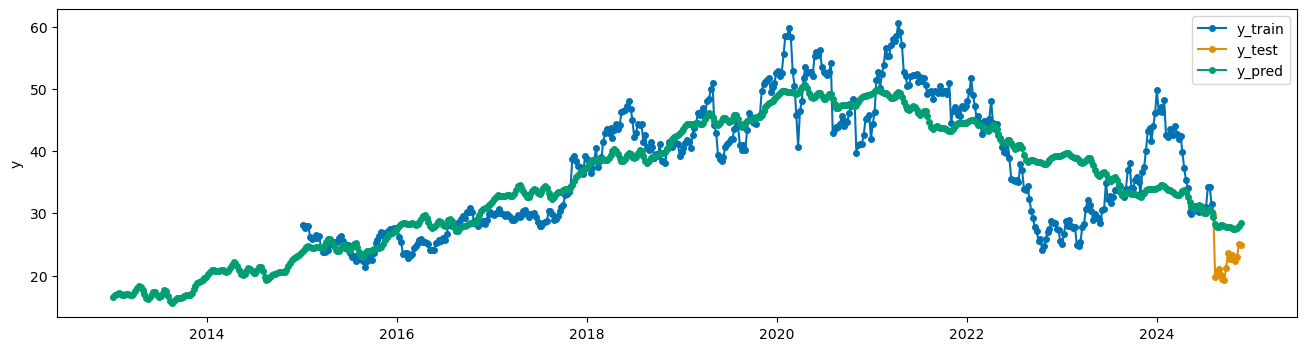

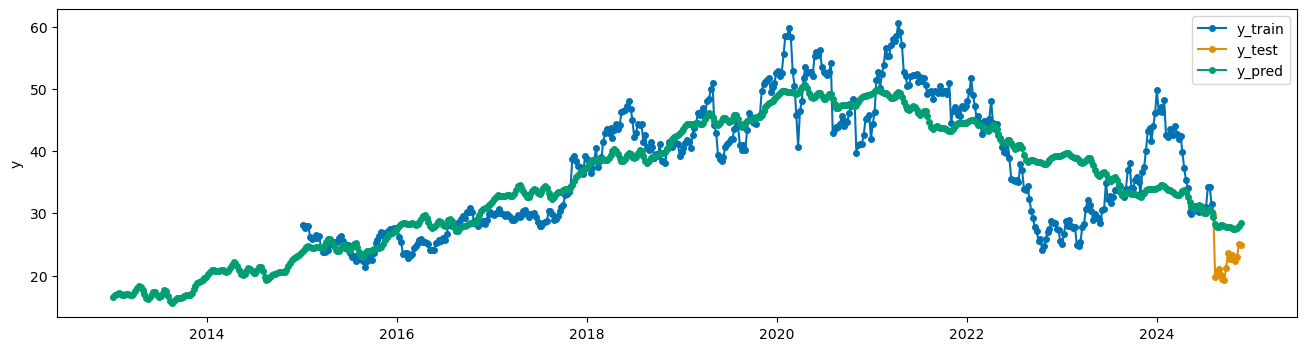

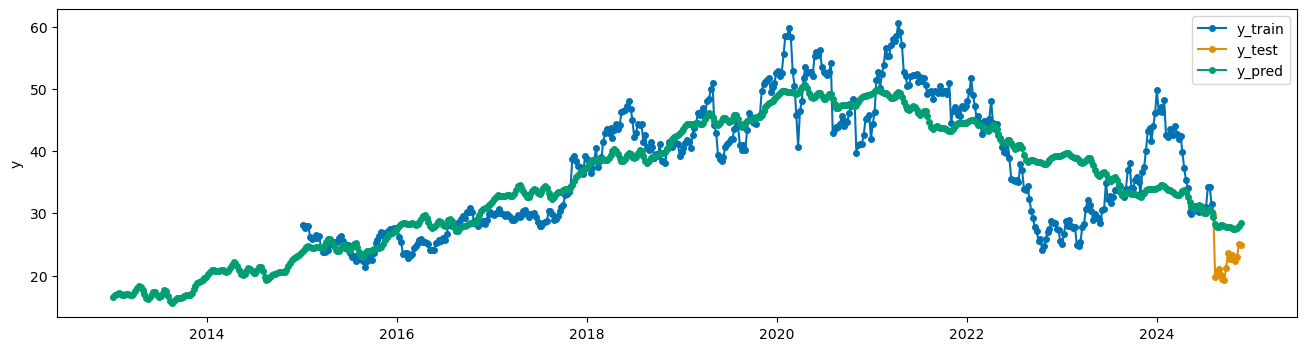

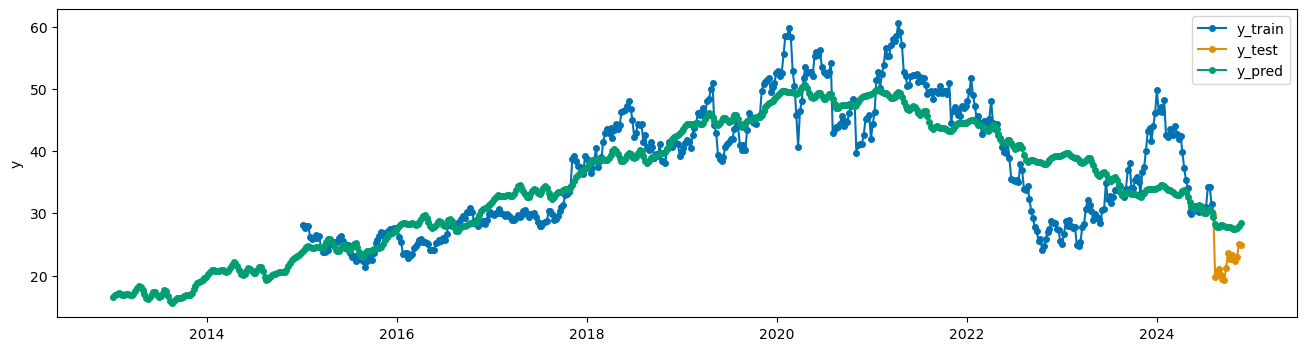

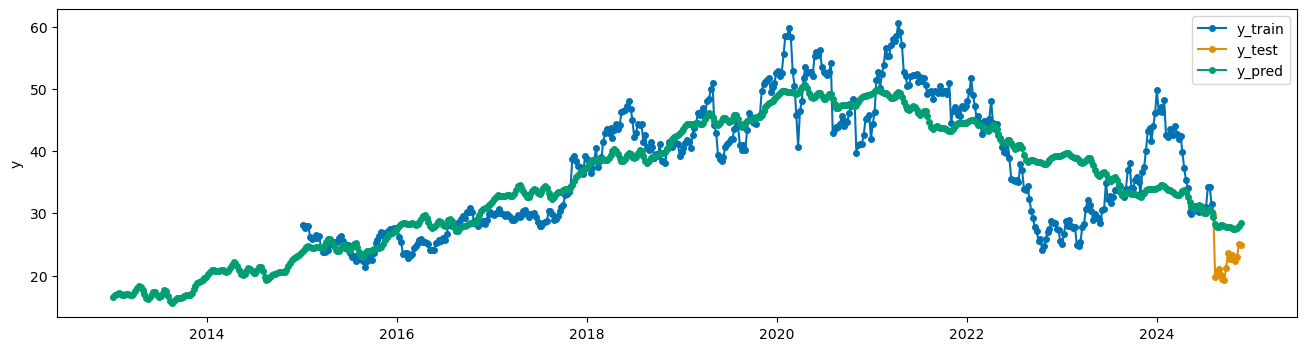

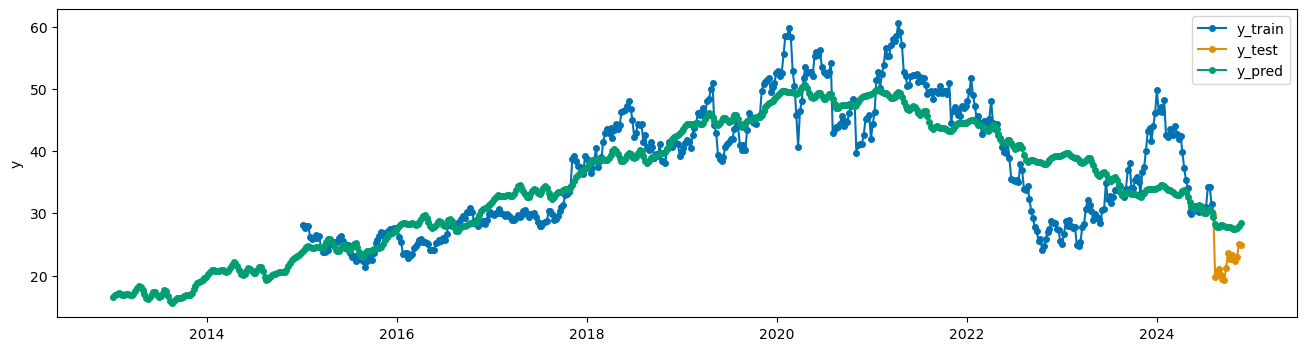

In [19]:
from sktime.utils.plotting import plot_series

# Iterate over each ticker in company_params
for ticker, params in company_params.items():
    print(f"\nProcessing ticker: {ticker}...")

    # Retrieve parameter ranges for the current ticker
    param_ranges = {
        'changepoint_prior_scale': np.round(np.linspace(
            params['changepoint_prior_scale'] / 2,
            params['changepoint_prior_scale'] * 2,
            10), 5),
        'seasonality_prior_scale': np.round(np.linspace(
            params['seasonality_prior_scale'] / 2,
            params['seasonality_prior_scale'] * 2,
            10), 5),
        'seasonality_mode': ['additive', 'multiplicative'],
        'weekly_seasonality': [True, False],
        'yearly_seasonality': [True, False],
        'daily_seasonality': [True, False]
    }

    # Create parameter combinations
    param_combinations = list(product(
        param_ranges['changepoint_prior_scale'],
        param_ranges['seasonality_prior_scale'],
        param_ranges['seasonality_mode'],
        param_ranges['weekly_seasonality'],
        param_ranges['yearly_seasonality'],
        param_ranges['daily_seasonality']
    ))

    total_combinations = len(param_combinations)
    print(f"Total combinations for {ticker}: {total_combinations}")

    # Variables to store the best results
    best_mape = float('inf')
    best_params = None

    # Iterate over each parameter combination
    for i, param_set in enumerate(param_combinations, start=1):
        changepoint_prior_scale, seasonality_prior_scale, seasonality_mode, weekly_seasonality, yearly_seasonality, daily_seasonality = param_set

        print(f"Processing combination {i}/{total_combinations} for {ticker}...", end="\r")

        try:
            # Prepare data
            train_data = train_dataframes[ticker][['Close']].copy()
            train_data.index = pd.to_datetime(train_data.index)
            train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

            test_data = test_dataframes[ticker][['Close']].copy()
            test_data.index = pd.to_datetime(test_data.index)

            # Create and fit the Prophet model
            model = Prophet(
                changepoint_prior_scale=changepoint_prior_scale,
                seasonality_prior_scale=seasonality_prior_scale,
                seasonality_mode=seasonality_mode,
                weekly_seasonality=weekly_seasonality,
                yearly_seasonality=yearly_seasonality,
                daily_seasonality=daily_seasonality
            )
            model.fit(train_data_prophet)

            # Make predictions
            future = model.make_future_dataframe(periods=test_weeks, freq='W')
            forecast = model.predict(future)
            forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

            # Calculate MAPE
            actuals = test_data['Close']
            predictions = forecast_filtered['Close']
            common_index = actuals.index.intersection(predictions.index)
            mape = mean_absolute_percentage_error(actuals.loc[common_index], predictions.loc[common_index]) * 100

            # Update best parameters if MAPE improves
            if mape < best_mape:
                best_mape = mape
                best_params = {
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'seasonality_prior_scale': seasonality_prior_scale,
                    'seasonality_mode': seasonality_mode,
                    'weekly_seasonality': weekly_seasonality,
                    'yearly_seasonality': yearly_seasonality,
                    'daily_seasonality': daily_seasonality
                }
        except Exception as e:
            print(f"\nError for {ticker} with parameters {param_set}: {e}")

    print(f"\nFinished all combinations for {ticker}")

    # Save the best parameters and final MAPE for the current ticker
    best_params_per_company[ticker] = best_params
    final_mape_per_company[ticker] = best_mape

    # Display best parameters and MAPE for the current ticker
    print(f"Best parameters for {ticker}: {best_params} with MAPE: {best_mape:.2f}")

    # Plot the forecast results for the current ticker
    plot_series(
        train_data_prophet.set_index("ds")['y'][-500:],  # Last 500 points of training data
        test_data['Close'],
        forecast.set_index("ds")['yhat'],
        labels=["y_train", "y_test", "y_pred"]
    )

# Print final results for all tickers
print("\nFinal results for all tickers:")
for key, best_params in best_params_per_company.items():
    print(f"{key}: Best parameters: {best_params}, Final MAPE: {final_mape_per_company[key]:.2f}")


# Dictionary to store each optimized Prophet model by company
prophet_models = {}

# Hyperparameter grid for fine-tuning
param_grid = {
    'changepoint_prior_scale': np.arange(0.005, 0.5, 0.01).round(3).tolist(),
    'seasonality_prior_scale': np.arange(0.2, 9.0, 0.1).round(3).tolist(),  # Adjusted range based on the image
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
    'yearly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}

# Define the total number of parameter combinations
total_combinations = len(list(ParameterGrid(param_grid)))

# Iterate over each company in company_tickers
for company in company_tickers.values():
    # Prepare the training data for Prophet
    train_data = train_dataframes[company][['Close']].copy()
    train_data.index = pd.to_datetime(train_data.index)  # Ensure DatetimeIndex
    train_data_prophet = train_data.reset_index(names="ds").rename(columns={'Close': 'y'})

    # Placeholder variables for tracking the best model
    best_mape = float('inf')
    best_params = None
    best_model = None

    # Perform grid search over the parameter grid
    for i, params in enumerate(ParameterGrid(param_grid), start=1):
#         print(f"Processing combination {i} of {total_combinations} for {company}...")

        # Initialize and fit the Prophet model with the current set of parameters
        model = Prophet(
            changepoint_prior_scale=params['changepoint_prior_scale'],
            seasonality_prior_scale=params['seasonality_prior_scale'],
            seasonality_mode=params['seasonality_mode'],
            weekly_seasonality=params['weekly_seasonality'],
            yearly_seasonality=params['yearly_seasonality'],
            daily_seasonality=params['daily_seasonality']
        )
        
        # Fit the model
        model.fit(train_data_prophet)

        # Define the forecast horizon (e.g., test_weeks periods into the future)
        future = model.make_future_dataframe(periods=test_weeks, freq='W')
        forecast = model.predict(future)
        
        # Filter forecasted data
        forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]
        
        # Evaluate the model performance on test data
        actuals = test_dataframes[company]['Close']
        predictions = forecast_filtered['Close']

        # Align indices
        common_index = actuals.index.intersection(predictions.index)
        actuals = actuals.loc[common_index]
        predictions = predictions.loc[common_index]

        mape = mean_absolute_percentage_error(actuals, predictions) * 100
        rmse = root_mean_squared_error(actuals, predictions)
        
        # Check if current model is better
        if mape < best_mape:
            best_mape = mape
            best_params = params
            best_model = model

    # Print best parameters and MAPE for each company
    print(f'Best parameters for {company}: {best_params} with MAPE: {best_mape:.2f}')

    # Plot the best model's predictions
    future = best_model.make_future_dataframe(periods=test_weeks, freq='W')
    forecast = best_model.predict(future)
    forecast_filtered = forecast[['ds', 'yhat']].set_index('ds').rename(columns={'yhat': 'Close'})[-test_weeks:]

    plot_series(
        train_data_prophet.set_index('ds')[-500:],  # Only show the last 500 training points
        test_dataframes[company],                   # Test data
        forecast_filtered,                          # Forecasted data
        labels=["y_train", "y_test", "y_pred"]
    )
    
    plt.title(f'Optimized Forecasting for {company}')
    plt.show()

    # Refit the best model with all available data (train + test)
    # train_data_prophet = train_data_prophet.reset_index(names="ds")
    test_data = pd.DataFrame(actuals).rename(columns={'Close': 'y'}).reset_index(names="ds")
    all_data = pd.concat([train_data_prophet, test_data])

    # Re-initialize Prophet with the best parameters
    prophet_model = Prophet(
        changepoint_prior_scale=best_params['changepoint_prior_scale'],
        seasonality_prior_scale=best_params['seasonality_prior_scale'],
        seasonality_mode=best_params['seasonality_mode'],
        weekly_seasonality=best_params['weekly_seasonality'],
        yearly_seasonality=best_params['yearly_seasonality'],
        daily_seasonality=best_params['daily_seasonality']
    )
    
    # Fit the model on all data
    prophet_model.fit(all_data)

    # Store the optimized model in the dictionary
    prophet_models[company] = prophet_model

The end results of the fine-tunning for the prophet models of all the suppliers and clients of ASML are shown bellow:

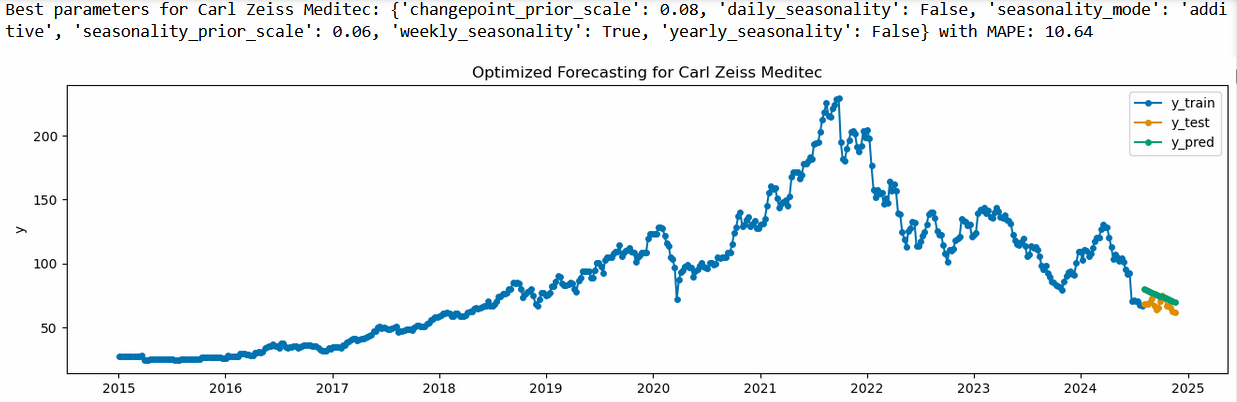
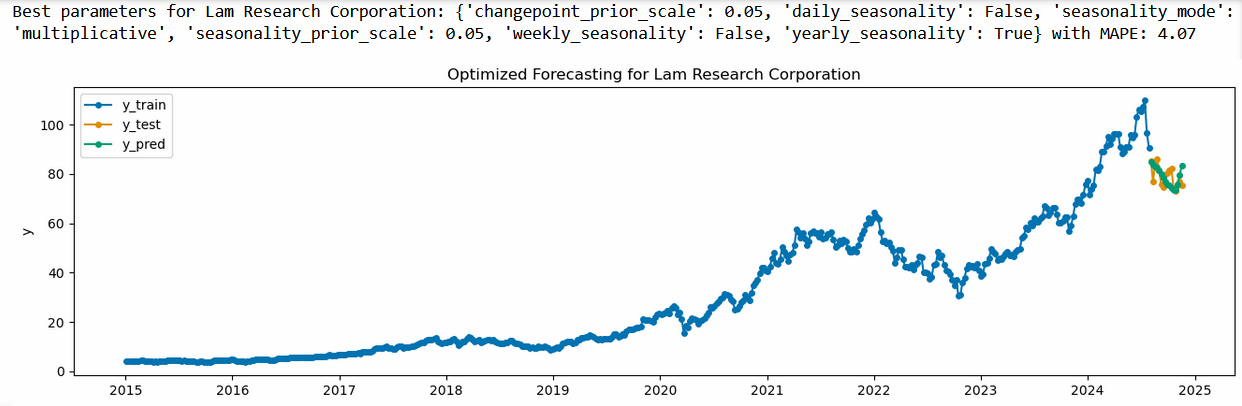
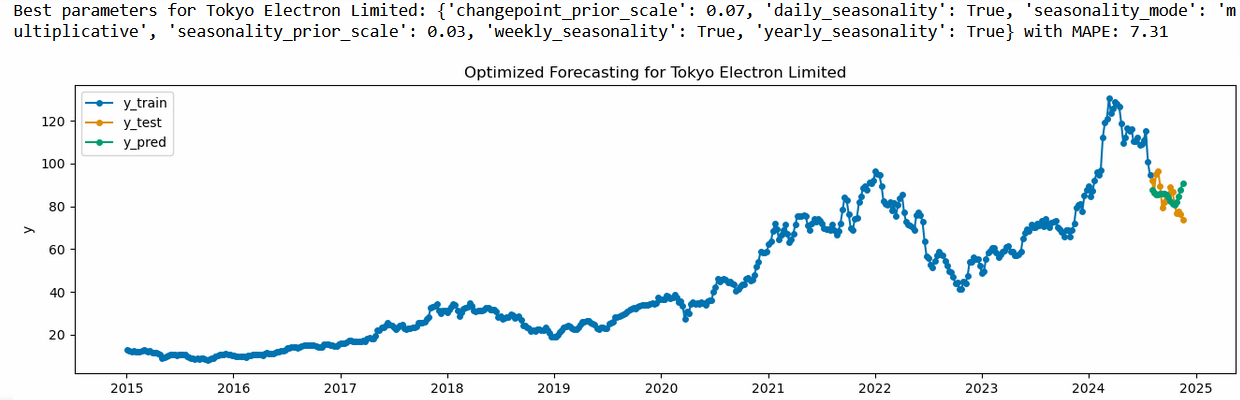
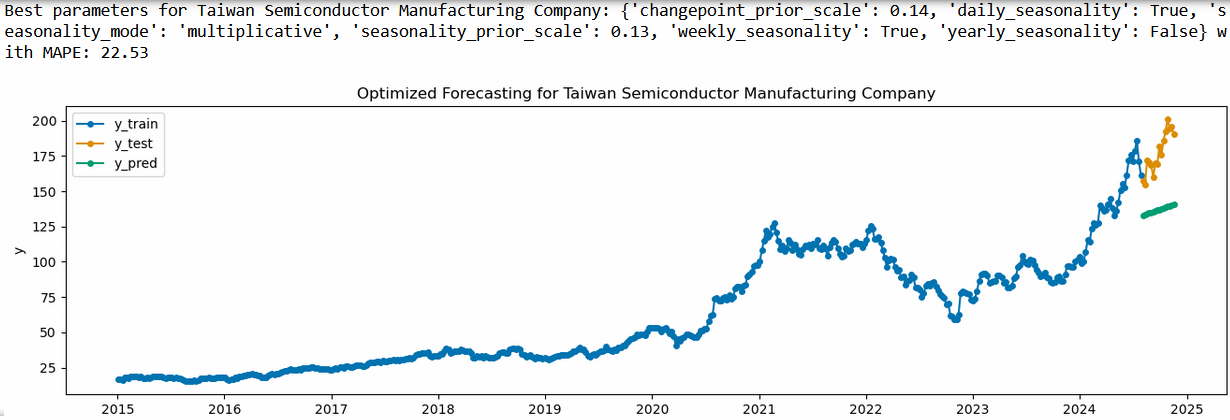
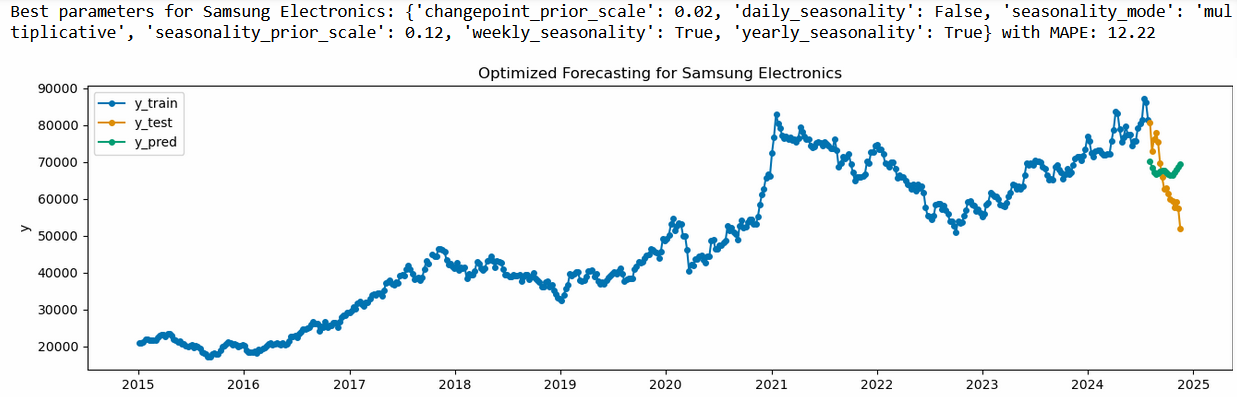
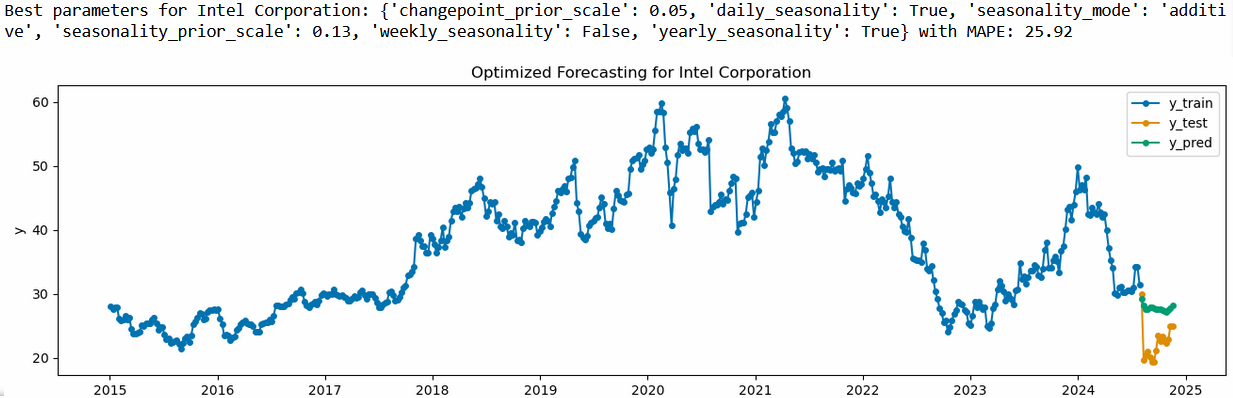

#### 2.5.6.4 Save the best prophet models of ASML's suppliers

In [18]:
# Iterate over each company in prophet_models
for company in company_tickers.values():
    # Define the output path for the current company's model
    output_model_path = f'models/prophet_asml_supplier_{company.replace(" ", "_")}.pkl'

    # Save the current company's Prophet model
    joblib.dump(prophet_models[company], output_model_path)
    print(f'Prophet model for {company} saved at {output_model_path}')

Prophet model for Carl Zeiss Meditec saved at models/prophet_asml_supplier_Carl_Zeiss_Meditec.pkl
Prophet model for Lam Research Corporation saved at models/prophet_asml_supplier_Lam_Research_Corporation.pkl
Prophet model for Tokyo Electron Limited saved at models/prophet_asml_supplier_Tokyo_Electron_Limited.pkl
Prophet model for Taiwan Semiconductor Manufacturing Company saved at models/prophet_asml_supplier_Taiwan_Semiconductor_Manufacturing_Company.pkl
Prophet model for Samsung Electronics saved at models/prophet_asml_supplier_Samsung_Electronics.pkl
Prophet model for Intel Corporation saved at models/prophet_asml_supplier_Intel_Corporation.pkl


# 3. Export the data

In [19]:
# Export the weekly_data_suppliers to a CSV file
weekly_data_suppliers.to_csv(output_data, index=True, sep=';')